In [1]:
import os

import numpy as np
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
from tqdm import tqdm
import math

# 解壓縮資料

In [2]:
def unzip_data(path):
    for folder, _, files in os.walk(path):
        for file in files:
            if file.endswith('zip'):
                file_path = os.path.join(folder, file)
                print(file_path)

                sotre_path = os.path.join(folder, file.rsplit('.')[0])
                # 開啟 ZIP 壓縮檔 
                with zipfile.ZipFile(file_path, 'r') as zf:
                    # 解壓縮所有檔案至 /my/folder 目錄
                    zf.extractall(path=sotre_path)

In [3]:
# unzip_data('./swing')

In [4]:
def convert_csv(path):
    acc_df = pd.read_csv(os.path.join(path, 'Accelerometer.csv'), delimiter=',')
    gyo_df = pd.read_csv(os.path.join(path, 'Gyroscope.csv'), delimiter=',')
    linacc_df = pd.read_csv(os.path.join(path, 'Linear Accelerometer.csv'), delimiter=',')
    mag_df = pd.read_csv(os.path.join(path, 'Magnetometer.csv'), delimiter=',')
    device_df = pd.read_csv(os.path.join(path, 'meta', 'device.csv'), delimiter=',')
    time_df = pd.read_csv(os.path.join(path, 'meta', 'time.csv'), delimiter=',')
    
    acc_df.to_csv(os.path.join(path, 'Accelerometer.csv'), index=False, sep=';')
    gyo_df.to_csv(os.path.join(path, 'Gyroscope.csv'), index=False, sep=';')
    linacc_df.to_csv(os.path.join(path, 'Linear Accelerometer.csv'), index=False, sep=';')
    mag_df.to_csv(os.path.join(path, 'Magnetometer.csv'), index=False, sep=';')
    device_df.to_csv(os.path.join(path, 'meta', 'device.csv'), index=False, sep=';')
    time_df.to_csv(os.path.join(path, 'meta', 'time.csv'), index=False, sep=';')

In [ ]:
# convert_csv('./pocket/202301101952/target')
# convert_csv('./pocket/202301101952/source')

# 讀檔

In [2]:
def rename_data(df):
    new_names = ['system_time', 'acc_times', 'acc_x', 'acc_y', 'acc_z', 'gyo_times', 'gyo_x', 'gyo_y', 'gyo_z', 'lin_acc_times', 'lin_acc_x', 'lin_acc_y', 'lin_acc_z', 'mag_times', 'mag_x', 'mag_y', 'mag_z']
    df.columns = new_names
    
    return df


def device_start_system_time(path):
    time_df = pd.read_csv(path, delimiter=';', index_col=0)
    time = time_df.T.loc['system time', 'START']
    
    return time


def load_original_data(path):
    acc_df = pd.read_csv(os.path.join(path, 'Accelerometer.csv'), delimiter=';')
    gyo_df = pd.read_csv(os.path.join(path, 'Gyroscope.csv'), delimiter=';')
    linacc_df = pd.read_csv(os.path.join(path, 'Linear Accelerometer.csv'), delimiter=';')
    mag_df = pd.read_csv(os.path.join(path, 'Magnetometer.csv'), delimiter=';')
    start_time = device_start_system_time(os.path.join(path, 'meta/time.csv'))
    time_df = acc_df.iloc[:, 0] + start_time
    
    total_df = pd.concat([time_df, acc_df, gyo_df, linacc_df, mag_df], axis=1)
    total_df = rename_data(total_df)
    
    return total_df

In [3]:
def align_data(source_df, target_df):
    source_start_time = source_df.loc[0, 'system_time']
    target_start_time = target_df.loc[0, 'system_time']
    
    # align start time
    if source_start_time > target_start_time:  # source start time > target start time
        target_start_idx = np.argmin(np.abs(target_df.system_time - source_start_time))
        target_df = target_df.iloc[target_start_idx:].reset_index(drop=True)
    else:  # source start time < target start time
        source_start_idx = np.argmin(np.abs(source_df.system_time - target_start_time))
        source_df = source_df.iloc[source_start_idx:].reset_index(drop=True)
        
    # align end idx
    end_idx = min(len(source_df), len(target_df))
    source_df = source_df.iloc[:end_idx]
    target_df = target_df.iloc[:end_idx]
    
    return source_df, target_df


def bound_range(df):
    start = datapoint_per_second * 35
    end = len(df) - datapoint_per_second * 20
    
    return df.iloc[start:end].reset_index(drop=True)


def split_segments(df, chunk_size=5, seq_len=25):
#     length = datapoint_per_second * duration
    length = chunk_size * seq_len
    num_of_segs = int(np.floor(len(df) / length))
    
    segments = []
    for i in range(num_of_segs):
        seg = df.iloc[int(i * length):int((i + 1) * length)].to_numpy()
        segments.append(np.array(np.split(seg, chunk_size)))
        
    return segments


def select_data(df):
    return df[['acc_x', 'acc_y', 'acc_z', 'gyo_x', 'gyo_y', 'gyo_z', 'lin_acc_x', 'lin_acc_y', 'lin_acc_z', 'mag_x', 'mag_y', 'mag_z', 'system_time']]


def preprocess_data(df, chunk_size=5, seq_len=25):
    pre_df = select_data(df)
    segs = split_segments(pre_df, chunk_size, seq_len)
    
    return segs

In [4]:
def device_version(path):
    device_df = pd.read_csv(path, delimiter=';', index_col=0)
    version = device_df.loc['deviceRelease'].value
    
    return version


def check_data_device(source_path, target_path):
    while True:
        source_version = device_version(os.path.join(source_path, 'meta/device.csv'))
        target_version = device_version(os.path.join(target_path, 'meta/device.csv'))

        print(source_path, target_path)

        if source_version[:2] == '15' and target_version[:2] == '16':
            return source_path, target_path
        elif source_version[:2] == '16' and target_version[:2] == '15':
            source_path = os.path.join(folder_path, 'target')
            target_path = os.path.join(folder_path, 'source')
            print('--- GG ---')
            continue
        else:
            raise


def load_pair_data(root_folder, class_num):
    pair_data = []

    for folder in os.listdir(root_folder):
        if folder.startswith('.'):
            continue

        folder_path = os.path.join(root_folder, folder)
        source_path = os.path.join(folder_path, 'source')
        target_path = os.path.join(folder_path, 'target')
        
        print(folder_path)
        
        #########################
        ##### check devices #####
        #########################
        source_path, target_path = check_data_device(source_path, target_path)
        
        ####################################
        ##### load and preprocess data #####
        ####################################
        source_df = load_original_data(source_path)
        target_df = load_original_data(target_path)
        
#         print(source_df.system_time[0], target_df.system_time[0])
        
        source_df, target_df = align_data(source_df, target_df)
        source_df, target_df = bound_range(source_df), bound_range(target_df)
        
#         print(source_df.system_time[0], target_df.system_time[0])
#         print(source_df.system_time[len(source_df) - 1], target_df.system_time[len(target_df) - 1])
#         print(len(source_df), len(target_df))
        
#         plt.figure(figsize=(30, 5))
#         plt.plot(np.arange(len(source_df)), source_df.acc_x)
#         plt.plot(np.arange(len(target_df)), target_df.acc_y)
#         plt.show()
        
        source_segs = preprocess_data(source_df, chunk_size, seq_len)
        target_segs = preprocess_data(target_df, chunk_size, seq_len)
        
        idx = min(len(source_segs), len(target_segs))
        source_tags = [class_num] * idx
        target_tags = [0] * idx
        
        pair_data.extend(zip(source_segs[:idx], source_tags, target_segs[:idx], target_tags))
        
    return pair_data

In [5]:
datapoint_per_second = 20
duration = 2
chunk_size = 5
seq_len = 25
classes = {'target': 0, 'front_pocket': 1, 'pocket': 2, 'swing': 3}

In [6]:
source_device_version = device_version('./front_pocket/202302071523/source/meta/device.csv')
target_device_version = device_version('./front_pocket/202302071523/target/meta/device.csv')
print(f"source device version: {source_device_version}")  # source version: 15.4
print(f"target device version: {target_device_version}")  # target version: 16.3

source device version: 15.4
target device version: 16.3


In [12]:
front_pocket_pair_data = load_pair_data('./front_pocket', class_num=1)
pocket_pair_data = load_pair_data('./pocket', class_num=2)
swing_pair_data = load_pair_data('./swing', class_num=3)

./front_pocket/202302071628
./front_pocket/202302071628/source ./front_pocket/202302071628/target
./front_pocket/202302071652
./front_pocket/202302071652/source ./front_pocket/202302071652/target
./front_pocket/202302071523
./front_pocket/202302071523/source ./front_pocket/202302071523/target
./front_pocket/202302071531
./front_pocket/202302071531/source ./front_pocket/202302071531/target
./front_pocket/202302071715
./front_pocket/202302071715/source ./front_pocket/202302071715/target
./front_pocket/202302071641
./front_pocket/202302071641/source ./front_pocket/202302071641/target
./front_pocket/202302071541
./front_pocket/202302071541/source ./front_pocket/202302071541/target
./front_pocket/202302071619
./front_pocket/202302071619/source ./front_pocket/202302071619/target
./front_pocket/202302071704
./front_pocket/202302071704/source ./front_pocket/202302071704/target
./front_pocket/202302071724
./front_pocket/202302071724/source ./front_pocket/202302071724/target
./pocket/20230213210

In [13]:
print(len(front_pocket_pair_data), len(pocket_pair_data), len(swing_pair_data))

456 437 427


In [14]:
front_pocket_pair_data[0][0][0, -1], front_pocket_pair_data[0][2][0, -1]

(array([-1.18164276e+00,  1.13118269e+01, -1.10844498e+00, -5.40463984e-01,
        -1.87591553e+00,  5.90145647e-01,  4.08018416e-01, -1.88228362e+00,
        -2.25128342e+00,  1.24117289e+01, -1.55095520e+01,  3.97043762e+01,
         1.67575812e+09]),
 array([ 1.08823700e-01,  9.23489594e+00,  6.51071091e+00,  2.38888234e-01,
        -1.13709919e-01,  3.30951400e-02,  3.23165961e-01,  9.69002332e-01,
         1.22304923e+00, -3.65958176e+01,  1.05057907e+00, -2.49110413e+01,
         1.67575811e+09]))

# 建立dataloader

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score

In [ ]:
# class ClassDataset(Dataset):
#     def __init__(self, data, label):
#         self.data = data
#         self.label = label

#     def __len__(self):
#         return len(self.data)

#     def __getitem__(self, idx):
#         return self.data[idx], self.label[idx]

In [16]:
class PairDataset(Dataset):
    def __init__(self, source_data, source_label, target_data, target_label):
        self.source_data = source_data
        self.source_label = source_label
        self.target_data = target_data
        self.target_label = target_label

    def __len__(self):
        return len(self.source_data)

    def __getitem__(self, idx):
        return self.source_data[idx], self.source_label[idx], self.target_data[idx], self.target_label[idx]

In [17]:
class Classifier(nn.Module):
    def __init__(self, chunk_size=5, seq_len=21, num_of_classes=2):
        super(Classifier, self).__init__()
        
        self.chunk_size = chunk_size
        self.seq_len = seq_len
        self.num_of_classes = num_of_classes
        
        self.cnn = nn.Sequential(
            nn.Conv1d(9, 16, kernel_size=5),
            nn.LeakyReLU(),
            nn.Conv1d(16, 16, kernel_size=5),
            nn.LeakyReLU(),
        )
        
        # 16 * (seq_len-8)
        self.rnn = nn.RNN(input_size=16 * (seq_len - 8), hidden_size=64, num_layers=2, batch_first=True)
        
        self.last = nn.Sequential(
            nn.Linear(64, 16),
            nn.Tanh(),
            nn.Linear(16, num_of_classes),
            nn.Softmax(dim=2),
        )
        
    def forward(self, x):  # input: (bs, chunk_size, seq_len, 9)
        h = torch.reshape(x, (len(x) * self.chunk_size, self.seq_len, -1))  # (bs, chunk_size, seq_len, 9) -> (bs * chunk_size, seq_len, 9)
        h = torch.permute(h, (0, 2, 1))  # (bs * chunk_size, seq_len, 9) -> (bs * chunk_size, 9, seq_len) [CNN要對最後一個維度做卷積]
        
        h = self.cnn(h)

        h = torch.permute(h, (0, 2, 1))
        h = torch.reshape(h, (len(x), self.chunk_size, -1))
        
        hz, _ = self.rnn(h)
        out = self.last(hz)

        out = torch.reshape(out, (len(x), self.chunk_size, self.num_of_classes))
        
        return out, hz
    

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:x.size(0), :].to(x.device)
        return self.dropout(x)
    

class NotSimpleTransformer(nn.Module):
    def __init__(self, chunk_size=5, seq_len=21, num_of_classes=2):
        super(NotSimpleTransformer, self).__init__()
        
        self.chunk_size = chunk_size
        self.seq_len = seq_len
        self.num_of_classes = num_of_classes
        
        self.pos_encoder = PositionalEncoding(64 * self.seq_len, 0.1)
        
        ################
        ### Imu Part ###
        ################
        self.classifier = Classifier(chunk_size, seq_len, num_of_classes)
        
        ################
        ### Mag Part ###
        ################
        self.mag_layer = nn.Sequential(
            nn.Linear(3, 16),
            nn.LeakyReLU(),
            nn.Linear(16, 64),
            nn.LeakyReLU(),
        )
        
        self.mag_transformer_encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=64 * self.seq_len, nhead=8, dropout=0.1, batch_first=True), num_layers=4)
        self.mag_transformer_decoder = nn.TransformerDecoder(nn.TransformerDecoderLayer(d_model=64 * self.seq_len, nhead=8, dropout=0.1, batch_first=True), num_layers=4)
        self.mag_last = nn.Sequential(
            nn.Linear(64 * self.seq_len, 16 * self.seq_len),
            nn.LeakyReLU(),
            nn.Linear(16 * self.seq_len, 3 * self.seq_len),
        )
        
    def forward(self, source_mag, target_mag=None):

        if target_mag != None:
            ################
            ### imu part ###
            ################
#             source_h = self.imu_layer(source_imu)
#             source_hz, _ = self.imu_rnn(source_h)
#             source_predict_probability = self.imu_last(source_hz[:, -1])

            ################
            ### mag part ###
            ################
            source_mag_h = self.mag_layer(source_mag)  # (batch, chunk_size, seq_len, 3) -> (batch, chunk_size, seq_len, 64)
            source_mag_h = torch.reshape(source_mag_h, (len(source_mag), self.chunk_size, -1))  # (batch, chunk_size, seq_len, 64) -> (batch, chunk_size, seq_len * 64)
            source_mag_h = self.pos_encoder(source_mag_h)  # (batch, chunk_size, seq_len * 64)
            
            
            tgt = self.mag_layer(target_mag)  # (batch, chunk_size, seq_len, 3) -> (batch, chunk_size, seq_len, 64)
            tgt = torch.reshape(tgt, (len(source_mag), self.chunk_size, -1))  # (batch, chunk_size, seq_len, 64) -> (batch, chunk_size, seq_len * 64)
            tgt = self.pos_encoder(tgt)  # (batch, chunk_size, seq_len * 64)
            
            source_mag_hz= self.mag_transformer_encoder(source_mag_h)  # (batch, chunk_size, seq_len * 64) -> (batch, chunk_size, seq_len * 64)

#             source_latent = torch.add(source_hz, source_mag_hz)  # (batch, chunk_size, 48)
            predict_mag_latent = self.mag_transformer_decoder(tgt, source_mag_hz)  # (batch, chunk_size, seq_len * 64) -> (batch, chunk_size, seq_len * 64)
            predict_mag = self.mag_last(predict_mag_latent)  # (batch, chunk_size, seq_len * 64) -> (batch, chunk_size, seq_len * 3)
            predict_mag = torch.reshape(predict_mag, (len(source_mag), self.chunk_size, self.seq_len, -1))  # (batch * chunk_size, seq_len, 3) -> (batch, chunk_size, seq_len, 3)

            return predict_mag
        
        else:
            ################
            ### imu part ###
            ################
#             source_h = self.imu_layer(source_imu)
#             source_hz, _ = self.imu_rnn(source_h)
#             source_predict_probability = self.imu_last(source_hz[:, -1])

            ################
            ### mag part ###
            ################
            source_mag_h = self.mag_layer(source_mag)  # (batch, chunk_size, seq_len, 3) -> (batch, chunk_size, seq_len, 64)
            source_mag_h = torch.reshape(source_mag_h, (len(source_mag), self.chunk_size, -1))  # (batch, chunk_size, seq_len, 64) -> (batch, chunk_size, seq_len * 64)
            source_mag_h = self.pos_encoder(source_mag_h)  # (batch, chunk_size, seq_len * 64)
            source_mag_hz= self.mag_transformer_encoder(source_mag_h)  # (batch, chunk_size, seq_len * 64) -> (batch, chunk_size, seq_len * 64)

#             source_latent = torch.add(source_hz, source_mag_hz)  # (batch, chunk_size, 48)
            tgt = torch.zeros_like(source_mag_hz)
            for i in range(source_mag_hz.size(1)):
                tgt_pos = self.pos_encoder(torch.zeros(source_mag_hz.size(0), 1, source_mag_hz.size(-1)).to(source_mag_hz.device) + i)
#                 tgt_pos = self.pos_encoder(tgt.clone())
                decode_position = self.mag_transformer_decoder(tgt_pos, source_mag_hz[:, :i+1, :], memory_key_padding_mask=None)
                tgt[:, i, :] = decode_position[:, -1, :]
            predict_mag = self.mag_last(tgt)  # (batch, chunk_size, seq_len * 64) -> (batch, chunk_size, seq_len * 3)
            predict_mag = torch.reshape(predict_mag, (len(source_mag), self.chunk_size, self.seq_len, -1))  # (batch * chunk_size, seq_len, 3) -> (batch, chunk_size, seq_len, 3)
            
            return predict_mag


In [18]:
# class NotSimpleRNN(nn.Module):
#     def __init__(self, seq_len=100, num_of_classes=2):
#         super(NotSimpleRNN, self).__init__()
        
#         self.seq_len = seq_len
        
#         ################
#         ### Imu Part ###
#         ################
#         self.imu_layer = nn.Sequential(
#             nn.Linear(8, 16),
#             nn.Tanh(),
#             nn.Linear(16, 32),
#             nn.LeakyReLU(),
#         )
        
#         self.imu_rnn = nn.LSTM(input_size=32, hidden_size=32, num_layers=2, batch_first=True)
# #         self.lstm = nn.LSTM(input_size=16, hidden_size=16, num_layers=2, batch_first=True, bidirectional=True)
        
#         self.imu_last = nn.Sequential(
#             nn.Linear(32, 32),
#             nn.LeakyReLU(),
#             nn.Linear(32, num_of_classes),
#             nn.Softmax(dim=1),
#         )
        
#         ################
#         ### Mag Part ###
#         ################
#         self.mag_layer = nn.Sequential(
#             nn.Linear(3, 16),
#             nn.LeakyReLU(),
#             nn.Linear(16, 16),
#             nn.LeakyReLU(),
#         )
        
#         self.mag_rnn_encoder = nn.LSTM(input_size=16, hidden_size=16, num_layers=4, batch_first=True)
#         self.mag_rnn_decoder = nn.LSTM(input_size=48, hidden_size=16, num_layers=4, batch_first=True)
#         self.mag_last = nn.Sequential(
#             nn.Linear(16, 8),
#             nn.LeakyReLU(),
#             nn.Linear(8, 3),
#         )
        
#     def forward(self, source_imu, source_mag):
#         ### imu part ###
#         source_h = self.imu_layer(source_imu)
#         source_hz, _ = self.imu_rnn(source_h)
#         source_predict_probability = self.imu_last(source_hz[:, -1])
        
#         ### mag part ###
#         source_mag_h = self.mag_layer(source_mag)  # (batch, seq_len, 16)
#         source_mag_hz, _ = self.mag_rnn_encoder(source_mag_h)  # (batch, seq_len, 16)
        
#         source_latent = torch.concat([source_hz, source_mag_hz], dim=-1)  # (batch, seq_len, 48)
        
#         predict_mag_latent, _ = self.mag_rnn_decoder(source_latent)
#         predict_mag = self.mag_last(predict_mag_latent)
        
#         return source_predict_probability, predict_mag

In [19]:
# class NotSimpleTransformer(nn.Module):
#     def __init__(self, seq_len=100, num_of_classes=2):
#         super(NotSimpleTransformer, self).__init__()
        
#         self.seq_len = seq_len
#         self.pos_encoder = PositionalEncoding(64, 0.1)
#         ################
#         ### Imu Part ###
#         ################
# #         self.imu_layer = nn.Sequential(
# #             nn.Linear(8, 16),
# #             nn.LeakyReLU(),
# #             nn.Linear(16, 16),
# #             nn.LeakyReLU(),
# #         )
        
# #         self.imu_rnn = nn.LSTM(input_size=16, hidden_size=16, num_layers=2, batch_first=True)
        
# #         self.imu_last = nn.Sequential(
# #             nn.Linear(16, 16),
# #             nn.LeakyReLU(),
# #             nn.Linear(16, num_of_classes),
# #             nn.Softmax(dim=1),
# #         )
        
#         ################
#         ### Mag Part ###
#         ################
#         self.mag_layer = nn.Sequential(
#             nn.Linear(3, 16),
#             nn.LeakyReLU(),
#             nn.Linear(16, 64),
#             nn.LeakyReLU(),
#         )
        
#         self.mag_transformer_encoder = nn.TransformerEncoder(nn.TransformerEncoderLayer(d_model=64, nhead=8, dropout=0.1, batch_first=True), num_layers=4)
#         self.mag_transformer_decoder = nn.TransformerDecoder(nn.TransformerDecoderLayer(d_model=64, nhead=8, dropout=0.1, batch_first=True), num_layers=4)
#         self.mag_last = nn.Sequential(
#             nn.Linear(64, 16),
#             nn.LeakyReLU(),
#             nn.Linear(16, 3),
#         )
        
#     def forward(self, source_mag, target_mag=None):
#         ### imu part ###
#         if target_mag != None:
# #             source_h = self.imu_layer(source_imu)
# #             source_hz, _ = self.imu_rnn(source_h)
# #             source_predict_probability = self.imu_last(source_hz[:, -1])

#             ### mag part ###
#             source_mag_h = self.mag_layer(source_mag)  # (batch, seq_len, 16)
#             source_mag_h = self.pos_encoder(source_mag_h)
#             tgt = self.mag_layer(target_mag)
#             tgt = self.pos_encoder(tgt)
#             source_mag_hz= self.mag_transformer_encoder(source_mag_h)  # (batch, seq_len, 16)

# #             source_latent = torch.add(source_hz, source_mag_hz)  # (batch, seq_len, 48)
#             predict_mag_latent = self.mag_transformer_decoder(tgt, source_mag_hz)
#             predict_mag = self.mag_last(predict_mag_latent)

#             return predict_mag
        
#         else:
            
# #             source_h = self.imu_layer(source_imu)
# #             source_hz, _ = self.imu_rnn(source_h)
# #             source_predict_probability = self.imu_last(source_hz[:, -1])

#             ### mag part ###
#             source_mag_h = self.mag_layer(source_mag)  # (batch, seq_len, 16)
#             source_mag_h = self.pos_encoder(source_mag_h)
#             source_mag_hz= self.mag_transformer_encoder(source_mag_h)  # (batch, seq_len, 16)

# #             source_latent = torch.add(source_hz, source_mag_hz)  # (batch, seq_len, 48)
#             tgt = torch.zeros_like(source_mag_hz)
#             for i in range(source_mag_hz.size(1)):
#                 tgt_pos = self.pos_encoder(torch.zeros(source_mag_hz.size(0), 1, source_mag_hz.size(-1)).to(source_mag_hz.device) + i)
#                 decode_position = self.mag_transformer_decoder(tgt_pos, source_mag_hz[:, :i+1, :], memory_key_padding_mask=None)
#                 tgt[:, i, :] = decode_position[:, -1, :]
#             predict_mag = self.mag_last(tgt)
#             return predict_mag
        
# class PositionalEncoding(nn.Module):
#     def __init__(self, d_model, dropout=0.1, max_len=5000):
#         super(PositionalEncoding, self).__init__()
#         self.dropout = nn.Dropout(p=dropout)

#         pe = torch.zeros(max_len, d_model)
#         position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
#         div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
#         pe[:, 0::2] = torch.sin(position * div_term)
#         pe[:, 1::2] = torch.cos(position * div_term)
#         pe = pe.unsqueeze(0).transpose(0, 1)
#         self.register_buffer('pe', pe)

#     def forward(self, x):
#         x = x + self.pe[:x.size(0), :].to(x.device)
#         return self.dropout(x)


In [18]:
front_pocket_half = int(len(front_pocket_pair_data) * 0.5)
pocket_half = int(len(pocket_pair_data) * 0.5)
swing_half = int(len(swing_pair_data) * 0.5)

train_data = front_pocket_pair_data[:front_pocket_half] #+ pocket_pair_data[:pocket_half] + swing_pair_data[:swing_half]
valid_data = front_pocket_pair_data[front_pocket_half:] #+ pocket_pair_data[pocket_half:] + swing_pair_data[swing_half:]

# train
train_source_data = np.array([d[0] for d in train_data])
train_source_label = np.array([d[1] for d in train_data])
train_target_data = np.array([d[2] for d in train_data])
train_target_label = np.array([d[3] for d in train_data])
train_dataset = PairDataset(
                    source_data = torch.tensor(train_source_data, dtype=torch.float),
                    source_label = train_source_label,
                    target_data = torch.tensor(train_target_data, dtype=torch.float),
                    target_label = train_target_label,
                )
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# valid
valid_source_data = np.array([d[0] for d in valid_data])
valid_source_label = np.array([d[1] for d in valid_data])
valid_target_data = np.array([d[2] for d in valid_data])
valid_target_label = np.array([d[3] for d in valid_data])
valid_dataset = PairDataset(
                    source_data = torch.tensor(valid_source_data, dtype=torch.float),
                    source_label = valid_source_label,
                    target_data = torch.tensor(valid_target_data, dtype=torch.float),
                    target_label = valid_target_label,
                )
valid_loader = DataLoader(valid_dataset, batch_size=32)

In [19]:
batch = next(iter(train_loader))

In [22]:
# batch

In [26]:
EPOCH = 1000
num_of_classes = 4
device = torch.device("cuda" if (torch.cuda.is_available()) else "cpu")
ce_loss = torch.nn.CrossEntropyLoss()
mse_loss = torch.nn.MSELoss()

In [27]:
model = NotSimpleTransformer(chunk_size=chunk_size, seq_len=seq_len, num_of_classes=num_of_classes).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [22]:
def plot_result(result):
    pred_mag = result[0].reshape(-1, 3)
    targ_mag = result[1].reshape(-1, 3)
    x = np.arange(len(pred_mag))
    
    loss = mse_loss(torch.tensor(pred_mag), torch.tensor(targ_mag)).item()
    
    fig = plt.figure(figsize=(15, 5))
    
    for pm, tm, caxis, color in zip(pred_mag.T, targ_mag.T, ['x', 'y', 'z'], ['tab:blue', 'tab:orange', 'tab:green']):
        plt.plot(x, pm, label=f'pred_{caxis}', color=color, linewidth=2.5, zorder=2)
        plt.plot(x, tm, '--', label=f'targ_{caxis}', color=color, linewidth=1, alpha=0.8, zorder=1)
    
    for i in range(0, chunk_size+1):
        plt.axvline(x=int(i * seq_len - 0.5), linewidth=0.5, linestyle='-', color='k', alpha=0.5)
    
    plt.suptitle(f'Loss: {loss:.2f}')
    plt.legend()
    plt.show()

In [23]:
def train(model, dataloader, optimizer, draw=False):
    model.train()

    losses = []
    pred_loss = []

    for source_data, source_label, target_data, target_label in tqdm(dataloader):
        optimizer.zero_grad()

        source_data = source_data.to(device)
        target_data = target_data.to(device)

        one_hot = F.one_hot(source_label, num_classes=num_of_classes).to(device).float()

        predict_mag = model(source_data[:, :, :, 9:12], target_data[:, :, :, 9:12])
        torch.cuda.empty_cache()
        #_, predict_classes = torch.max(predict_probability, 1)

#         class_loss = ce_loss(predict_probability, one_hot)
        predict_loss = mse_loss(predict_mag, target_data[:, :, :, 9:12])
        loss = predict_loss

        # backward
        loss.backward()
#         class_loss.backward()
#         predict_loss.backward()
        optimizer.step()
        
        losses.append(loss.item())
        pred_loss.append(predict_loss.item())
    
    if draw:
        rs = [predict_mag[0].detach().cpu().numpy(), target_data[0, :, :, 9:12].cpu().numpy()]
        plot_result(rs)
    
    return np.mean(losses), np.mean(pred_loss)

In [24]:
def evalute(model, dataloader, draw=False):
    model.eval()

    losses = []
    pred_loss = []
    
    with torch.no_grad():
        for source_data, source_label, target_data, target_label in dataloader:
            source_data = source_data.to(device)
            target_data = target_data.to(device)
            
            one_hot = F.one_hot(source_label, num_classes=num_of_classes).to(device).float()

            #############
            # generator #
            #############
            predict_mag = model(source_data[:, :, :, 9:12])
            #_, predict_classes = torch.max(predict_probability, 1)

            #class_loss = ce_loss(predict_probability, one_hot)
            predict_loss = mse_loss(predict_mag, target_data[:, :, :, 9:12])
            loss = predict_loss
            
            losses.append(loss.item())
            pred_loss.append(predict_loss.item())
    
    if draw:
        rs = [predict_mag[0].detach().cpu().numpy(), target_data[0, :, :, 9:12].cpu().numpy()]
        plot_result(rs)
    
    return np.mean(losses), np.mean(pred_loss)

100%|██████████| 8/8 [00:00<00:00, 17.00it/s]


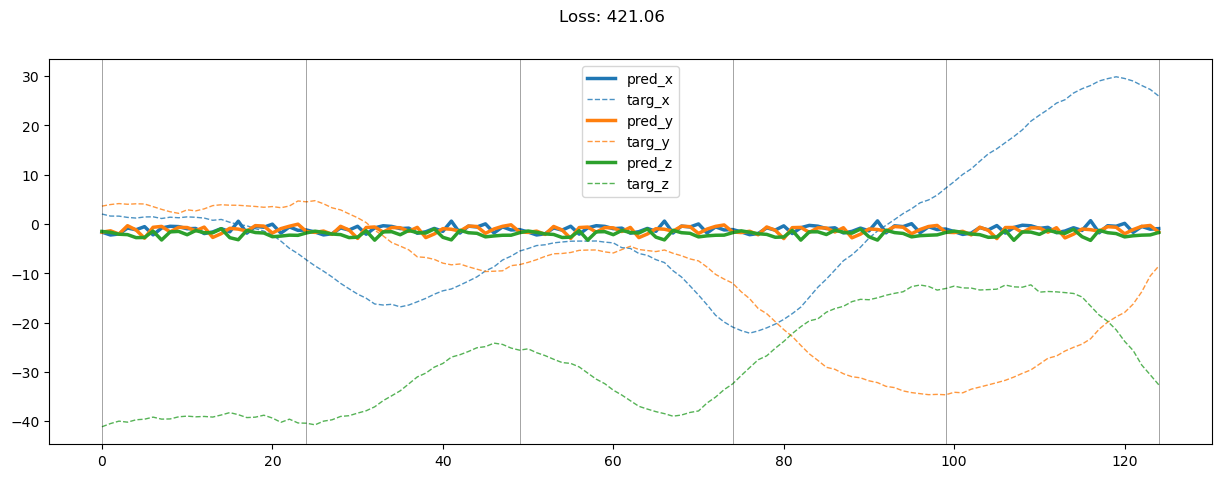

00000: train total loss:  644.730, pred loss:  644.730, valid total loss:  614.295, pred loss:  614.295


100%|██████████| 8/8 [00:00<00:00, 22.42it/s]


00001: train total loss:  585.405, pred loss:  585.405, valid total loss:  587.949, pred loss:  587.949


100%|██████████| 8/8 [00:00<00:00, 19.48it/s]


00002: train total loss:  586.774, pred loss:  586.774, valid total loss:  555.369, pred loss:  555.369


100%|██████████| 8/8 [00:00<00:00, 20.21it/s]


00003: train total loss:  538.612, pred loss:  538.612, valid total loss:  525.362, pred loss:  525.362


100%|██████████| 8/8 [00:00<00:00, 19.76it/s]


00004: train total loss:  494.209, pred loss:  494.209, valid total loss:  506.995, pred loss:  506.995


100%|██████████| 8/8 [00:00<00:00, 17.08it/s]


00005: train total loss:  429.833, pred loss:  429.833, valid total loss:  471.864, pred loss:  471.864


100%|██████████| 8/8 [00:00<00:00, 17.78it/s]


00006: train total loss:  378.117, pred loss:  378.117, valid total loss:  468.114, pred loss:  468.114


100%|██████████| 8/8 [00:00<00:00, 17.27it/s]


00007: train total loss:  321.468, pred loss:  321.468, valid total loss:  469.895, pred loss:  469.895


100%|██████████| 8/8 [00:00<00:00, 17.56it/s]


00008: train total loss:  275.870, pred loss:  275.870, valid total loss:  521.220, pred loss:  521.220


100%|██████████| 8/8 [00:00<00:00, 17.74it/s]


00009: train total loss:  241.159, pred loss:  241.159, valid total loss:  503.473, pred loss:  503.473


100%|██████████| 8/8 [00:00<00:00, 18.26it/s]


00010: train total loss:  192.890, pred loss:  192.890, valid total loss:  539.313, pred loss:  539.313


100%|██████████| 8/8 [00:00<00:00, 22.46it/s]


00011: train total loss:  164.102, pred loss:  164.102, valid total loss:  628.595, pred loss:  628.595


100%|██████████| 8/8 [00:00<00:00, 18.96it/s]


00012: train total loss:  147.030, pred loss:  147.030, valid total loss:  541.103, pred loss:  541.103


100%|██████████| 8/8 [00:00<00:00, 22.43it/s]


00013: train total loss:  116.565, pred loss:  116.565, valid total loss:  571.933, pred loss:  571.933


100%|██████████| 8/8 [00:00<00:00, 22.38it/s]


00014: train total loss:  100.687, pred loss:  100.687, valid total loss:  520.180, pred loss:  520.180


100%|██████████| 8/8 [00:00<00:00, 22.46it/s]


00015: train total loss:  92.599, pred loss:  92.599, valid total loss:  561.412, pred loss:  561.412


100%|██████████| 8/8 [00:00<00:00, 22.20it/s]


00016: train total loss:  87.707, pred loss:  87.707, valid total loss:  552.656, pred loss:  552.656


100%|██████████| 8/8 [00:00<00:00, 22.39it/s]


00017: train total loss:  74.293, pred loss:  74.293, valid total loss:  735.228, pred loss:  735.228


100%|██████████| 8/8 [00:00<00:00, 22.43it/s]


00018: train total loss:  79.976, pred loss:  79.976, valid total loss:  683.284, pred loss:  683.284


100%|██████████| 8/8 [00:00<00:00, 22.49it/s]


00019: train total loss:  79.772, pred loss:  79.772, valid total loss:  652.785, pred loss:  652.785


100%|██████████| 8/8 [00:00<00:00, 22.22it/s]


00020: train total loss:  98.542, pred loss:  98.542, valid total loss:  690.608, pred loss:  690.608


100%|██████████| 8/8 [00:00<00:00, 22.43it/s]


00021: train total loss:  86.669, pred loss:  86.669, valid total loss:  826.049, pred loss:  826.049


100%|██████████| 8/8 [00:00<00:00, 22.43it/s]


00022: train total loss:  69.480, pred loss:  69.480, valid total loss:  691.352, pred loss:  691.352


100%|██████████| 8/8 [00:00<00:00, 22.47it/s]


00023: train total loss:  64.809, pred loss:  64.809, valid total loss:  729.780, pred loss:  729.780


100%|██████████| 8/8 [00:00<00:00, 19.73it/s]


00024: train total loss:  63.067, pred loss:  63.067, valid total loss:  715.082, pred loss:  715.082


100%|██████████| 8/8 [00:00<00:00, 18.96it/s]


00025: train total loss:  57.227, pred loss:  57.227, valid total loss:  721.346, pred loss:  721.346


100%|██████████| 8/8 [00:00<00:00, 19.81it/s]


00026: train total loss:  59.047, pred loss:  59.047, valid total loss:  693.524, pred loss:  693.524


100%|██████████| 8/8 [00:00<00:00, 22.31it/s]


00027: train total loss:  63.268, pred loss:  63.268, valid total loss:  641.424, pred loss:  641.424


100%|██████████| 8/8 [00:00<00:00, 22.35it/s]


00028: train total loss:  49.540, pred loss:  49.540, valid total loss:  547.898, pred loss:  547.898


100%|██████████| 8/8 [00:00<00:00, 22.45it/s]


00029: train total loss:  48.856, pred loss:  48.856, valid total loss:  498.073, pred loss:  498.073


100%|██████████| 8/8 [00:00<00:00, 22.46it/s]


00030: train total loss:  46.324, pred loss:  46.324, valid total loss:  523.428, pred loss:  523.428


100%|██████████| 8/8 [00:00<00:00, 20.08it/s]


00031: train total loss:  52.047, pred loss:  52.047, valid total loss:  706.616, pred loss:  706.616


100%|██████████| 8/8 [00:00<00:00, 18.34it/s]


00032: train total loss:  45.089, pred loss:  45.089, valid total loss:  557.767, pred loss:  557.767


100%|██████████| 8/8 [00:00<00:00, 19.41it/s]


00033: train total loss:  43.908, pred loss:  43.908, valid total loss:  530.309, pred loss:  530.309


100%|██████████| 8/8 [00:00<00:00, 20.34it/s]


00034: train total loss:  38.267, pred loss:  38.267, valid total loss:  576.188, pred loss:  576.188


100%|██████████| 8/8 [00:00<00:00, 21.61it/s]


00035: train total loss:  40.426, pred loss:  40.426, valid total loss:  562.405, pred loss:  562.405


100%|██████████| 8/8 [00:00<00:00, 22.49it/s]


00036: train total loss:  36.734, pred loss:  36.734, valid total loss:  645.469, pred loss:  645.469


100%|██████████| 8/8 [00:00<00:00, 19.86it/s]


00037: train total loss:  36.813, pred loss:  36.813, valid total loss:  586.031, pred loss:  586.031


100%|██████████| 8/8 [00:00<00:00, 18.57it/s]


00038: train total loss:  33.787, pred loss:  33.787, valid total loss:  617.272, pred loss:  617.272


100%|██████████| 8/8 [00:00<00:00, 19.89it/s]


00039: train total loss:  32.675, pred loss:  32.675, valid total loss:  625.967, pred loss:  625.967


100%|██████████| 8/8 [00:00<00:00, 22.40it/s]


00040: train total loss:  33.600, pred loss:  33.600, valid total loss:  606.403, pred loss:  606.403


100%|██████████| 8/8 [00:00<00:00, 22.45it/s]


00041: train total loss:  34.249, pred loss:  34.249, valid total loss:  539.495, pred loss:  539.495


100%|██████████| 8/8 [00:00<00:00, 22.42it/s]


00042: train total loss:  31.416, pred loss:  31.416, valid total loss:  563.439, pred loss:  563.439


100%|██████████| 8/8 [00:00<00:00, 21.82it/s]


00043: train total loss:  30.927, pred loss:  30.927, valid total loss:  623.057, pred loss:  623.057


100%|██████████| 8/8 [00:00<00:00, 20.40it/s]


00044: train total loss:  29.815, pred loss:  29.815, valid total loss:  563.317, pred loss:  563.317


100%|██████████| 8/8 [00:00<00:00, 19.77it/s]


00045: train total loss:  31.604, pred loss:  31.604, valid total loss:  646.496, pred loss:  646.496


100%|██████████| 8/8 [00:00<00:00, 20.28it/s]


00046: train total loss:  31.367, pred loss:  31.367, valid total loss:  606.343, pred loss:  606.343


100%|██████████| 8/8 [00:00<00:00, 19.59it/s]


00047: train total loss:  33.109, pred loss:  33.109, valid total loss:  571.051, pred loss:  571.051


100%|██████████| 8/8 [00:00<00:00, 20.29it/s]


00048: train total loss:  30.356, pred loss:  30.356, valid total loss:  603.546, pred loss:  603.546


100%|██████████| 8/8 [00:00<00:00, 20.29it/s]


00049: train total loss:  31.244, pred loss:  31.244, valid total loss:  593.445, pred loss:  593.445


100%|██████████| 8/8 [00:00<00:00, 17.74it/s]


00050: train total loss:  27.560, pred loss:  27.560, valid total loss:  572.089, pred loss:  572.089


100%|██████████| 8/8 [00:00<00:00, 20.91it/s]


00051: train total loss:  28.661, pred loss:  28.661, valid total loss:  612.804, pred loss:  612.804


100%|██████████| 8/8 [00:00<00:00, 20.54it/s]


00052: train total loss:  29.979, pred loss:  29.979, valid total loss:  552.005, pred loss:  552.005


100%|██████████| 8/8 [00:00<00:00, 20.71it/s]


00053: train total loss:  30.156, pred loss:  30.156, valid total loss:  554.989, pred loss:  554.989


100%|██████████| 8/8 [00:00<00:00, 17.44it/s]


00054: train total loss:  32.557, pred loss:  32.557, valid total loss:  578.589, pred loss:  578.589


100%|██████████| 8/8 [00:00<00:00, 19.71it/s]


00055: train total loss:  27.905, pred loss:  27.905, valid total loss:  592.080, pred loss:  592.080


100%|██████████| 8/8 [00:00<00:00, 19.50it/s]


00056: train total loss:  27.732, pred loss:  27.732, valid total loss:  594.570, pred loss:  594.570


100%|██████████| 8/8 [00:00<00:00, 19.83it/s]


00057: train total loss:  27.603, pred loss:  27.603, valid total loss:  583.304, pred loss:  583.304


100%|██████████| 8/8 [00:00<00:00, 19.85it/s]


00058: train total loss:  25.693, pred loss:  25.693, valid total loss:  559.319, pred loss:  559.319


100%|██████████| 8/8 [00:00<00:00, 19.79it/s]


00059: train total loss:  29.924, pred loss:  29.924, valid total loss:  602.592, pred loss:  602.592


100%|██████████| 8/8 [00:00<00:00, 19.80it/s]


00060: train total loss:  26.478, pred loss:  26.478, valid total loss:  652.754, pred loss:  652.754


100%|██████████| 8/8 [00:00<00:00, 20.10it/s]


00061: train total loss:  32.507, pred loss:  32.507, valid total loss:  561.735, pred loss:  561.735


100%|██████████| 8/8 [00:00<00:00, 20.99it/s]


00062: train total loss:  27.073, pred loss:  27.073, valid total loss:  569.799, pred loss:  569.799


100%|██████████| 8/8 [00:00<00:00, 20.27it/s]


00063: train total loss:  27.598, pred loss:  27.598, valid total loss:  569.950, pred loss:  569.950


100%|██████████| 8/8 [00:00<00:00, 19.63it/s]


00064: train total loss:  27.049, pred loss:  27.049, valid total loss:  573.497, pred loss:  573.497


100%|██████████| 8/8 [00:00<00:00, 21.00it/s]


00065: train total loss:  29.816, pred loss:  29.816, valid total loss:  574.125, pred loss:  574.125


100%|██████████| 8/8 [00:00<00:00, 20.27it/s]


00066: train total loss:  27.710, pred loss:  27.710, valid total loss:  580.359, pred loss:  580.359


100%|██████████| 8/8 [00:00<00:00, 20.44it/s]


00067: train total loss:  27.220, pred loss:  27.220, valid total loss:  603.607, pred loss:  603.607


100%|██████████| 8/8 [00:00<00:00, 21.48it/s]


00068: train total loss:  30.068, pred loss:  30.068, valid total loss:  558.068, pred loss:  558.068


100%|██████████| 8/8 [00:00<00:00, 20.76it/s]


00069: train total loss:  27.091, pred loss:  27.091, valid total loss:  566.504, pred loss:  566.504


100%|██████████| 8/8 [00:00<00:00, 20.81it/s]


00070: train total loss:  30.409, pred loss:  30.409, valid total loss:  563.524, pred loss:  563.524


100%|██████████| 8/8 [00:00<00:00, 20.00it/s]


00071: train total loss:  30.510, pred loss:  30.510, valid total loss:  539.632, pred loss:  539.632


100%|██████████| 8/8 [00:00<00:00, 19.50it/s]


00072: train total loss:  25.315, pred loss:  25.315, valid total loss:  543.719, pred loss:  543.719


100%|██████████| 8/8 [00:00<00:00, 20.37it/s]


00073: train total loss:  26.549, pred loss:  26.549, valid total loss:  569.289, pred loss:  569.289


100%|██████████| 8/8 [00:00<00:00, 20.48it/s]


00074: train total loss:  24.253, pred loss:  24.253, valid total loss:  580.194, pred loss:  580.194


100%|██████████| 8/8 [00:00<00:00, 21.12it/s]


00075: train total loss:  24.226, pred loss:  24.226, valid total loss:  525.587, pred loss:  525.587


100%|██████████| 8/8 [00:00<00:00, 19.72it/s]


00076: train total loss:  22.499, pred loss:  22.499, valid total loss:  576.326, pred loss:  576.326


100%|██████████| 8/8 [00:00<00:00, 20.39it/s]


00077: train total loss:  21.807, pred loss:  21.807, valid total loss:  549.430, pred loss:  549.430


100%|██████████| 8/8 [00:00<00:00, 19.81it/s]


00078: train total loss:  23.764, pred loss:  23.764, valid total loss:  573.526, pred loss:  573.526


100%|██████████| 8/8 [00:00<00:00, 20.43it/s]


00079: train total loss:  21.518, pred loss:  21.518, valid total loss:  578.953, pred loss:  578.953


100%|██████████| 8/8 [00:00<00:00, 22.04it/s]


00080: train total loss:  22.543, pred loss:  22.543, valid total loss:  557.334, pred loss:  557.334


100%|██████████| 8/8 [00:00<00:00, 22.30it/s]


00081: train total loss:  24.655, pred loss:  24.655, valid total loss:  580.725, pred loss:  580.725


100%|██████████| 8/8 [00:00<00:00, 22.23it/s]


00082: train total loss:  22.802, pred loss:  22.802, valid total loss:  553.505, pred loss:  553.505


100%|██████████| 8/8 [00:00<00:00, 22.34it/s]


00083: train total loss:  21.030, pred loss:  21.030, valid total loss:  557.954, pred loss:  557.954


100%|██████████| 8/8 [00:00<00:00, 22.01it/s]


00084: train total loss:  21.855, pred loss:  21.855, valid total loss:  543.724, pred loss:  543.724


100%|██████████| 8/8 [00:00<00:00, 22.35it/s]


00085: train total loss:  21.961, pred loss:  21.961, valid total loss:  569.270, pred loss:  569.270


100%|██████████| 8/8 [00:00<00:00, 22.18it/s]


00086: train total loss:  21.487, pred loss:  21.487, valid total loss:  551.320, pred loss:  551.320


100%|██████████| 8/8 [00:00<00:00, 22.14it/s]


00087: train total loss:  20.770, pred loss:  20.770, valid total loss:  586.172, pred loss:  586.172


100%|██████████| 8/8 [00:00<00:00, 22.16it/s]


00088: train total loss:  21.791, pred loss:  21.791, valid total loss:  556.360, pred loss:  556.360


100%|██████████| 8/8 [00:00<00:00, 19.76it/s]


00089: train total loss:  19.554, pred loss:  19.554, valid total loss:  574.512, pred loss:  574.512


100%|██████████| 8/8 [00:00<00:00, 19.78it/s]


00090: train total loss:  19.501, pred loss:  19.501, valid total loss:  584.913, pred loss:  584.913


100%|██████████| 8/8 [00:00<00:00, 19.81it/s]


00091: train total loss:  25.004, pred loss:  25.004, valid total loss:  526.849, pred loss:  526.849


100%|██████████| 8/8 [00:00<00:00, 19.15it/s]


00092: train total loss:  20.606, pred loss:  20.606, valid total loss:  548.682, pred loss:  548.682


100%|██████████| 8/8 [00:00<00:00, 19.96it/s]


00093: train total loss:  22.244, pred loss:  22.244, valid total loss:  539.919, pred loss:  539.919


100%|██████████| 8/8 [00:00<00:00, 20.59it/s]


00094: train total loss:  19.751, pred loss:  19.751, valid total loss:  575.385, pred loss:  575.385


100%|██████████| 8/8 [00:00<00:00, 22.24it/s]


00095: train total loss:  19.882, pred loss:  19.882, valid total loss:  544.727, pred loss:  544.727


100%|██████████| 8/8 [00:00<00:00, 22.13it/s]


00096: train total loss:  20.023, pred loss:  20.023, valid total loss:  562.416, pred loss:  562.416


100%|██████████| 8/8 [00:00<00:00, 22.10it/s]


00097: train total loss:  18.606, pred loss:  18.606, valid total loss:  570.899, pred loss:  570.899


100%|██████████| 8/8 [00:00<00:00, 22.08it/s]


00098: train total loss:  18.235, pred loss:  18.235, valid total loss:  575.753, pred loss:  575.753


100%|██████████| 8/8 [00:00<00:00, 21.94it/s]


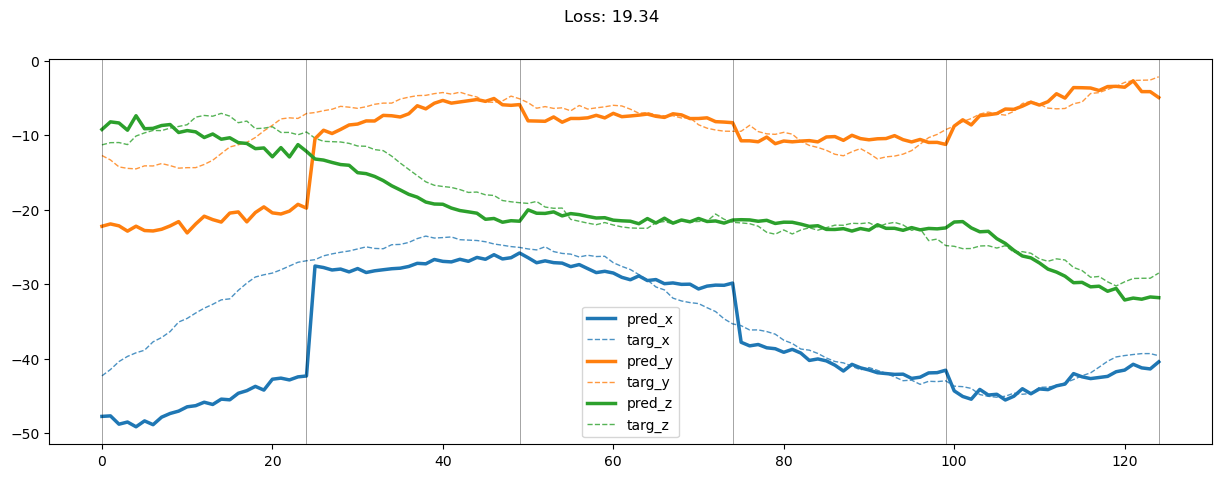

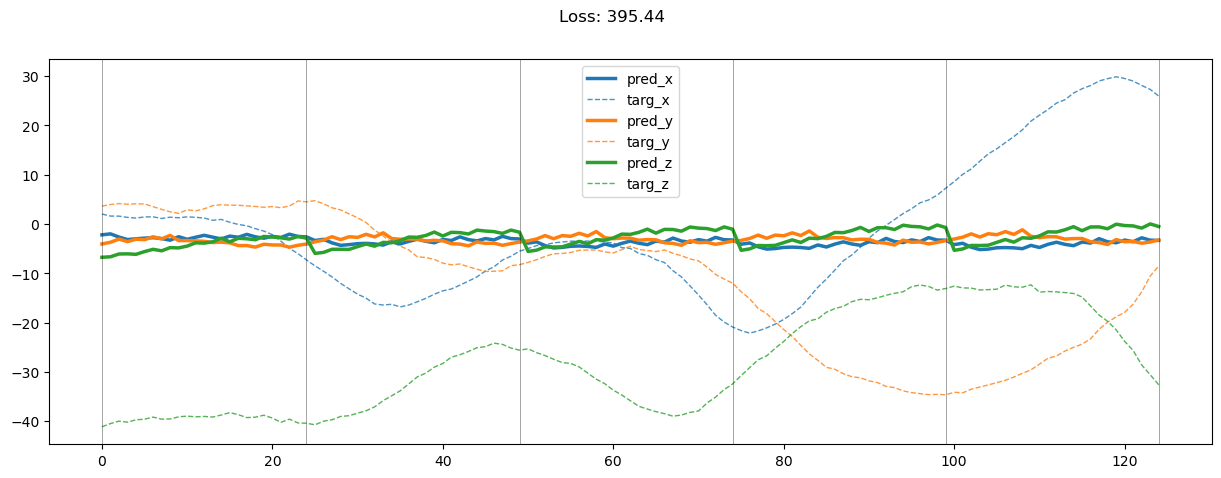

00099: train total loss:  17.052, pred loss:  17.052, valid total loss:  556.814, pred loss:  556.814


100%|██████████| 8/8 [00:00<00:00, 17.49it/s]


00100: train total loss:  19.492, pred loss:  19.492, valid total loss:  592.538, pred loss:  592.538


100%|██████████| 8/8 [00:00<00:00, 17.43it/s]


00101: train total loss:  18.905, pred loss:  18.905, valid total loss:  571.343, pred loss:  571.343


100%|██████████| 8/8 [00:00<00:00, 22.02it/s]


00102: train total loss:  17.367, pred loss:  17.367, valid total loss:  572.148, pred loss:  572.148


100%|██████████| 8/8 [00:00<00:00, 22.09it/s]


00103: train total loss:  16.362, pred loss:  16.362, valid total loss:  560.383, pred loss:  560.383


100%|██████████| 8/8 [00:00<00:00, 21.66it/s]


00104: train total loss:  16.040, pred loss:  16.040, valid total loss:  596.894, pred loss:  596.894


100%|██████████| 8/8 [00:00<00:00, 21.89it/s]


00105: train total loss:  17.399, pred loss:  17.399, valid total loss:  570.353, pred loss:  570.353


100%|██████████| 8/8 [00:00<00:00, 22.22it/s]


00106: train total loss:  17.514, pred loss:  17.514, valid total loss:  587.975, pred loss:  587.975


100%|██████████| 8/8 [00:00<00:00, 21.91it/s]


00107: train total loss:  16.312, pred loss:  16.312, valid total loss:  583.196, pred loss:  583.196


100%|██████████| 8/8 [00:00<00:00, 22.23it/s]


00108: train total loss:  16.502, pred loss:  16.502, valid total loss:  610.487, pred loss:  610.487


100%|██████████| 8/8 [00:00<00:00, 21.96it/s]


00109: train total loss:  16.210, pred loss:  16.210, valid total loss:  618.141, pred loss:  618.141


100%|██████████| 8/8 [00:00<00:00, 19.12it/s]


00110: train total loss:  14.989, pred loss:  14.989, valid total loss:  562.635, pred loss:  562.635


100%|██████████| 8/8 [00:00<00:00, 19.61it/s]


00111: train total loss:  15.906, pred loss:  15.906, valid total loss:  611.977, pred loss:  611.977


100%|██████████| 8/8 [00:00<00:00, 19.39it/s]


00112: train total loss:  15.247, pred loss:  15.247, valid total loss:  588.097, pred loss:  588.097


100%|██████████| 8/8 [00:00<00:00, 19.40it/s]


00113: train total loss:  14.928, pred loss:  14.928, valid total loss:  589.054, pred loss:  589.054


100%|██████████| 8/8 [00:00<00:00, 21.68it/s]


00114: train total loss:  14.791, pred loss:  14.791, valid total loss:  585.996, pred loss:  585.996


100%|██████████| 8/8 [00:00<00:00, 18.66it/s]


00115: train total loss:  13.514, pred loss:  13.514, valid total loss:  588.531, pred loss:  588.531


100%|██████████| 8/8 [00:00<00:00, 17.08it/s]


00116: train total loss:  13.933, pred loss:  13.933, valid total loss:  574.525, pred loss:  574.525


100%|██████████| 8/8 [00:00<00:00, 20.12it/s]


00117: train total loss:  13.380, pred loss:  13.380, valid total loss:  590.263, pred loss:  590.263


100%|██████████| 8/8 [00:00<00:00, 20.04it/s]


00118: train total loss:  13.756, pred loss:  13.756, valid total loss:  561.619, pred loss:  561.619


100%|██████████| 8/8 [00:00<00:00, 19.41it/s]


00119: train total loss:  13.095, pred loss:  13.095, valid total loss:  603.215, pred loss:  603.215


100%|██████████| 8/8 [00:00<00:00, 19.63it/s]


00120: train total loss:  12.619, pred loss:  12.619, valid total loss:  562.211, pred loss:  562.211


100%|██████████| 8/8 [00:00<00:00, 19.62it/s]


00121: train total loss:  12.903, pred loss:  12.903, valid total loss:  606.376, pred loss:  606.376


100%|██████████| 8/8 [00:00<00:00, 19.29it/s]


00122: train total loss:  13.652, pred loss:  13.652, valid total loss:  578.916, pred loss:  578.916


100%|██████████| 8/8 [00:00<00:00, 20.38it/s]


00123: train total loss:  13.648, pred loss:  13.648, valid total loss:  606.573, pred loss:  606.573


100%|██████████| 8/8 [00:00<00:00, 22.11it/s]


00124: train total loss:  12.480, pred loss:  12.480, valid total loss:  576.675, pred loss:  576.675


100%|██████████| 8/8 [00:00<00:00, 21.95it/s]


00125: train total loss:  14.619, pred loss:  14.619, valid total loss:  571.925, pred loss:  571.925


100%|██████████| 8/8 [00:00<00:00, 22.35it/s]


00126: train total loss:  16.112, pred loss:  16.112, valid total loss:  534.912, pred loss:  534.912


100%|██████████| 8/8 [00:00<00:00, 22.11it/s]


00127: train total loss:  17.789, pred loss:  17.789, valid total loss:  599.056, pred loss:  599.056


100%|██████████| 8/8 [00:00<00:00, 22.16it/s]


00128: train total loss:  14.735, pred loss:  14.735, valid total loss:  623.835, pred loss:  623.835


100%|██████████| 8/8 [00:00<00:00, 21.97it/s]


00129: train total loss:  14.441, pred loss:  14.441, valid total loss:  615.720, pred loss:  615.720


100%|██████████| 8/8 [00:00<00:00, 22.15it/s]


00130: train total loss:  13.088, pred loss:  13.088, valid total loss:  586.687, pred loss:  586.687


100%|██████████| 8/8 [00:00<00:00, 22.10it/s]


00131: train total loss:  12.638, pred loss:  12.638, valid total loss:  574.483, pred loss:  574.483


100%|██████████| 8/8 [00:00<00:00, 22.15it/s]


00132: train total loss:  11.216, pred loss:  11.216, valid total loss:  595.302, pred loss:  595.302


100%|██████████| 8/8 [00:00<00:00, 21.94it/s]


00133: train total loss:  11.564, pred loss:  11.564, valid total loss:  598.176, pred loss:  598.176


100%|██████████| 8/8 [00:00<00:00, 22.20it/s]


00134: train total loss:  12.323, pred loss:  12.323, valid total loss:  601.400, pred loss:  601.400


100%|██████████| 8/8 [00:00<00:00, 22.06it/s]


00135: train total loss:  11.906, pred loss:  11.906, valid total loss:  603.231, pred loss:  603.231


100%|██████████| 8/8 [00:00<00:00, 22.16it/s]


00136: train total loss:  12.090, pred loss:  12.090, valid total loss:  575.043, pred loss:  575.043


100%|██████████| 8/8 [00:00<00:00, 22.23it/s]


00137: train total loss:  13.060, pred loss:  13.060, valid total loss:  595.005, pred loss:  595.005


100%|██████████| 8/8 [00:00<00:00, 22.26it/s]


00138: train total loss:  10.860, pred loss:  10.860, valid total loss:  587.573, pred loss:  587.573


100%|██████████| 8/8 [00:00<00:00, 22.28it/s]


00139: train total loss:  11.239, pred loss:  11.239, valid total loss:  587.107, pred loss:  587.107


100%|██████████| 8/8 [00:00<00:00, 20.58it/s]


00140: train total loss:  11.191, pred loss:  11.191, valid total loss:  590.448, pred loss:  590.448


100%|██████████| 8/8 [00:00<00:00, 19.64it/s]


00141: train total loss:  11.022, pred loss:  11.022, valid total loss:  572.409, pred loss:  572.409


100%|██████████| 8/8 [00:00<00:00, 22.36it/s]


00142: train total loss:  11.897, pred loss:  11.897, valid total loss:  580.104, pred loss:  580.104


100%|██████████| 8/8 [00:00<00:00, 22.26it/s]


00143: train total loss:  10.736, pred loss:  10.736, valid total loss:  590.624, pred loss:  590.624


100%|██████████| 8/8 [00:00<00:00, 22.30it/s]


00144: train total loss:  10.798, pred loss:  10.798, valid total loss:  603.248, pred loss:  603.248


100%|██████████| 8/8 [00:00<00:00, 22.11it/s]


00145: train total loss:  10.596, pred loss:  10.596, valid total loss:  578.105, pred loss:  578.105


100%|██████████| 8/8 [00:00<00:00, 20.52it/s]


00146: train total loss:  10.494, pred loss:  10.494, valid total loss:  591.837, pred loss:  591.837


100%|██████████| 8/8 [00:00<00:00, 19.58it/s]


00147: train total loss:  11.902, pred loss:  11.902, valid total loss:  586.815, pred loss:  586.815


100%|██████████| 8/8 [00:00<00:00, 19.47it/s]


00148: train total loss:  11.068, pred loss:  11.068, valid total loss:  592.792, pred loss:  592.792


100%|██████████| 8/8 [00:00<00:00, 19.97it/s]


00149: train total loss:  11.129, pred loss:  11.129, valid total loss:  588.078, pred loss:  588.078


100%|██████████| 8/8 [00:00<00:00, 22.18it/s]


00150: train total loss:  10.755, pred loss:  10.755, valid total loss:  584.375, pred loss:  584.375


100%|██████████| 8/8 [00:00<00:00, 19.64it/s]


00151: train total loss:  10.546, pred loss:  10.546, valid total loss:  616.734, pred loss:  616.734


100%|██████████| 8/8 [00:00<00:00, 19.85it/s]


00152: train total loss:  10.923, pred loss:  10.923, valid total loss:  595.054, pred loss:  595.054


100%|██████████| 8/8 [00:00<00:00, 20.05it/s]


00153: train total loss:  11.136, pred loss:  11.136, valid total loss:  562.847, pred loss:  562.847


100%|██████████| 8/8 [00:00<00:00, 20.18it/s]


00154: train total loss:  13.104, pred loss:  13.104, valid total loss:  594.715, pred loss:  594.715


100%|██████████| 8/8 [00:00<00:00, 20.38it/s]


00155: train total loss:  11.051, pred loss:  11.051, valid total loss:  610.391, pred loss:  610.391


100%|██████████| 8/8 [00:00<00:00, 20.23it/s]


00156: train total loss:  11.024, pred loss:  11.024, valid total loss:  609.875, pred loss:  609.875


100%|██████████| 8/8 [00:00<00:00, 20.25it/s]


00157: train total loss:  12.535, pred loss:  12.535, valid total loss:  598.542, pred loss:  598.542


100%|██████████| 8/8 [00:00<00:00, 20.17it/s]


00158: train total loss:  11.593, pred loss:  11.593, valid total loss:  578.716, pred loss:  578.716


100%|██████████| 8/8 [00:00<00:00, 20.12it/s]


00159: train total loss:  11.093, pred loss:  11.093, valid total loss:  626.903, pred loss:  626.903


100%|██████████| 8/8 [00:00<00:00, 20.19it/s]


00160: train total loss:  10.786, pred loss:  10.786, valid total loss:  583.715, pred loss:  583.715


100%|██████████| 8/8 [00:00<00:00, 22.18it/s]


00161: train total loss:  10.691, pred loss:  10.691, valid total loss:  633.006, pred loss:  633.006


100%|██████████| 8/8 [00:00<00:00, 17.81it/s]


00162: train total loss:  9.584, pred loss:  9.584, valid total loss:  618.864, pred loss:  618.864


100%|██████████| 8/8 [00:00<00:00, 19.91it/s]


00163: train total loss:  9.281, pred loss:  9.281, valid total loss:  590.481, pred loss:  590.481


100%|██████████| 8/8 [00:00<00:00, 19.53it/s]


00164: train total loss:  9.298, pred loss:  9.298, valid total loss:  586.349, pred loss:  586.349


100%|██████████| 8/8 [00:00<00:00, 19.62it/s]


00165: train total loss:  9.655, pred loss:  9.655, valid total loss:  590.485, pred loss:  590.485


100%|██████████| 8/8 [00:00<00:00, 19.41it/s]


00166: train total loss:  9.616, pred loss:  9.616, valid total loss:  579.673, pred loss:  579.673


100%|██████████| 8/8 [00:00<00:00, 19.45it/s]


00167: train total loss:  10.898, pred loss:  10.898, valid total loss:  601.234, pred loss:  601.234


100%|██████████| 8/8 [00:00<00:00, 19.97it/s]


00168: train total loss:  10.557, pred loss:  10.557, valid total loss:  603.200, pred loss:  603.200


100%|██████████| 8/8 [00:00<00:00, 20.18it/s]


00169: train total loss:  9.740, pred loss:  9.740, valid total loss:  594.965, pred loss:  594.965


100%|██████████| 8/8 [00:00<00:00, 19.73it/s]


00170: train total loss:  9.378, pred loss:  9.378, valid total loss:  610.290, pred loss:  610.290


100%|██████████| 8/8 [00:00<00:00, 19.55it/s]


00171: train total loss:  9.365, pred loss:  9.365, valid total loss:  600.826, pred loss:  600.826


100%|██████████| 8/8 [00:00<00:00, 20.34it/s]


00172: train total loss:  8.574, pred loss:  8.574, valid total loss:  589.227, pred loss:  589.227


100%|██████████| 8/8 [00:00<00:00, 20.84it/s]


00173: train total loss:  8.600, pred loss:  8.600, valid total loss:  607.651, pred loss:  607.651


100%|██████████| 8/8 [00:00<00:00, 20.91it/s]


00174: train total loss:  9.172, pred loss:  9.172, valid total loss:  626.009, pred loss:  626.009


100%|██████████| 8/8 [00:00<00:00, 20.78it/s]


00175: train total loss:  10.032, pred loss:  10.032, valid total loss:  605.113, pred loss:  605.113


100%|██████████| 8/8 [00:00<00:00, 19.85it/s]


00176: train total loss:  9.336, pred loss:  9.336, valid total loss:  599.947, pred loss:  599.947


100%|██████████| 8/8 [00:00<00:00, 20.59it/s]


00177: train total loss:  9.349, pred loss:  9.349, valid total loss:  616.978, pred loss:  616.978


100%|██████████| 8/8 [00:00<00:00, 19.79it/s]


00178: train total loss:  8.844, pred loss:  8.844, valid total loss:  582.694, pred loss:  582.694


100%|██████████| 8/8 [00:00<00:00, 20.57it/s]


00179: train total loss:  8.673, pred loss:  8.673, valid total loss:  608.953, pred loss:  608.953


100%|██████████| 8/8 [00:00<00:00, 20.06it/s]


00180: train total loss:  8.066, pred loss:  8.066, valid total loss:  610.634, pred loss:  610.634


100%|██████████| 8/8 [00:00<00:00, 18.98it/s]


00181: train total loss:  8.199, pred loss:  8.199, valid total loss:  605.624, pred loss:  605.624


100%|██████████| 8/8 [00:00<00:00, 19.76it/s]


00182: train total loss:  11.193, pred loss:  11.193, valid total loss:  612.426, pred loss:  612.426


100%|██████████| 8/8 [00:00<00:00, 20.22it/s]


00183: train total loss:  13.594, pred loss:  13.594, valid total loss:  579.405, pred loss:  579.405


100%|██████████| 8/8 [00:00<00:00, 19.80it/s]


00184: train total loss:  15.102, pred loss:  15.102, valid total loss:  579.770, pred loss:  579.770


100%|██████████| 8/8 [00:00<00:00, 18.79it/s]


00185: train total loss:  14.409, pred loss:  14.409, valid total loss:  606.769, pred loss:  606.769


100%|██████████| 8/8 [00:00<00:00, 20.00it/s]


00186: train total loss:  11.721, pred loss:  11.721, valid total loss:  584.236, pred loss:  584.236


100%|██████████| 8/8 [00:00<00:00, 17.47it/s]


00187: train total loss:  10.574, pred loss:  10.574, valid total loss:  602.595, pred loss:  602.595


100%|██████████| 8/8 [00:00<00:00, 22.43it/s]


00188: train total loss:  10.105, pred loss:  10.105, valid total loss:  589.160, pred loss:  589.160


100%|██████████| 8/8 [00:00<00:00, 22.27it/s]


00189: train total loss:  9.356, pred loss:  9.356, valid total loss:  587.679, pred loss:  587.679


100%|██████████| 8/8 [00:00<00:00, 22.42it/s]


00190: train total loss:  9.037, pred loss:  9.037, valid total loss:  581.255, pred loss:  581.255


100%|██████████| 8/8 [00:00<00:00, 22.45it/s]


00191: train total loss:  8.850, pred loss:  8.850, valid total loss:  609.925, pred loss:  609.925


100%|██████████| 8/8 [00:00<00:00, 22.43it/s]


00192: train total loss:  8.511, pred loss:  8.511, valid total loss:  649.248, pred loss:  649.248


100%|██████████| 8/8 [00:00<00:00, 22.31it/s]


00193: train total loss:  8.412, pred loss:  8.412, valid total loss:  617.792, pred loss:  617.792


100%|██████████| 8/8 [00:00<00:00, 22.40it/s]


00194: train total loss:  8.429, pred loss:  8.429, valid total loss:  610.024, pred loss:  610.024


100%|██████████| 8/8 [00:00<00:00, 22.43it/s]


00195: train total loss:  8.701, pred loss:  8.701, valid total loss:  608.360, pred loss:  608.360


100%|██████████| 8/8 [00:00<00:00, 22.42it/s]


00196: train total loss:  9.662, pred loss:  9.662, valid total loss:  629.697, pred loss:  629.697


100%|██████████| 8/8 [00:00<00:00, 22.41it/s]


00197: train total loss:  8.796, pred loss:  8.796, valid total loss:  599.161, pred loss:  599.161


100%|██████████| 8/8 [00:00<00:00, 19.99it/s]


00198: train total loss:  9.939, pred loss:  9.939, valid total loss:  628.379, pred loss:  628.379


100%|██████████| 8/8 [00:00<00:00, 20.23it/s]


00199: train total loss:  8.947, pred loss:  8.947, valid total loss:  610.989, pred loss:  610.989


100%|██████████| 8/8 [00:00<00:00, 18.41it/s]


00200: train total loss:  8.324, pred loss:  8.324, valid total loss:  642.365, pred loss:  642.365


100%|██████████| 8/8 [00:00<00:00, 20.74it/s]


00201: train total loss:  8.517, pred loss:  8.517, valid total loss:  614.799, pred loss:  614.799


100%|██████████| 8/8 [00:00<00:00, 20.86it/s]


00202: train total loss:  7.317, pred loss:  7.317, valid total loss:  618.282, pred loss:  618.282


100%|██████████| 8/8 [00:00<00:00, 19.96it/s]


00203: train total loss:  7.076, pred loss:  7.076, valid total loss:  634.680, pred loss:  634.680


100%|██████████| 8/8 [00:00<00:00, 19.88it/s]


00204: train total loss:  7.731, pred loss:  7.731, valid total loss:  650.666, pred loss:  650.666


100%|██████████| 8/8 [00:00<00:00, 22.37it/s]


00205: train total loss:  7.401, pred loss:  7.401, valid total loss:  643.694, pred loss:  643.694


100%|██████████| 8/8 [00:00<00:00, 22.38it/s]


00206: train total loss:  8.160, pred loss:  8.160, valid total loss:  638.659, pred loss:  638.659


100%|██████████| 8/8 [00:00<00:00, 22.42it/s]


00207: train total loss:  8.190, pred loss:  8.190, valid total loss:  617.732, pred loss:  617.732


100%|██████████| 8/8 [00:00<00:00, 22.24it/s]


00208: train total loss:  7.555, pred loss:  7.555, valid total loss:  655.246, pred loss:  655.246


100%|██████████| 8/8 [00:00<00:00, 22.38it/s]


00209: train total loss:  8.151, pred loss:  8.151, valid total loss:  640.257, pred loss:  640.257


100%|██████████| 8/8 [00:00<00:00, 22.37it/s]


00210: train total loss:  7.908, pred loss:  7.908, valid total loss:  612.020, pred loss:  612.020


100%|██████████| 8/8 [00:00<00:00, 22.39it/s]


00211: train total loss:  7.286, pred loss:  7.286, valid total loss:  592.541, pred loss:  592.541


100%|██████████| 8/8 [00:00<00:00, 22.38it/s]


00212: train total loss:  7.348, pred loss:  7.348, valid total loss:  616.915, pred loss:  616.915


100%|██████████| 8/8 [00:00<00:00, 22.35it/s]


00213: train total loss:  6.909, pred loss:  6.909, valid total loss:  614.624, pred loss:  614.624


100%|██████████| 8/8 [00:00<00:00, 22.38it/s]


00214: train total loss:  7.619, pred loss:  7.619, valid total loss:  605.978, pred loss:  605.978


100%|██████████| 8/8 [00:00<00:00, 22.38it/s]


00215: train total loss:  7.519, pred loss:  7.519, valid total loss:  600.505, pred loss:  600.505


100%|██████████| 8/8 [00:00<00:00, 22.40it/s]


00216: train total loss:  8.422, pred loss:  8.422, valid total loss:  597.687, pred loss:  597.687


100%|██████████| 8/8 [00:00<00:00, 17.40it/s]


00217: train total loss:  7.783, pred loss:  7.783, valid total loss:  602.807, pred loss:  602.807


100%|██████████| 8/8 [00:00<00:00, 19.58it/s]


00218: train total loss:  7.368, pred loss:  7.368, valid total loss:  614.658, pred loss:  614.658


100%|██████████| 8/8 [00:00<00:00, 19.95it/s]


00219: train total loss:  6.842, pred loss:  6.842, valid total loss:  613.132, pred loss:  613.132


100%|██████████| 8/8 [00:00<00:00, 19.26it/s]


00220: train total loss:  7.501, pred loss:  7.501, valid total loss:  647.716, pred loss:  647.716


100%|██████████| 8/8 [00:00<00:00, 19.95it/s]


00221: train total loss:  7.147, pred loss:  7.147, valid total loss:  609.125, pred loss:  609.125


100%|██████████| 8/8 [00:00<00:00, 22.45it/s]


00222: train total loss:  7.072, pred loss:  7.072, valid total loss:  629.672, pred loss:  629.672


100%|██████████| 8/8 [00:00<00:00, 22.45it/s]


00223: train total loss:  8.117, pred loss:  8.117, valid total loss:  593.500, pred loss:  593.500


100%|██████████| 8/8 [00:00<00:00, 22.31it/s]


00224: train total loss:  8.152, pred loss:  8.152, valid total loss:  591.996, pred loss:  591.996


100%|██████████| 8/8 [00:00<00:00, 22.44it/s]


00225: train total loss:  7.560, pred loss:  7.560, valid total loss:  602.676, pred loss:  602.676


100%|██████████| 8/8 [00:00<00:00, 22.41it/s]


00226: train total loss:  7.447, pred loss:  7.447, valid total loss:  630.584, pred loss:  630.584


100%|██████████| 8/8 [00:00<00:00, 22.40it/s]


00227: train total loss:  6.823, pred loss:  6.823, valid total loss:  608.043, pred loss:  608.043


100%|██████████| 8/8 [00:00<00:00, 22.05it/s]


00228: train total loss:  8.409, pred loss:  8.409, valid total loss:  599.303, pred loss:  599.303


100%|██████████| 8/8 [00:00<00:00, 18.47it/s]


00229: train total loss:  7.092, pred loss:  7.092, valid total loss:  619.410, pred loss:  619.410


100%|██████████| 8/8 [00:00<00:00, 18.94it/s]


00230: train total loss:  7.432, pred loss:  7.432, valid total loss:  588.576, pred loss:  588.576


100%|██████████| 8/8 [00:00<00:00, 17.98it/s]


00231: train total loss:  7.170, pred loss:  7.170, valid total loss:  597.961, pred loss:  597.961


100%|██████████| 8/8 [00:00<00:00, 17.51it/s]


00232: train total loss:  7.393, pred loss:  7.393, valid total loss:  604.300, pred loss:  604.300


100%|██████████| 8/8 [00:00<00:00, 19.81it/s]


00233: train total loss:  7.242, pred loss:  7.242, valid total loss:  605.536, pred loss:  605.536


100%|██████████| 8/8 [00:00<00:00, 22.39it/s]


00234: train total loss:  6.653, pred loss:  6.653, valid total loss:  606.041, pred loss:  606.041


100%|██████████| 8/8 [00:00<00:00, 21.98it/s]


00235: train total loss:  6.596, pred loss:  6.596, valid total loss:  603.297, pred loss:  603.297


100%|██████████| 8/8 [00:00<00:00, 22.44it/s]


00236: train total loss:  6.485, pred loss:  6.485, valid total loss:  636.349, pred loss:  636.349


100%|██████████| 8/8 [00:00<00:00, 19.70it/s]


00237: train total loss:  6.859, pred loss:  6.859, valid total loss:  619.288, pred loss:  619.288


100%|██████████| 8/8 [00:00<00:00, 17.69it/s]


00238: train total loss:  6.544, pred loss:  6.544, valid total loss:  641.206, pred loss:  641.206


100%|██████████| 8/8 [00:00<00:00, 19.83it/s]


00239: train total loss:  7.666, pred loss:  7.666, valid total loss:  614.516, pred loss:  614.516


100%|██████████| 8/8 [00:00<00:00, 20.33it/s]


00240: train total loss:  6.608, pred loss:  6.608, valid total loss:  631.918, pred loss:  631.918


100%|██████████| 8/8 [00:00<00:00, 20.43it/s]


00241: train total loss:  7.070, pred loss:  7.070, valid total loss:  627.079, pred loss:  627.079


100%|██████████| 8/8 [00:00<00:00, 19.81it/s]


00242: train total loss:  6.977, pred loss:  6.977, valid total loss:  627.620, pred loss:  627.620


100%|██████████| 8/8 [00:00<00:00, 19.37it/s]


00243: train total loss:  8.251, pred loss:  8.251, valid total loss:  620.975, pred loss:  620.975


100%|██████████| 8/8 [00:00<00:00, 19.59it/s]


00244: train total loss:  8.590, pred loss:  8.590, valid total loss:  625.335, pred loss:  625.335


100%|██████████| 8/8 [00:00<00:00, 19.96it/s]


00245: train total loss:  7.298, pred loss:  7.298, valid total loss:  606.621, pred loss:  606.621


100%|██████████| 8/8 [00:00<00:00, 20.13it/s]


00246: train total loss:  7.239, pred loss:  7.239, valid total loss:  618.566, pred loss:  618.566


100%|██████████| 8/8 [00:00<00:00, 20.38it/s]


00247: train total loss:  6.579, pred loss:  6.579, valid total loss:  599.098, pred loss:  599.098


100%|██████████| 8/8 [00:00<00:00, 20.36it/s]


00248: train total loss:  6.745, pred loss:  6.745, valid total loss:  649.469, pred loss:  649.469


100%|██████████| 8/8 [00:00<00:00, 19.87it/s]


00249: train total loss:  6.239, pred loss:  6.239, valid total loss:  630.724, pred loss:  630.724


100%|██████████| 8/8 [00:00<00:00, 18.07it/s]


00250: train total loss:  6.298, pred loss:  6.298, valid total loss:  629.248, pred loss:  629.248


100%|██████████| 8/8 [00:00<00:00, 20.42it/s]


00251: train total loss:  6.202, pred loss:  6.202, valid total loss:  645.140, pred loss:  645.140


100%|██████████| 8/8 [00:00<00:00, 20.54it/s]


00252: train total loss:  5.785, pred loss:  5.785, valid total loss:  616.674, pred loss:  616.674


100%|██████████| 8/8 [00:00<00:00, 19.70it/s]


00253: train total loss:  6.601, pred loss:  6.601, valid total loss:  629.077, pred loss:  629.077


100%|██████████| 8/8 [00:00<00:00, 19.89it/s]


00254: train total loss:  6.416, pred loss:  6.416, valid total loss:  632.878, pred loss:  632.878


100%|██████████| 8/8 [00:00<00:00, 19.90it/s]


00255: train total loss:  6.122, pred loss:  6.122, valid total loss:  625.721, pred loss:  625.721


100%|██████████| 8/8 [00:00<00:00, 20.35it/s]


00256: train total loss:  7.392, pred loss:  7.392, valid total loss:  653.118, pred loss:  653.118


100%|██████████| 8/8 [00:00<00:00, 20.25it/s]


00257: train total loss:  8.700, pred loss:  8.700, valid total loss:  622.869, pred loss:  622.869


100%|██████████| 8/8 [00:00<00:00, 20.48it/s]


00258: train total loss:  8.117, pred loss:  8.117, valid total loss:  660.787, pred loss:  660.787


100%|██████████| 8/8 [00:00<00:00, 20.75it/s]


00259: train total loss:  7.342, pred loss:  7.342, valid total loss:  625.862, pred loss:  625.862


100%|██████████| 8/8 [00:00<00:00, 20.35it/s]


00260: train total loss:  7.762, pred loss:  7.762, valid total loss:  588.865, pred loss:  588.865


100%|██████████| 8/8 [00:00<00:00, 19.70it/s]


00261: train total loss:  7.117, pred loss:  7.117, valid total loss:  616.505, pred loss:  616.505


100%|██████████| 8/8 [00:00<00:00, 20.70it/s]


00262: train total loss:  6.753, pred loss:  6.753, valid total loss:  630.252, pred loss:  630.252


100%|██████████| 8/8 [00:00<00:00, 20.42it/s]


00263: train total loss:  7.136, pred loss:  7.136, valid total loss:  615.523, pred loss:  615.523


100%|██████████| 8/8 [00:00<00:00, 21.07it/s]


00264: train total loss:  6.117, pred loss:  6.117, valid total loss:  611.170, pred loss:  611.170


100%|██████████| 8/8 [00:00<00:00, 21.01it/s]


00265: train total loss:  6.267, pred loss:  6.267, valid total loss:  625.954, pred loss:  625.954


100%|██████████| 8/8 [00:00<00:00, 20.86it/s]


00266: train total loss:  5.634, pred loss:  5.634, valid total loss:  623.024, pred loss:  623.024


100%|██████████| 8/8 [00:00<00:00, 21.49it/s]


00267: train total loss:  5.860, pred loss:  5.860, valid total loss:  614.997, pred loss:  614.997


100%|██████████| 8/8 [00:00<00:00, 21.28it/s]


00268: train total loss:  5.967, pred loss:  5.967, valid total loss:  589.991, pred loss:  589.991


100%|██████████| 8/8 [00:00<00:00, 20.79it/s]


00269: train total loss:  7.499, pred loss:  7.499, valid total loss:  592.219, pred loss:  592.219


100%|██████████| 8/8 [00:00<00:00, 21.20it/s]


00270: train total loss:  7.118, pred loss:  7.118, valid total loss:  615.841, pred loss:  615.841


100%|██████████| 8/8 [00:00<00:00, 20.66it/s]


00271: train total loss:  7.297, pred loss:  7.297, valid total loss:  584.981, pred loss:  584.981


100%|██████████| 8/8 [00:00<00:00, 20.72it/s]


00272: train total loss:  7.930, pred loss:  7.930, valid total loss:  621.089, pred loss:  621.089


100%|██████████| 8/8 [00:00<00:00, 20.94it/s]


00273: train total loss:  8.360, pred loss:  8.360, valid total loss:  630.458, pred loss:  630.458


100%|██████████| 8/8 [00:00<00:00, 21.01it/s]


00274: train total loss:  7.119, pred loss:  7.119, valid total loss:  615.756, pred loss:  615.756


100%|██████████| 8/8 [00:00<00:00, 19.99it/s]


00275: train total loss:  6.973, pred loss:  6.973, valid total loss:  621.378, pred loss:  621.378


100%|██████████| 8/8 [00:00<00:00, 19.60it/s]


00276: train total loss:  6.622, pred loss:  6.622, valid total loss:  587.151, pred loss:  587.151


100%|██████████| 8/8 [00:00<00:00, 20.66it/s]


00277: train total loss:  8.567, pred loss:  8.567, valid total loss:  619.679, pred loss:  619.679


100%|██████████| 8/8 [00:00<00:00, 20.01it/s]


00278: train total loss:  9.057, pred loss:  9.057, valid total loss:  610.244, pred loss:  610.244


100%|██████████| 8/8 [00:00<00:00, 20.72it/s]


00279: train total loss:  7.727, pred loss:  7.727, valid total loss:  591.515, pred loss:  591.515


100%|██████████| 8/8 [00:00<00:00, 20.57it/s]


00280: train total loss:  7.380, pred loss:  7.380, valid total loss:  597.897, pred loss:  597.897


100%|██████████| 8/8 [00:00<00:00, 20.91it/s]


00281: train total loss:  7.190, pred loss:  7.190, valid total loss:  616.842, pred loss:  616.842


100%|██████████| 8/8 [00:00<00:00, 19.86it/s]


00282: train total loss:  6.091, pred loss:  6.091, valid total loss:  595.644, pred loss:  595.644


100%|██████████| 8/8 [00:00<00:00, 20.50it/s]


00283: train total loss:  6.092, pred loss:  6.092, valid total loss:  608.656, pred loss:  608.656


100%|██████████| 8/8 [00:00<00:00, 19.76it/s]


00284: train total loss:  5.597, pred loss:  5.597, valid total loss:  600.896, pred loss:  600.896


100%|██████████| 8/8 [00:00<00:00, 20.48it/s]


00285: train total loss:  5.393, pred loss:  5.393, valid total loss:  593.900, pred loss:  593.900


100%|██████████| 8/8 [00:00<00:00, 20.98it/s]


00286: train total loss:  5.351, pred loss:  5.351, valid total loss:  616.495, pred loss:  616.495


100%|██████████| 8/8 [00:00<00:00, 20.67it/s]


00287: train total loss:  5.291, pred loss:  5.291, valid total loss:  591.798, pred loss:  591.798


100%|██████████| 8/8 [00:00<00:00, 20.29it/s]


00288: train total loss:  5.375, pred loss:  5.375, valid total loss:  604.119, pred loss:  604.119


100%|██████████| 8/8 [00:00<00:00, 21.06it/s]


00289: train total loss:  5.349, pred loss:  5.349, valid total loss:  596.912, pred loss:  596.912


100%|██████████| 8/8 [00:00<00:00, 20.97it/s]


00290: train total loss:  5.542, pred loss:  5.542, valid total loss:  615.653, pred loss:  615.653


100%|██████████| 8/8 [00:00<00:00, 22.04it/s]


00291: train total loss:  5.828, pred loss:  5.828, valid total loss:  617.692, pred loss:  617.692


100%|██████████| 8/8 [00:00<00:00, 22.31it/s]


00292: train total loss:  5.737, pred loss:  5.737, valid total loss:  625.030, pred loss:  625.030


100%|██████████| 8/8 [00:00<00:00, 22.33it/s]


00293: train total loss:  5.322, pred loss:  5.322, valid total loss:  606.224, pred loss:  606.224


100%|██████████| 8/8 [00:00<00:00, 22.29it/s]


00294: train total loss:  5.189, pred loss:  5.189, valid total loss:  634.201, pred loss:  634.201


100%|██████████| 8/8 [00:00<00:00, 19.38it/s]


00295: train total loss:  5.079, pred loss:  5.079, valid total loss:  621.945, pred loss:  621.945


100%|██████████| 8/8 [00:00<00:00, 19.62it/s]


00296: train total loss:  5.219, pred loss:  5.219, valid total loss:  630.986, pred loss:  630.986


100%|██████████| 8/8 [00:00<00:00, 19.81it/s]


00297: train total loss:  5.056, pred loss:  5.056, valid total loss:  612.206, pred loss:  612.206


100%|██████████| 8/8 [00:00<00:00, 19.85it/s]


00298: train total loss:  4.990, pred loss:  4.990, valid total loss:  620.256, pred loss:  620.256


100%|██████████| 8/8 [00:00<00:00, 20.00it/s]


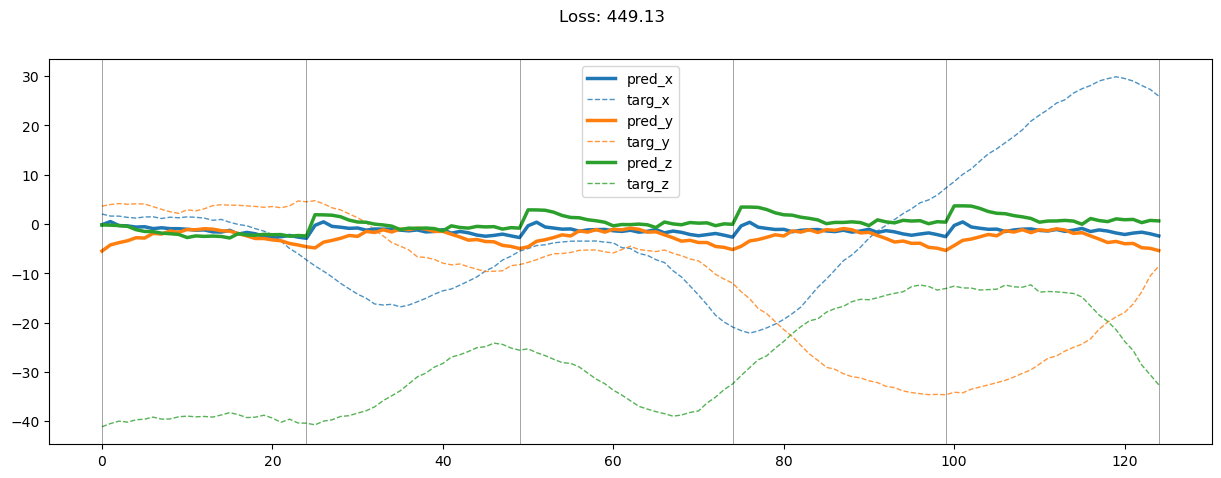

00299: train total loss:  6.175, pred loss:  6.175, valid total loss:  609.669, pred loss:  609.669


100%|██████████| 8/8 [00:00<00:00, 17.85it/s]


00300: train total loss:  6.007, pred loss:  6.007, valid total loss:  614.166, pred loss:  614.166


100%|██████████| 8/8 [00:00<00:00, 19.86it/s]


00301: train total loss:  5.588, pred loss:  5.588, valid total loss:  605.196, pred loss:  605.196


100%|██████████| 8/8 [00:00<00:00, 20.17it/s]


00302: train total loss:  6.145, pred loss:  6.145, valid total loss:  619.472, pred loss:  619.472


100%|██████████| 8/8 [00:00<00:00, 20.23it/s]


00303: train total loss:  5.950, pred loss:  5.950, valid total loss:  605.190, pred loss:  605.190


100%|██████████| 8/8 [00:00<00:00, 19.69it/s]


00304: train total loss:  5.734, pred loss:  5.734, valid total loss:  571.887, pred loss:  571.887


100%|██████████| 8/8 [00:00<00:00, 20.12it/s]


00305: train total loss:  5.696, pred loss:  5.696, valid total loss:  585.454, pred loss:  585.454


100%|██████████| 8/8 [00:00<00:00, 22.06it/s]


00306: train total loss:  6.141, pred loss:  6.141, valid total loss:  616.329, pred loss:  616.329


100%|██████████| 8/8 [00:00<00:00, 22.32it/s]


00307: train total loss:  5.908, pred loss:  5.908, valid total loss:  600.630, pred loss:  600.630


100%|██████████| 8/8 [00:00<00:00, 22.35it/s]


00308: train total loss:  5.904, pred loss:  5.904, valid total loss:  604.215, pred loss:  604.215


100%|██████████| 8/8 [00:00<00:00, 22.23it/s]


00309: train total loss:  5.426, pred loss:  5.426, valid total loss:  636.517, pred loss:  636.517


100%|██████████| 8/8 [00:00<00:00, 22.03it/s]


00310: train total loss:  6.165, pred loss:  6.165, valid total loss:  612.987, pred loss:  612.987


100%|██████████| 8/8 [00:00<00:00, 22.20it/s]


00311: train total loss:  5.280, pred loss:  5.280, valid total loss:  612.838, pred loss:  612.838


100%|██████████| 8/8 [00:00<00:00, 22.21it/s]


00312: train total loss:  5.210, pred loss:  5.210, valid total loss:  624.329, pred loss:  624.329


100%|██████████| 8/8 [00:00<00:00, 22.30it/s]


00313: train total loss:  5.315, pred loss:  5.315, valid total loss:  606.049, pred loss:  606.049


100%|██████████| 8/8 [00:00<00:00, 21.79it/s]


00314: train total loss:  6.136, pred loss:  6.136, valid total loss:  601.323, pred loss:  601.323


100%|██████████| 8/8 [00:00<00:00, 22.22it/s]


00315: train total loss:  6.282, pred loss:  6.282, valid total loss:  586.725, pred loss:  586.725


100%|██████████| 8/8 [00:00<00:00, 22.31it/s]


00316: train total loss:  5.692, pred loss:  5.692, valid total loss:  593.449, pred loss:  593.449


100%|██████████| 8/8 [00:00<00:00, 22.25it/s]


00317: train total loss:  5.894, pred loss:  5.894, valid total loss:  606.216, pred loss:  606.216


100%|██████████| 8/8 [00:00<00:00, 22.02it/s]


00318: train total loss:  5.790, pred loss:  5.790, valid total loss:  595.535, pred loss:  595.535


100%|██████████| 8/8 [00:00<00:00, 22.30it/s]


00319: train total loss:  5.478, pred loss:  5.478, valid total loss:  610.225, pred loss:  610.225


100%|██████████| 8/8 [00:00<00:00, 22.17it/s]


00320: train total loss:  5.223, pred loss:  5.223, valid total loss:  620.768, pred loss:  620.768


100%|██████████| 8/8 [00:00<00:00, 22.28it/s]


00321: train total loss:  4.871, pred loss:  4.871, valid total loss:  598.498, pred loss:  598.498


100%|██████████| 8/8 [00:00<00:00, 21.91it/s]


00322: train total loss:  5.459, pred loss:  5.459, valid total loss:  625.546, pred loss:  625.546


100%|██████████| 8/8 [00:00<00:00, 22.23it/s]


00323: train total loss:  5.323, pred loss:  5.323, valid total loss:  627.564, pred loss:  627.564


100%|██████████| 8/8 [00:00<00:00, 19.82it/s]


00324: train total loss:  5.342, pred loss:  5.342, valid total loss:  623.448, pred loss:  623.448


100%|██████████| 8/8 [00:00<00:00, 19.58it/s]


00325: train total loss:  4.709, pred loss:  4.709, valid total loss:  618.286, pred loss:  618.286


100%|██████████| 8/8 [00:00<00:00, 17.90it/s]


00326: train total loss:  5.252, pred loss:  5.252, valid total loss:  654.848, pred loss:  654.848


100%|██████████| 8/8 [00:00<00:00, 22.19it/s]


00327: train total loss:  5.463, pred loss:  5.463, valid total loss:  614.154, pred loss:  614.154


100%|██████████| 8/8 [00:00<00:00, 22.25it/s]


00328: train total loss:  5.475, pred loss:  5.475, valid total loss:  589.401, pred loss:  589.401


100%|██████████| 8/8 [00:00<00:00, 22.21it/s]


00329: train total loss:  5.056, pred loss:  5.056, valid total loss:  612.925, pred loss:  612.925


100%|██████████| 8/8 [00:00<00:00, 22.23it/s]


00330: train total loss:  5.044, pred loss:  5.044, valid total loss:  600.948, pred loss:  600.948


100%|██████████| 8/8 [00:00<00:00, 22.22it/s]


00331: train total loss:  4.908, pred loss:  4.908, valid total loss:  599.624, pred loss:  599.624


100%|██████████| 8/8 [00:00<00:00, 22.28it/s]


00332: train total loss:  5.230, pred loss:  5.230, valid total loss:  594.960, pred loss:  594.960


100%|██████████| 8/8 [00:00<00:00, 22.28it/s]


00333: train total loss:  5.371, pred loss:  5.371, valid total loss:  589.819, pred loss:  589.819


100%|██████████| 8/8 [00:00<00:00, 22.17it/s]


00334: train total loss:  5.008, pred loss:  5.008, valid total loss:  598.103, pred loss:  598.103


100%|██████████| 8/8 [00:00<00:00, 22.21it/s]


00335: train total loss:  4.784, pred loss:  4.784, valid total loss:  595.852, pred loss:  595.852


100%|██████████| 8/8 [00:00<00:00, 17.36it/s]


00336: train total loss:  4.508, pred loss:  4.508, valid total loss:  613.303, pred loss:  613.303


100%|██████████| 8/8 [00:00<00:00, 20.34it/s]


00337: train total loss:  4.873, pred loss:  4.873, valid total loss:  605.155, pred loss:  605.155


100%|██████████| 8/8 [00:00<00:00, 20.04it/s]


00338: train total loss:  4.944, pred loss:  4.944, valid total loss:  606.635, pred loss:  606.635


100%|██████████| 8/8 [00:00<00:00, 19.03it/s]


00339: train total loss:  6.000, pred loss:  6.000, valid total loss:  602.543, pred loss:  602.543


100%|██████████| 8/8 [00:00<00:00, 19.75it/s]


00340: train total loss:  6.436, pred loss:  6.436, valid total loss:  609.959, pred loss:  609.959


100%|██████████| 8/8 [00:00<00:00, 19.40it/s]


00341: train total loss:  5.691, pred loss:  5.691, valid total loss:  598.942, pred loss:  598.942


100%|██████████| 8/8 [00:00<00:00, 20.02it/s]


00342: train total loss:  5.328, pred loss:  5.328, valid total loss:  602.260, pred loss:  602.260


100%|██████████| 8/8 [00:00<00:00, 19.87it/s]


00343: train total loss:  4.743, pred loss:  4.743, valid total loss:  613.685, pred loss:  613.685


100%|██████████| 8/8 [00:00<00:00, 20.20it/s]


00344: train total loss:  4.910, pred loss:  4.910, valid total loss:  609.277, pred loss:  609.277


100%|██████████| 8/8 [00:00<00:00, 19.85it/s]


00345: train total loss:  4.966, pred loss:  4.966, valid total loss:  605.315, pred loss:  605.315


100%|██████████| 8/8 [00:00<00:00, 20.27it/s]


00346: train total loss:  4.665, pred loss:  4.665, valid total loss:  596.186, pred loss:  596.186


100%|██████████| 8/8 [00:00<00:00, 19.60it/s]


00347: train total loss:  5.042, pred loss:  5.042, valid total loss:  624.667, pred loss:  624.667


100%|██████████| 8/8 [00:00<00:00, 19.03it/s]


00348: train total loss:  4.412, pred loss:  4.412, valid total loss:  593.146, pred loss:  593.146


100%|██████████| 8/8 [00:00<00:00, 18.39it/s]


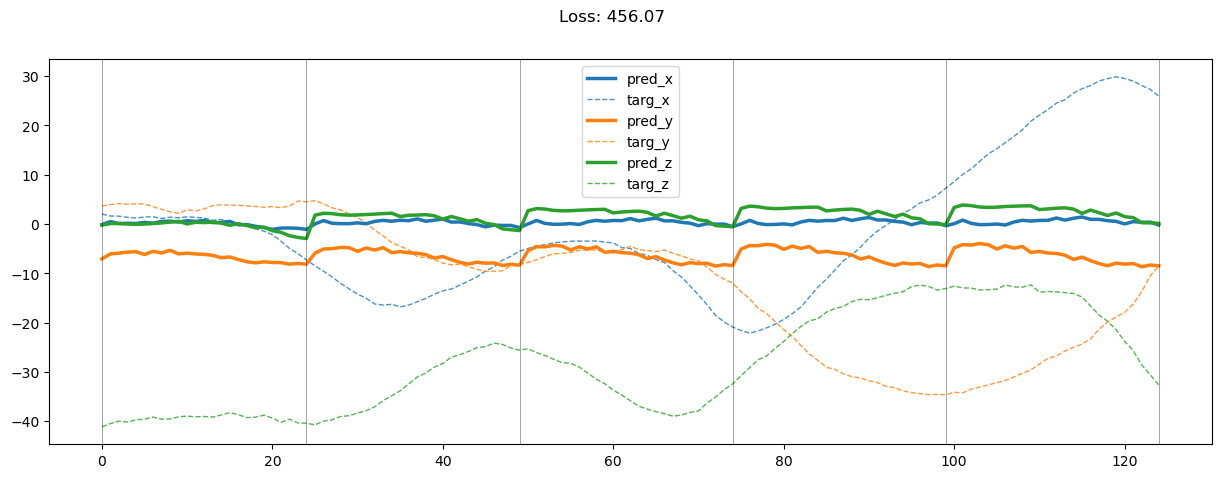

00349: train total loss:  4.220, pred loss:  4.220, valid total loss:  606.483, pred loss:  606.483


100%|██████████| 8/8 [00:00<00:00, 17.95it/s]


00350: train total loss:  4.401, pred loss:  4.401, valid total loss:  621.648, pred loss:  621.648


100%|██████████| 8/8 [00:00<00:00, 17.03it/s]


00351: train total loss:  4.606, pred loss:  4.606, valid total loss:  617.712, pred loss:  617.712


100%|██████████| 8/8 [00:00<00:00, 21.32it/s]


00352: train total loss:  4.474, pred loss:  4.474, valid total loss:  617.007, pred loss:  617.007


100%|██████████| 8/8 [00:00<00:00, 19.55it/s]


00353: train total loss:  4.718, pred loss:  4.718, valid total loss:  602.490, pred loss:  602.490


100%|██████████| 8/8 [00:00<00:00, 19.66it/s]


00354: train total loss:  4.724, pred loss:  4.724, valid total loss:  626.668, pred loss:  626.668


100%|██████████| 8/8 [00:00<00:00, 20.66it/s]


00355: train total loss:  4.812, pred loss:  4.812, valid total loss:  605.181, pred loss:  605.181


100%|██████████| 8/8 [00:00<00:00, 20.95it/s]


00356: train total loss:  4.650, pred loss:  4.650, valid total loss:  624.878, pred loss:  624.878


100%|██████████| 8/8 [00:00<00:00, 20.67it/s]


00357: train total loss:  4.641, pred loss:  4.641, valid total loss:  620.361, pred loss:  620.361


100%|██████████| 8/8 [00:00<00:00, 21.28it/s]


00358: train total loss:  4.442, pred loss:  4.442, valid total loss:  613.322, pred loss:  613.322


100%|██████████| 8/8 [00:00<00:00, 18.57it/s]


00359: train total loss:  4.388, pred loss:  4.388, valid total loss:  595.224, pred loss:  595.224


100%|██████████| 8/8 [00:00<00:00, 17.28it/s]


00360: train total loss:  4.813, pred loss:  4.813, valid total loss:  610.383, pred loss:  610.383


100%|██████████| 8/8 [00:00<00:00, 20.13it/s]


00361: train total loss:  4.701, pred loss:  4.701, valid total loss:  602.231, pred loss:  602.231


100%|██████████| 8/8 [00:00<00:00, 19.50it/s]


00362: train total loss:  5.317, pred loss:  5.317, valid total loss:  601.774, pred loss:  601.774


100%|██████████| 8/8 [00:00<00:00, 19.75it/s]


00363: train total loss:  5.530, pred loss:  5.530, valid total loss:  575.527, pred loss:  575.527


100%|██████████| 8/8 [00:00<00:00, 20.83it/s]


00364: train total loss:  5.260, pred loss:  5.260, valid total loss:  609.187, pred loss:  609.187


100%|██████████| 8/8 [00:00<00:00, 19.77it/s]


00365: train total loss:  4.739, pred loss:  4.739, valid total loss:  598.626, pred loss:  598.626


100%|██████████| 8/8 [00:00<00:00, 19.40it/s]


00366: train total loss:  4.678, pred loss:  4.678, valid total loss:  600.734, pred loss:  600.734


100%|██████████| 8/8 [00:00<00:00, 20.78it/s]


00367: train total loss:  4.699, pred loss:  4.699, valid total loss:  588.343, pred loss:  588.343


100%|██████████| 8/8 [00:00<00:00, 20.75it/s]


00368: train total loss:  4.750, pred loss:  4.750, valid total loss:  609.519, pred loss:  609.519


100%|██████████| 8/8 [00:00<00:00, 20.24it/s]


00369: train total loss:  5.186, pred loss:  5.186, valid total loss:  604.952, pred loss:  604.952


100%|██████████| 8/8 [00:00<00:00, 18.99it/s]


00370: train total loss:  4.416, pred loss:  4.416, valid total loss:  614.084, pred loss:  614.084


100%|██████████| 8/8 [00:00<00:00, 19.26it/s]


00371: train total loss:  4.410, pred loss:  4.410, valid total loss:  605.265, pred loss:  605.265


100%|██████████| 8/8 [00:00<00:00, 20.72it/s]


00372: train total loss:  4.673, pred loss:  4.673, valid total loss:  606.265, pred loss:  606.265


100%|██████████| 8/8 [00:00<00:00, 22.26it/s]


00373: train total loss:  3.938, pred loss:  3.938, valid total loss:  615.326, pred loss:  615.326


100%|██████████| 8/8 [00:00<00:00, 22.32it/s]


00374: train total loss:  4.151, pred loss:  4.151, valid total loss:  620.545, pred loss:  620.545


100%|██████████| 8/8 [00:00<00:00, 22.33it/s]


00375: train total loss:  4.820, pred loss:  4.820, valid total loss:  609.667, pred loss:  609.667


100%|██████████| 8/8 [00:00<00:00, 22.24it/s]


00376: train total loss:  4.430, pred loss:  4.430, valid total loss:  605.127, pred loss:  605.127


100%|██████████| 8/8 [00:00<00:00, 22.36it/s]


00377: train total loss:  4.249, pred loss:  4.249, valid total loss:  606.622, pred loss:  606.622


100%|██████████| 8/8 [00:00<00:00, 22.30it/s]


00378: train total loss:  4.223, pred loss:  4.223, valid total loss:  616.543, pred loss:  616.543


100%|██████████| 8/8 [00:00<00:00, 22.37it/s]


00379: train total loss:  4.638, pred loss:  4.638, valid total loss:  622.376, pred loss:  622.376


100%|██████████| 8/8 [00:00<00:00, 20.34it/s]


00380: train total loss:  4.557, pred loss:  4.557, valid total loss:  615.976, pred loss:  615.976


100%|██████████| 8/8 [00:00<00:00, 20.93it/s]


00381: train total loss:  4.340, pred loss:  4.340, valid total loss:  604.232, pred loss:  604.232


100%|██████████| 8/8 [00:00<00:00, 20.16it/s]


00382: train total loss:  4.193, pred loss:  4.193, valid total loss:  616.590, pred loss:  616.590


100%|██████████| 8/8 [00:00<00:00, 20.41it/s]


00383: train total loss:  4.187, pred loss:  4.187, valid total loss:  620.877, pred loss:  620.877


100%|██████████| 8/8 [00:00<00:00, 20.35it/s]


00384: train total loss:  5.482, pred loss:  5.482, valid total loss:  607.085, pred loss:  607.085


100%|██████████| 8/8 [00:00<00:00, 19.51it/s]


00385: train total loss:  6.089, pred loss:  6.089, valid total loss:  600.117, pred loss:  600.117


100%|██████████| 8/8 [00:00<00:00, 20.52it/s]


00386: train total loss:  5.535, pred loss:  5.535, valid total loss:  604.646, pred loss:  604.646


100%|██████████| 8/8 [00:00<00:00, 20.32it/s]


00387: train total loss:  5.744, pred loss:  5.744, valid total loss:  595.953, pred loss:  595.953


100%|██████████| 8/8 [00:00<00:00, 20.18it/s]


00388: train total loss:  5.048, pred loss:  5.048, valid total loss:  620.157, pred loss:  620.157


100%|██████████| 8/8 [00:00<00:00, 20.08it/s]


00389: train total loss:  4.792, pred loss:  4.792, valid total loss:  618.648, pred loss:  618.648


100%|██████████| 8/8 [00:00<00:00, 20.18it/s]


00390: train total loss:  5.094, pred loss:  5.094, valid total loss:  614.075, pred loss:  614.075


100%|██████████| 8/8 [00:00<00:00, 20.02it/s]


00391: train total loss:  5.478, pred loss:  5.478, valid total loss:  632.260, pred loss:  632.260


100%|██████████| 8/8 [00:00<00:00, 20.67it/s]


00392: train total loss:  5.507, pred loss:  5.507, valid total loss:  611.878, pred loss:  611.878


100%|██████████| 8/8 [00:00<00:00, 19.23it/s]


00393: train total loss:  5.196, pred loss:  5.196, valid total loss:  625.104, pred loss:  625.104


100%|██████████| 8/8 [00:00<00:00, 20.39it/s]


00394: train total loss:  5.010, pred loss:  5.010, valid total loss:  602.011, pred loss:  602.011


100%|██████████| 8/8 [00:00<00:00, 20.45it/s]


00395: train total loss:  5.723, pred loss:  5.723, valid total loss:  604.395, pred loss:  604.395


100%|██████████| 8/8 [00:00<00:00, 20.12it/s]


00396: train total loss:  5.431, pred loss:  5.431, valid total loss:  589.483, pred loss:  589.483


100%|██████████| 8/8 [00:00<00:00, 20.28it/s]


00397: train total loss:  4.580, pred loss:  4.580, valid total loss:  602.959, pred loss:  602.959


100%|██████████| 8/8 [00:00<00:00, 20.54it/s]


00398: train total loss:  4.598, pred loss:  4.598, valid total loss:  598.661, pred loss:  598.661


100%|██████████| 8/8 [00:00<00:00, 20.31it/s]


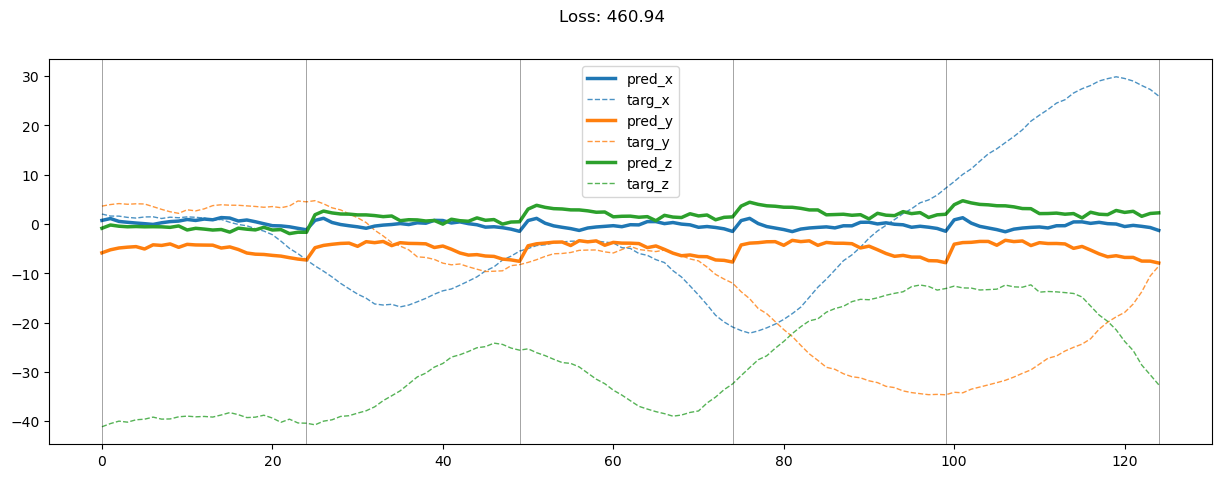

00399: train total loss:  4.218, pred loss:  4.218, valid total loss:  606.604, pred loss:  606.604


100%|██████████| 8/8 [00:00<00:00, 17.67it/s]


00400: train total loss:  4.389, pred loss:  4.389, valid total loss:  622.619, pred loss:  622.619


100%|██████████| 8/8 [00:00<00:00, 20.45it/s]


00401: train total loss:  4.262, pred loss:  4.262, valid total loss:  602.704, pred loss:  602.704


100%|██████████| 8/8 [00:00<00:00, 19.89it/s]


00402: train total loss:  3.911, pred loss:  3.911, valid total loss:  608.496, pred loss:  608.496


100%|██████████| 8/8 [00:00<00:00, 20.19it/s]


00403: train total loss:  3.965, pred loss:  3.965, valid total loss:  609.851, pred loss:  609.851


100%|██████████| 8/8 [00:00<00:00, 20.86it/s]


00404: train total loss:  3.798, pred loss:  3.798, valid total loss:  610.331, pred loss:  610.331


100%|██████████| 8/8 [00:00<00:00, 20.00it/s]


00405: train total loss:  4.127, pred loss:  4.127, valid total loss:  607.923, pred loss:  607.923


100%|██████████| 8/8 [00:00<00:00, 20.34it/s]


00406: train total loss:  3.848, pred loss:  3.848, valid total loss:  620.141, pred loss:  620.141


100%|██████████| 8/8 [00:00<00:00, 20.11it/s]


00407: train total loss:  4.038, pred loss:  4.038, valid total loss:  611.798, pred loss:  611.798


100%|██████████| 8/8 [00:00<00:00, 20.71it/s]


00408: train total loss:  4.135, pred loss:  4.135, valid total loss:  611.998, pred loss:  611.998


100%|██████████| 8/8 [00:00<00:00, 17.46it/s]


00409: train total loss:  3.653, pred loss:  3.653, valid total loss:  607.500, pred loss:  607.500


100%|██████████| 8/8 [00:00<00:00, 22.34it/s]


00410: train total loss:  3.692, pred loss:  3.692, valid total loss:  612.751, pred loss:  612.751


100%|██████████| 8/8 [00:00<00:00, 22.09it/s]


00411: train total loss:  4.142, pred loss:  4.142, valid total loss:  601.282, pred loss:  601.282


100%|██████████| 8/8 [00:00<00:00, 20.79it/s]


00412: train total loss:  4.092, pred loss:  4.092, valid total loss:  606.291, pred loss:  606.291


100%|██████████| 8/8 [00:00<00:00, 22.37it/s]


00413: train total loss:  4.017, pred loss:  4.017, valid total loss:  608.058, pred loss:  608.058


100%|██████████| 8/8 [00:00<00:00, 22.38it/s]


00414: train total loss:  3.908, pred loss:  3.908, valid total loss:  607.196, pred loss:  607.196


100%|██████████| 8/8 [00:00<00:00, 22.00it/s]


00415: train total loss:  4.607, pred loss:  4.607, valid total loss:  607.763, pred loss:  607.763


100%|██████████| 8/8 [00:00<00:00, 22.33it/s]


00416: train total loss:  4.285, pred loss:  4.285, valid total loss:  623.492, pred loss:  623.492


100%|██████████| 8/8 [00:00<00:00, 22.36it/s]


00417: train total loss:  4.012, pred loss:  4.012, valid total loss:  613.132, pred loss:  613.132


100%|██████████| 8/8 [00:00<00:00, 20.59it/s]


00418: train total loss:  4.037, pred loss:  4.037, valid total loss:  615.252, pred loss:  615.252


100%|██████████| 8/8 [00:00<00:00, 21.75it/s]


00419: train total loss:  4.133, pred loss:  4.133, valid total loss:  598.423, pred loss:  598.423


100%|██████████| 8/8 [00:00<00:00, 22.34it/s]


00420: train total loss:  4.631, pred loss:  4.631, valid total loss:  591.178, pred loss:  591.178


100%|██████████| 8/8 [00:00<00:00, 22.34it/s]


00421: train total loss:  5.021, pred loss:  5.021, valid total loss:  594.706, pred loss:  594.706


100%|██████████| 8/8 [00:00<00:00, 22.33it/s]


00422: train total loss:  4.659, pred loss:  4.659, valid total loss:  575.897, pred loss:  575.897


100%|██████████| 8/8 [00:00<00:00, 22.19it/s]


00423: train total loss:  4.658, pred loss:  4.658, valid total loss:  596.846, pred loss:  596.846


100%|██████████| 8/8 [00:00<00:00, 22.21it/s]


00424: train total loss:  4.345, pred loss:  4.345, valid total loss:  642.366, pred loss:  642.366


100%|██████████| 8/8 [00:00<00:00, 21.29it/s]


00425: train total loss:  4.276, pred loss:  4.276, valid total loss:  623.625, pred loss:  623.625


100%|██████████| 8/8 [00:00<00:00, 22.34it/s]


00426: train total loss:  4.408, pred loss:  4.408, valid total loss:  620.730, pred loss:  620.730


100%|██████████| 8/8 [00:00<00:00, 22.11it/s]


00427: train total loss:  4.425, pred loss:  4.425, valid total loss:  603.762, pred loss:  603.762


100%|██████████| 8/8 [00:00<00:00, 22.34it/s]


00428: train total loss:  4.437, pred loss:  4.437, valid total loss:  582.569, pred loss:  582.569


100%|██████████| 8/8 [00:00<00:00, 20.61it/s]


00429: train total loss:  4.887, pred loss:  4.887, valid total loss:  594.972, pred loss:  594.972


100%|██████████| 8/8 [00:00<00:00, 20.40it/s]


00430: train total loss:  6.368, pred loss:  6.368, valid total loss:  592.596, pred loss:  592.596


100%|██████████| 8/8 [00:00<00:00, 22.22it/s]


00431: train total loss:  6.580, pred loss:  6.580, valid total loss:  584.846, pred loss:  584.846


100%|██████████| 8/8 [00:00<00:00, 22.42it/s]


00432: train total loss:  5.817, pred loss:  5.817, valid total loss:  598.505, pred loss:  598.505


100%|██████████| 8/8 [00:00<00:00, 22.36it/s]


00433: train total loss:  5.564, pred loss:  5.564, valid total loss:  613.796, pred loss:  613.796


100%|██████████| 8/8 [00:00<00:00, 22.38it/s]


00434: train total loss:  6.782, pred loss:  6.782, valid total loss:  641.227, pred loss:  641.227


100%|██████████| 8/8 [00:00<00:00, 22.19it/s]


00435: train total loss:  6.244, pred loss:  6.244, valid total loss:  607.229, pred loss:  607.229


100%|██████████| 8/8 [00:00<00:00, 22.36it/s]


00436: train total loss:  5.375, pred loss:  5.375, valid total loss:  636.292, pred loss:  636.292


100%|██████████| 8/8 [00:00<00:00, 22.30it/s]


00437: train total loss:  5.323, pred loss:  5.323, valid total loss:  631.028, pred loss:  631.028


100%|██████████| 8/8 [00:00<00:00, 20.99it/s]


00438: train total loss:  4.553, pred loss:  4.553, valid total loss:  645.472, pred loss:  645.472


100%|██████████| 8/8 [00:00<00:00, 20.54it/s]


00439: train total loss:  4.069, pred loss:  4.069, valid total loss:  606.339, pred loss:  606.339


100%|██████████| 8/8 [00:00<00:00, 20.74it/s]


00440: train total loss:  4.035, pred loss:  4.035, valid total loss:  604.705, pred loss:  604.705


100%|██████████| 8/8 [00:00<00:00, 20.42it/s]


00441: train total loss:  4.283, pred loss:  4.283, valid total loss:  607.532, pred loss:  607.532


100%|██████████| 8/8 [00:00<00:00, 19.94it/s]


00442: train total loss:  4.062, pred loss:  4.062, valid total loss:  625.520, pred loss:  625.520


100%|██████████| 8/8 [00:00<00:00, 19.06it/s]


00443: train total loss:  4.095, pred loss:  4.095, valid total loss:  622.146, pred loss:  622.146


100%|██████████| 8/8 [00:00<00:00, 19.83it/s]


00444: train total loss:  3.971, pred loss:  3.971, valid total loss:  629.803, pred loss:  629.803


100%|██████████| 8/8 [00:00<00:00, 20.37it/s]


00445: train total loss:  4.363, pred loss:  4.363, valid total loss:  625.887, pred loss:  625.887


100%|██████████| 8/8 [00:00<00:00, 20.74it/s]


00446: train total loss:  4.242, pred loss:  4.242, valid total loss:  631.451, pred loss:  631.451


100%|██████████| 8/8 [00:00<00:00, 20.22it/s]


00447: train total loss:  4.054, pred loss:  4.054, valid total loss:  654.274, pred loss:  654.274


100%|██████████| 8/8 [00:00<00:00, 20.34it/s]


00448: train total loss:  4.165, pred loss:  4.165, valid total loss:  620.092, pred loss:  620.092


100%|██████████| 8/8 [00:00<00:00, 21.06it/s]


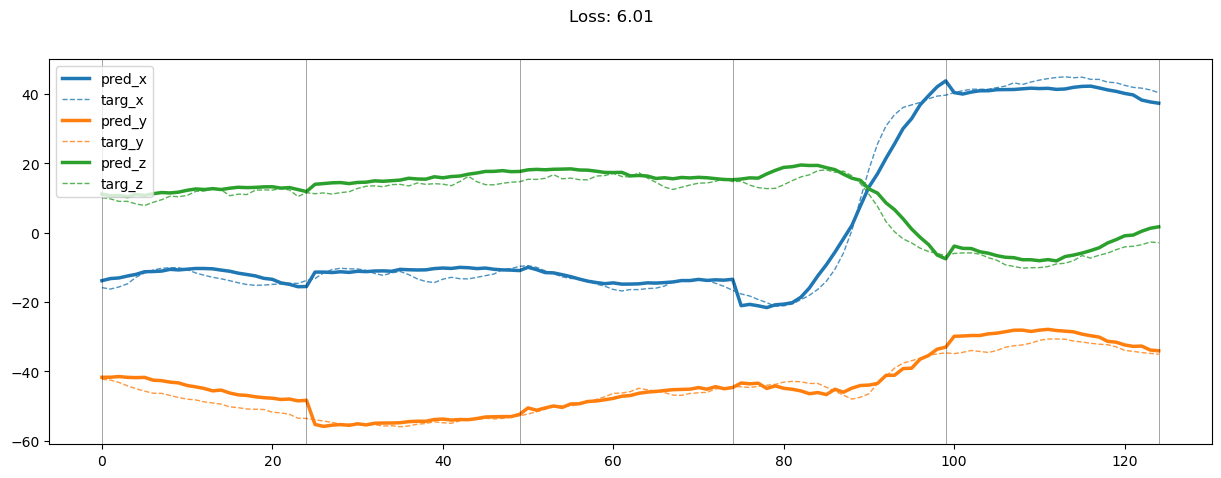

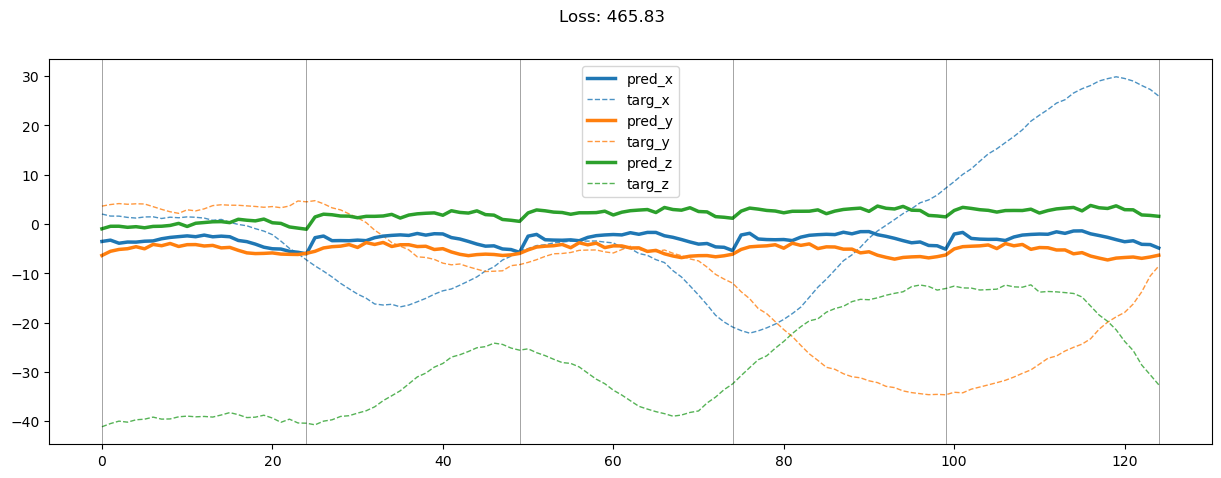

00449: train total loss:  3.793, pred loss:  3.793, valid total loss:  611.115, pred loss:  611.115


100%|██████████| 8/8 [00:00<00:00, 21.85it/s]


00450: train total loss:  3.937, pred loss:  3.937, valid total loss:  642.892, pred loss:  642.892


100%|██████████| 8/8 [00:00<00:00, 22.37it/s]


00451: train total loss:  3.742, pred loss:  3.742, valid total loss:  623.856, pred loss:  623.856


100%|██████████| 8/8 [00:00<00:00, 22.35it/s]


00452: train total loss:  4.081, pred loss:  4.081, valid total loss:  607.497, pred loss:  607.497


100%|██████████| 8/8 [00:00<00:00, 22.38it/s]


00453: train total loss:  4.085, pred loss:  4.085, valid total loss:  614.112, pred loss:  614.112


100%|██████████| 8/8 [00:00<00:00, 22.26it/s]


00454: train total loss:  4.035, pred loss:  4.035, valid total loss:  609.980, pred loss:  609.980


100%|██████████| 8/8 [00:00<00:00, 22.40it/s]


00455: train total loss:  3.899, pred loss:  3.899, valid total loss:  611.663, pred loss:  611.663


100%|██████████| 8/8 [00:00<00:00, 22.39it/s]


00456: train total loss:  3.759, pred loss:  3.759, valid total loss:  600.973, pred loss:  600.973


100%|██████████| 8/8 [00:00<00:00, 22.41it/s]


00457: train total loss:  3.995, pred loss:  3.995, valid total loss:  608.236, pred loss:  608.236


100%|██████████| 8/8 [00:00<00:00, 21.75it/s]


00458: train total loss:  3.906, pred loss:  3.906, valid total loss:  610.004, pred loss:  610.004


100%|██████████| 8/8 [00:00<00:00, 22.38it/s]


00459: train total loss:  3.989, pred loss:  3.989, valid total loss:  613.219, pred loss:  613.219


100%|██████████| 8/8 [00:00<00:00, 21.08it/s]


00460: train total loss:  3.823, pred loss:  3.823, valid total loss:  618.747, pred loss:  618.747


100%|██████████| 8/8 [00:00<00:00, 22.33it/s]


00461: train total loss:  3.738, pred loss:  3.738, valid total loss:  611.962, pred loss:  611.962


100%|██████████| 8/8 [00:00<00:00, 22.25it/s]


00462: train total loss:  3.722, pred loss:  3.722, valid total loss:  613.828, pred loss:  613.828


100%|██████████| 8/8 [00:00<00:00, 22.44it/s]


00463: train total loss:  3.693, pred loss:  3.693, valid total loss:  601.310, pred loss:  601.310


100%|██████████| 8/8 [00:00<00:00, 22.40it/s]


00464: train total loss:  3.857, pred loss:  3.857, valid total loss:  600.173, pred loss:  600.173


100%|██████████| 8/8 [00:00<00:00, 22.46it/s]


00465: train total loss:  3.845, pred loss:  3.845, valid total loss:  623.036, pred loss:  623.036


100%|██████████| 8/8 [00:00<00:00, 22.17it/s]


00466: train total loss:  3.858, pred loss:  3.858, valid total loss:  603.851, pred loss:  603.851


100%|██████████| 8/8 [00:00<00:00, 22.43it/s]


00467: train total loss:  3.607, pred loss:  3.607, valid total loss:  610.657, pred loss:  610.657


100%|██████████| 8/8 [00:00<00:00, 22.40it/s]


00468: train total loss:  3.521, pred loss:  3.521, valid total loss:  615.838, pred loss:  615.838


100%|██████████| 8/8 [00:00<00:00, 22.44it/s]


00469: train total loss:  3.969, pred loss:  3.969, valid total loss:  601.527, pred loss:  601.527


100%|██████████| 8/8 [00:00<00:00, 22.22it/s]


00470: train total loss:  3.419, pred loss:  3.419, valid total loss:  603.791, pred loss:  603.791


100%|██████████| 8/8 [00:00<00:00, 21.04it/s]


00471: train total loss:  3.933, pred loss:  3.933, valid total loss:  578.639, pred loss:  578.639


100%|██████████| 8/8 [00:00<00:00, 20.78it/s]


00472: train total loss:  3.679, pred loss:  3.679, valid total loss:  615.388, pred loss:  615.388


100%|██████████| 8/8 [00:00<00:00, 20.56it/s]


00473: train total loss:  3.781, pred loss:  3.781, valid total loss:  594.560, pred loss:  594.560


100%|██████████| 8/8 [00:00<00:00, 20.24it/s]


00474: train total loss:  4.432, pred loss:  4.432, valid total loss:  599.530, pred loss:  599.530


100%|██████████| 8/8 [00:00<00:00, 21.36it/s]


00475: train total loss:  4.893, pred loss:  4.893, valid total loss:  607.377, pred loss:  607.377


100%|██████████| 8/8 [00:00<00:00, 21.50it/s]


00476: train total loss:  4.392, pred loss:  4.392, valid total loss:  577.354, pred loss:  577.354


100%|██████████| 8/8 [00:00<00:00, 20.89it/s]


00477: train total loss:  4.111, pred loss:  4.111, valid total loss:  605.367, pred loss:  605.367


100%|██████████| 8/8 [00:00<00:00, 20.12it/s]


00478: train total loss:  3.886, pred loss:  3.886, valid total loss:  614.791, pred loss:  614.791


100%|██████████| 8/8 [00:00<00:00, 20.63it/s]


00479: train total loss:  3.916, pred loss:  3.916, valid total loss:  599.267, pred loss:  599.267


100%|██████████| 8/8 [00:00<00:00, 20.43it/s]


00480: train total loss:  3.689, pred loss:  3.689, valid total loss:  594.844, pred loss:  594.844


100%|██████████| 8/8 [00:00<00:00, 21.08it/s]


00481: train total loss:  4.177, pred loss:  4.177, valid total loss:  608.897, pred loss:  608.897


100%|██████████| 8/8 [00:00<00:00, 21.30it/s]


00482: train total loss:  3.994, pred loss:  3.994, valid total loss:  623.344, pred loss:  623.344


100%|██████████| 8/8 [00:00<00:00, 21.00it/s]


00483: train total loss:  3.860, pred loss:  3.860, valid total loss:  587.980, pred loss:  587.980


100%|██████████| 8/8 [00:00<00:00, 20.46it/s]


00484: train total loss:  3.819, pred loss:  3.819, valid total loss:  598.678, pred loss:  598.678


100%|██████████| 8/8 [00:00<00:00, 18.57it/s]


00485: train total loss:  3.634, pred loss:  3.634, valid total loss:  587.420, pred loss:  587.420


100%|██████████| 8/8 [00:00<00:00, 19.78it/s]


00486: train total loss:  3.477, pred loss:  3.477, valid total loss:  597.975, pred loss:  597.975


100%|██████████| 8/8 [00:00<00:00, 20.77it/s]


00487: train total loss:  3.387, pred loss:  3.387, valid total loss:  592.527, pred loss:  592.527


100%|██████████| 8/8 [00:00<00:00, 19.83it/s]


00488: train total loss:  3.640, pred loss:  3.640, valid total loss:  592.737, pred loss:  592.737


100%|██████████| 8/8 [00:00<00:00, 19.44it/s]


00489: train total loss:  3.530, pred loss:  3.530, valid total loss:  590.490, pred loss:  590.490


100%|██████████| 8/8 [00:00<00:00, 19.52it/s]


00490: train total loss:  3.253, pred loss:  3.253, valid total loss:  598.969, pred loss:  598.969


100%|██████████| 8/8 [00:00<00:00, 21.83it/s]


00491: train total loss:  3.393, pred loss:  3.393, valid total loss:  603.703, pred loss:  603.703


100%|██████████| 8/8 [00:00<00:00, 22.41it/s]


00492: train total loss:  3.256, pred loss:  3.256, valid total loss:  605.755, pred loss:  605.755


100%|██████████| 8/8 [00:00<00:00, 22.23it/s]


00493: train total loss:  3.072, pred loss:  3.072, valid total loss:  601.615, pred loss:  601.615


100%|██████████| 8/8 [00:00<00:00, 22.40it/s]


00494: train total loss:  3.191, pred loss:  3.191, valid total loss:  575.402, pred loss:  575.402


100%|██████████| 8/8 [00:00<00:00, 22.35it/s]


00495: train total loss:  3.119, pred loss:  3.119, valid total loss:  592.247, pred loss:  592.247


100%|██████████| 8/8 [00:00<00:00, 22.36it/s]


00496: train total loss:  3.184, pred loss:  3.184, valid total loss:  590.564, pred loss:  590.564


100%|██████████| 8/8 [00:00<00:00, 22.21it/s]


00497: train total loss:  3.648, pred loss:  3.648, valid total loss:  598.209, pred loss:  598.209


100%|██████████| 8/8 [00:00<00:00, 22.38it/s]


00498: train total loss:  3.239, pred loss:  3.239, valid total loss:  595.022, pred loss:  595.022


100%|██████████| 8/8 [00:00<00:00, 22.41it/s]


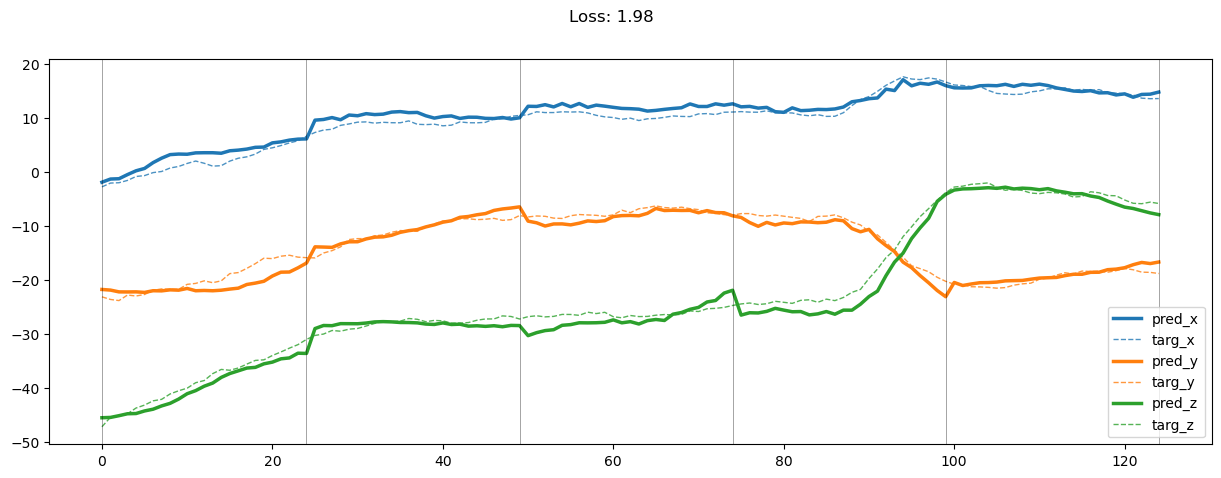

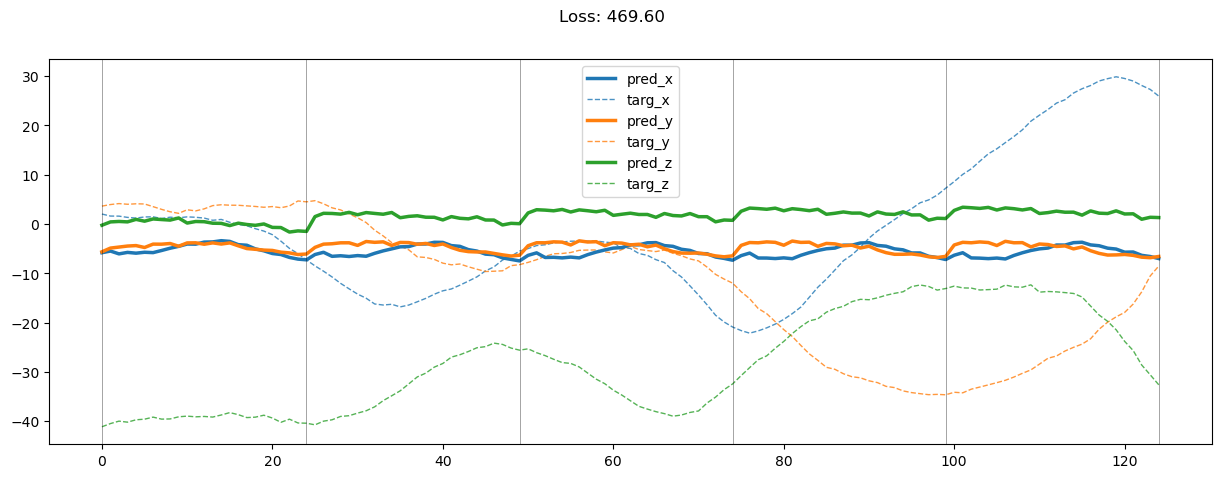

00499: train total loss:  3.578, pred loss:  3.578, valid total loss:  610.225, pred loss:  610.225


100%|██████████| 8/8 [00:00<00:00, 18.38it/s]


00500: train total loss:  4.371, pred loss:  4.371, valid total loss:  584.910, pred loss:  584.910


100%|██████████| 8/8 [00:00<00:00, 22.38it/s]


00501: train total loss:  3.926, pred loss:  3.926, valid total loss:  603.200, pred loss:  603.200


100%|██████████| 8/8 [00:00<00:00, 22.35it/s]


00502: train total loss:  4.664, pred loss:  4.664, valid total loss:  598.460, pred loss:  598.460


100%|██████████| 8/8 [00:00<00:00, 22.34it/s]


00503: train total loss:  4.300, pred loss:  4.300, valid total loss:  602.198, pred loss:  602.198


100%|██████████| 8/8 [00:00<00:00, 22.35it/s]


00504: train total loss:  4.095, pred loss:  4.095, valid total loss:  603.855, pred loss:  603.855


100%|██████████| 8/8 [00:00<00:00, 22.38it/s]


00505: train total loss:  3.971, pred loss:  3.971, valid total loss:  606.585, pred loss:  606.585


100%|██████████| 8/8 [00:00<00:00, 22.31it/s]


00506: train total loss:  3.495, pred loss:  3.495, valid total loss:  602.046, pred loss:  602.046


100%|██████████| 8/8 [00:00<00:00, 22.37it/s]


00507: train total loss:  3.446, pred loss:  3.446, valid total loss:  601.212, pred loss:  601.212


100%|██████████| 8/8 [00:00<00:00, 22.36it/s]


00508: train total loss:  3.760, pred loss:  3.760, valid total loss:  616.131, pred loss:  616.131


100%|██████████| 8/8 [00:00<00:00, 22.35it/s]


00509: train total loss:  3.478, pred loss:  3.478, valid total loss:  607.700, pred loss:  607.700


100%|██████████| 8/8 [00:00<00:00, 22.41it/s]


00510: train total loss:  3.506, pred loss:  3.506, valid total loss:  585.441, pred loss:  585.441


100%|██████████| 8/8 [00:00<00:00, 22.40it/s]


00511: train total loss:  3.549, pred loss:  3.549, valid total loss:  580.799, pred loss:  580.799


100%|██████████| 8/8 [00:00<00:00, 22.38it/s]


00512: train total loss:  3.306, pred loss:  3.306, valid total loss:  590.351, pred loss:  590.351


100%|██████████| 8/8 [00:00<00:00, 22.34it/s]


00513: train total loss:  3.220, pred loss:  3.220, valid total loss:  589.587, pred loss:  589.587


100%|██████████| 8/8 [00:00<00:00, 22.36it/s]


00514: train total loss:  3.209, pred loss:  3.209, valid total loss:  616.577, pred loss:  616.577


100%|██████████| 8/8 [00:00<00:00, 22.38it/s]


00515: train total loss:  3.287, pred loss:  3.287, valid total loss:  584.122, pred loss:  584.122


100%|██████████| 8/8 [00:00<00:00, 22.39it/s]


00516: train total loss:  3.421, pred loss:  3.421, valid total loss:  599.052, pred loss:  599.052


100%|██████████| 8/8 [00:00<00:00, 22.27it/s]


00517: train total loss:  3.297, pred loss:  3.297, valid total loss:  589.754, pred loss:  589.754


100%|██████████| 8/8 [00:00<00:00, 22.37it/s]


00518: train total loss:  3.139, pred loss:  3.139, valid total loss:  594.571, pred loss:  594.571


100%|██████████| 8/8 [00:00<00:00, 22.38it/s]


00519: train total loss:  3.052, pred loss:  3.052, valid total loss:  598.438, pred loss:  598.438


100%|██████████| 8/8 [00:00<00:00, 22.37it/s]


00520: train total loss:  3.130, pred loss:  3.130, valid total loss:  582.186, pred loss:  582.186


100%|██████████| 8/8 [00:00<00:00, 21.76it/s]


00521: train total loss:  3.279, pred loss:  3.279, valid total loss:  613.534, pred loss:  613.534


100%|██████████| 8/8 [00:00<00:00, 22.39it/s]


00522: train total loss:  3.194, pred loss:  3.194, valid total loss:  584.730, pred loss:  584.730


100%|██████████| 8/8 [00:00<00:00, 22.41it/s]


00523: train total loss:  3.428, pred loss:  3.428, valid total loss:  599.108, pred loss:  599.108


100%|██████████| 8/8 [00:00<00:00, 22.34it/s]


00524: train total loss:  3.410, pred loss:  3.410, valid total loss:  600.693, pred loss:  600.693


100%|██████████| 8/8 [00:00<00:00, 22.17it/s]


00525: train total loss:  3.316, pred loss:  3.316, valid total loss:  605.693, pred loss:  605.693


100%|██████████| 8/8 [00:00<00:00, 19.38it/s]


00526: train total loss:  3.137, pred loss:  3.137, valid total loss:  608.853, pred loss:  608.853


100%|██████████| 8/8 [00:00<00:00, 19.51it/s]


00527: train total loss:  2.945, pred loss:  2.945, valid total loss:  601.993, pred loss:  601.993


100%|██████████| 8/8 [00:00<00:00, 20.31it/s]


00528: train total loss:  3.091, pred loss:  3.091, valid total loss:  614.710, pred loss:  614.710


100%|██████████| 8/8 [00:00<00:00, 20.46it/s]


00529: train total loss:  3.376, pred loss:  3.376, valid total loss:  592.451, pred loss:  592.451


100%|██████████| 8/8 [00:00<00:00, 21.03it/s]


00530: train total loss:  3.467, pred loss:  3.467, valid total loss:  596.297, pred loss:  596.297


100%|██████████| 8/8 [00:00<00:00, 20.05it/s]


00531: train total loss:  3.359, pred loss:  3.359, valid total loss:  613.336, pred loss:  613.336


100%|██████████| 8/8 [00:00<00:00, 20.92it/s]


00532: train total loss:  3.204, pred loss:  3.204, valid total loss:  615.963, pred loss:  615.963


100%|██████████| 8/8 [00:00<00:00, 21.24it/s]


00533: train total loss:  3.349, pred loss:  3.349, valid total loss:  610.910, pred loss:  610.910


100%|██████████| 8/8 [00:00<00:00, 20.28it/s]


00534: train total loss:  3.959, pred loss:  3.959, valid total loss:  589.954, pred loss:  589.954


100%|██████████| 8/8 [00:00<00:00, 19.70it/s]


00535: train total loss:  3.316, pred loss:  3.316, valid total loss:  588.590, pred loss:  588.590


100%|██████████| 8/8 [00:00<00:00, 19.95it/s]


00536: train total loss:  3.305, pred loss:  3.305, valid total loss:  586.018, pred loss:  586.018


100%|██████████| 8/8 [00:00<00:00, 19.76it/s]


00537: train total loss:  3.296, pred loss:  3.296, valid total loss:  593.705, pred loss:  593.705


100%|██████████| 8/8 [00:00<00:00, 19.75it/s]


00538: train total loss:  3.187, pred loss:  3.187, valid total loss:  593.261, pred loss:  593.261


100%|██████████| 8/8 [00:00<00:00, 19.53it/s]


00539: train total loss:  3.395, pred loss:  3.395, valid total loss:  591.806, pred loss:  591.806


100%|██████████| 8/8 [00:00<00:00, 20.05it/s]


00540: train total loss:  3.600, pred loss:  3.600, valid total loss:  583.044, pred loss:  583.044


100%|██████████| 8/8 [00:00<00:00, 20.96it/s]


00541: train total loss:  3.743, pred loss:  3.743, valid total loss:  604.344, pred loss:  604.344


100%|██████████| 8/8 [00:00<00:00, 21.15it/s]


00542: train total loss:  3.384, pred loss:  3.384, valid total loss:  609.035, pred loss:  609.035


100%|██████████| 8/8 [00:00<00:00, 20.88it/s]


00543: train total loss:  3.125, pred loss:  3.125, valid total loss:  617.159, pred loss:  617.159


100%|██████████| 8/8 [00:00<00:00, 19.23it/s]


00544: train total loss:  3.115, pred loss:  3.115, valid total loss:  595.712, pred loss:  595.712


100%|██████████| 8/8 [00:00<00:00, 19.43it/s]


00545: train total loss:  3.014, pred loss:  3.014, valid total loss:  585.085, pred loss:  585.085


100%|██████████| 8/8 [00:00<00:00, 19.69it/s]


00546: train total loss:  3.247, pred loss:  3.247, valid total loss:  590.415, pred loss:  590.415


100%|██████████| 8/8 [00:00<00:00, 20.10it/s]


00547: train total loss:  3.285, pred loss:  3.285, valid total loss:  583.109, pred loss:  583.109


100%|██████████| 8/8 [00:00<00:00, 19.75it/s]


00548: train total loss:  3.282, pred loss:  3.282, valid total loss:  577.351, pred loss:  577.351


100%|██████████| 8/8 [00:00<00:00, 19.83it/s]


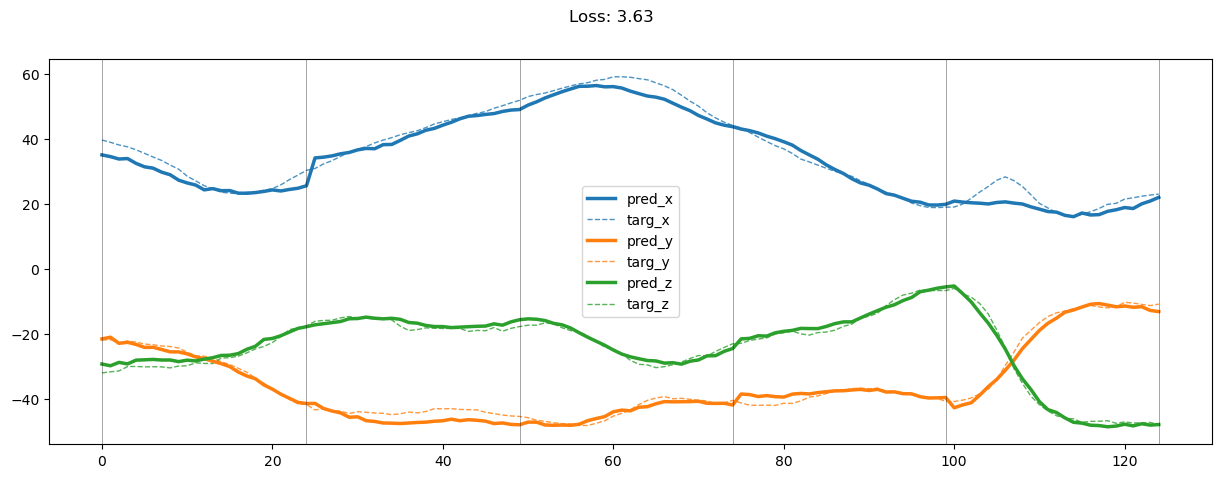

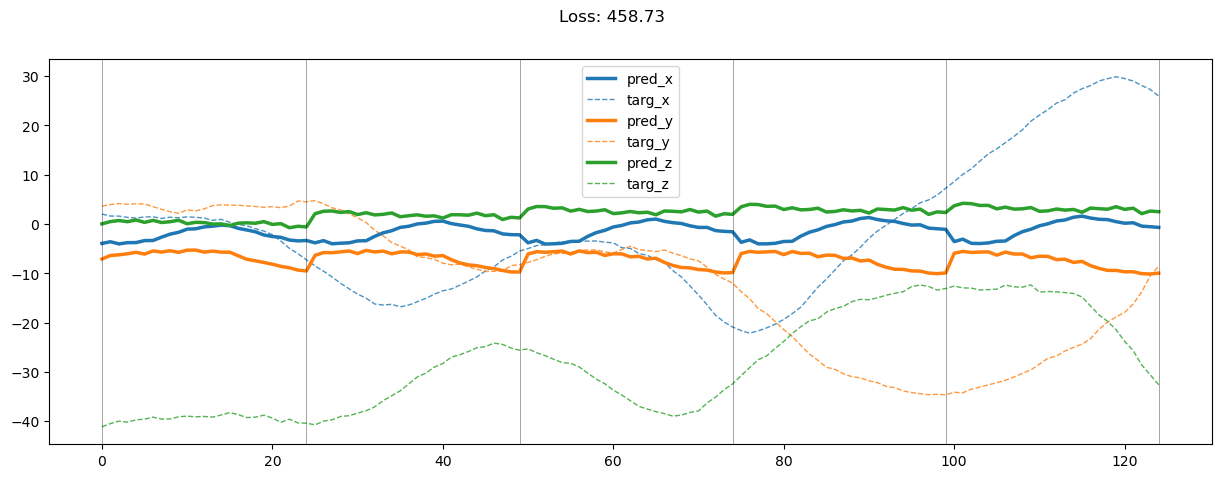

00549: train total loss:  3.852, pred loss:  3.852, valid total loss:  599.954, pred loss:  599.954


100%|██████████| 8/8 [00:00<00:00, 17.61it/s]


00550: train total loss:  3.903, pred loss:  3.903, valid total loss:  592.209, pred loss:  592.209


100%|██████████| 8/8 [00:00<00:00, 19.76it/s]


00551: train total loss:  4.122, pred loss:  4.122, valid total loss:  590.421, pred loss:  590.421


100%|██████████| 8/8 [00:00<00:00, 19.90it/s]


00552: train total loss:  3.696, pred loss:  3.696, valid total loss:  588.043, pred loss:  588.043


100%|██████████| 8/8 [00:00<00:00, 20.04it/s]


00553: train total loss:  4.232, pred loss:  4.232, valid total loss:  593.164, pred loss:  593.164


100%|██████████| 8/8 [00:00<00:00, 19.66it/s]


00554: train total loss:  4.942, pred loss:  4.942, valid total loss:  598.373, pred loss:  598.373


100%|██████████| 8/8 [00:00<00:00, 19.86it/s]


00555: train total loss:  4.686, pred loss:  4.686, valid total loss:  611.744, pred loss:  611.744


100%|██████████| 8/8 [00:00<00:00, 19.83it/s]


00556: train total loss:  4.356, pred loss:  4.356, valid total loss:  596.978, pred loss:  596.978


100%|██████████| 8/8 [00:00<00:00, 20.57it/s]


00557: train total loss:  3.914, pred loss:  3.914, valid total loss:  613.494, pred loss:  613.494


100%|██████████| 8/8 [00:00<00:00, 22.11it/s]


00558: train total loss:  4.069, pred loss:  4.069, valid total loss:  587.810, pred loss:  587.810


100%|██████████| 8/8 [00:00<00:00, 22.37it/s]


00559: train total loss:  4.113, pred loss:  4.113, valid total loss:  599.909, pred loss:  599.909


100%|██████████| 8/8 [00:00<00:00, 22.37it/s]


00560: train total loss:  3.567, pred loss:  3.567, valid total loss:  607.179, pred loss:  607.179


100%|██████████| 8/8 [00:00<00:00, 22.36it/s]


00561: train total loss:  3.407, pred loss:  3.407, valid total loss:  619.104, pred loss:  619.104


100%|██████████| 8/8 [00:00<00:00, 22.19it/s]


00562: train total loss:  3.396, pred loss:  3.396, valid total loss:  580.317, pred loss:  580.317


100%|██████████| 8/8 [00:00<00:00, 22.34it/s]


00563: train total loss:  3.623, pred loss:  3.623, valid total loss:  595.960, pred loss:  595.960


100%|██████████| 8/8 [00:00<00:00, 22.36it/s]


00564: train total loss:  3.520, pred loss:  3.520, valid total loss:  591.611, pred loss:  591.611


100%|██████████| 8/8 [00:00<00:00, 22.31it/s]


00565: train total loss:  3.498, pred loss:  3.498, valid total loss:  587.014, pred loss:  587.014


100%|██████████| 8/8 [00:00<00:00, 17.70it/s]


00566: train total loss:  3.714, pred loss:  3.714, valid total loss:  611.803, pred loss:  611.803


100%|██████████| 8/8 [00:00<00:00, 17.15it/s]


00567: train total loss:  4.298, pred loss:  4.298, valid total loss:  615.614, pred loss:  615.614


100%|██████████| 8/8 [00:00<00:00, 22.32it/s]


00568: train total loss:  4.518, pred loss:  4.518, valid total loss:  595.166, pred loss:  595.166


100%|██████████| 8/8 [00:00<00:00, 20.44it/s]


00569: train total loss:  4.265, pred loss:  4.265, valid total loss:  595.220, pred loss:  595.220


100%|██████████| 8/8 [00:00<00:00, 20.28it/s]


00570: train total loss:  3.991, pred loss:  3.991, valid total loss:  574.905, pred loss:  574.905


100%|██████████| 8/8 [00:00<00:00, 17.95it/s]


00571: train total loss:  3.825, pred loss:  3.825, valid total loss:  635.910, pred loss:  635.910


100%|██████████| 8/8 [00:00<00:00, 17.33it/s]


00572: train total loss:  3.786, pred loss:  3.786, valid total loss:  604.266, pred loss:  604.266


100%|██████████| 8/8 [00:00<00:00, 19.73it/s]


00573: train total loss:  3.594, pred loss:  3.594, valid total loss:  630.362, pred loss:  630.362


100%|██████████| 8/8 [00:00<00:00, 21.13it/s]


00574: train total loss:  3.417, pred loss:  3.417, valid total loss:  592.787, pred loss:  592.787


100%|██████████| 8/8 [00:00<00:00, 22.36it/s]


00575: train total loss:  3.467, pred loss:  3.467, valid total loss:  601.708, pred loss:  601.708


100%|██████████| 8/8 [00:00<00:00, 22.35it/s]


00576: train total loss:  3.468, pred loss:  3.468, valid total loss:  614.605, pred loss:  614.605


100%|██████████| 8/8 [00:00<00:00, 21.70it/s]


00577: train total loss:  3.626, pred loss:  3.626, valid total loss:  610.227, pred loss:  610.227


100%|██████████| 8/8 [00:00<00:00, 22.34it/s]


00578: train total loss:  3.476, pred loss:  3.476, valid total loss:  608.312, pred loss:  608.312


100%|██████████| 8/8 [00:00<00:00, 22.33it/s]


00579: train total loss:  3.599, pred loss:  3.599, valid total loss:  591.617, pred loss:  591.617


100%|██████████| 8/8 [00:00<00:00, 22.33it/s]


00580: train total loss:  4.200, pred loss:  4.200, valid total loss:  602.650, pred loss:  602.650


100%|██████████| 8/8 [00:00<00:00, 22.17it/s]


00581: train total loss:  5.500, pred loss:  5.500, valid total loss:  582.103, pred loss:  582.103


100%|██████████| 8/8 [00:00<00:00, 22.33it/s]


00582: train total loss:  5.369, pred loss:  5.369, valid total loss:  598.423, pred loss:  598.423


100%|██████████| 8/8 [00:00<00:00, 22.30it/s]


00583: train total loss:  5.408, pred loss:  5.408, valid total loss:  589.064, pred loss:  589.064


100%|██████████| 8/8 [00:00<00:00, 22.35it/s]


00584: train total loss:  7.134, pred loss:  7.134, valid total loss:  605.951, pred loss:  605.951


100%|██████████| 8/8 [00:00<00:00, 22.01it/s]


00585: train total loss:  6.686, pred loss:  6.686, valid total loss:  553.922, pred loss:  553.922


100%|██████████| 8/8 [00:00<00:00, 22.30it/s]


00586: train total loss:  5.842, pred loss:  5.842, valid total loss:  591.298, pred loss:  591.298


100%|██████████| 8/8 [00:00<00:00, 22.33it/s]


00587: train total loss:  6.406, pred loss:  6.406, valid total loss:  593.540, pred loss:  593.540


100%|██████████| 8/8 [00:00<00:00, 22.31it/s]


00588: train total loss:  5.907, pred loss:  5.907, valid total loss:  635.450, pred loss:  635.450


100%|██████████| 8/8 [00:00<00:00, 22.19it/s]


00589: train total loss:  5.132, pred loss:  5.132, valid total loss:  634.163, pred loss:  634.163


100%|██████████| 8/8 [00:00<00:00, 22.32it/s]


00590: train total loss:  5.128, pred loss:  5.128, valid total loss:  605.267, pred loss:  605.267


100%|██████████| 8/8 [00:00<00:00, 22.32it/s]


00591: train total loss:  4.490, pred loss:  4.490, valid total loss:  594.945, pred loss:  594.945


100%|██████████| 8/8 [00:00<00:00, 22.32it/s]


00592: train total loss:  3.956, pred loss:  3.956, valid total loss:  598.742, pred loss:  598.742


100%|██████████| 8/8 [00:00<00:00, 22.18it/s]


00593: train total loss:  3.500, pred loss:  3.500, valid total loss:  585.306, pred loss:  585.306


100%|██████████| 8/8 [00:00<00:00, 22.31it/s]


00594: train total loss:  3.279, pred loss:  3.279, valid total loss:  587.510, pred loss:  587.510


100%|██████████| 8/8 [00:00<00:00, 22.35it/s]


00595: train total loss:  3.406, pred loss:  3.406, valid total loss:  583.341, pred loss:  583.341


100%|██████████| 8/8 [00:00<00:00, 22.28it/s]


00596: train total loss:  3.520, pred loss:  3.520, valid total loss:  589.629, pred loss:  589.629


100%|██████████| 8/8 [00:00<00:00, 22.14it/s]


00597: train total loss:  3.493, pred loss:  3.493, valid total loss:  580.571, pred loss:  580.571


100%|██████████| 8/8 [00:00<00:00, 22.33it/s]


00598: train total loss:  3.350, pred loss:  3.350, valid total loss:  602.708, pred loss:  602.708


100%|██████████| 8/8 [00:00<00:00, 22.35it/s]


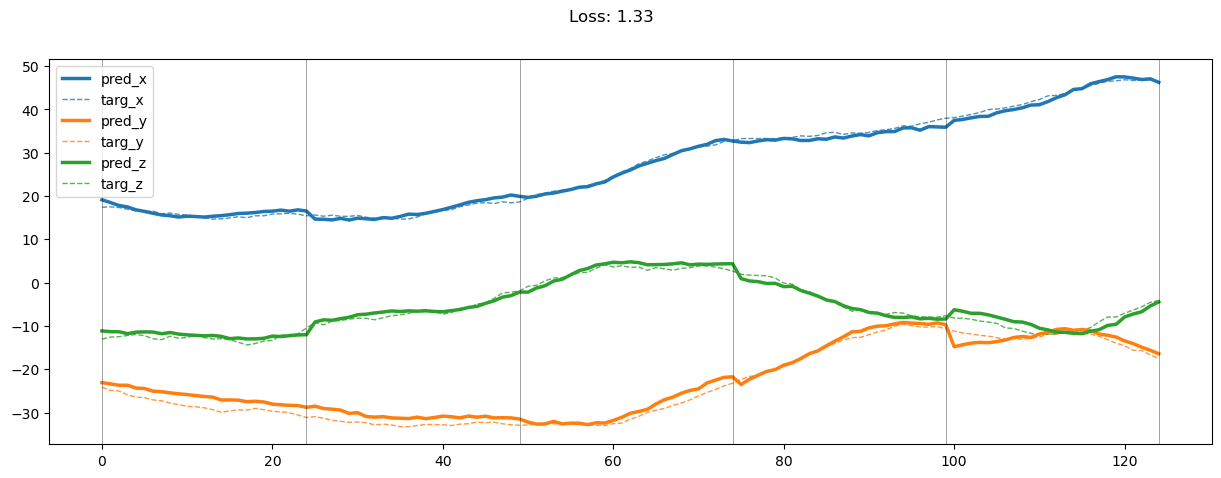

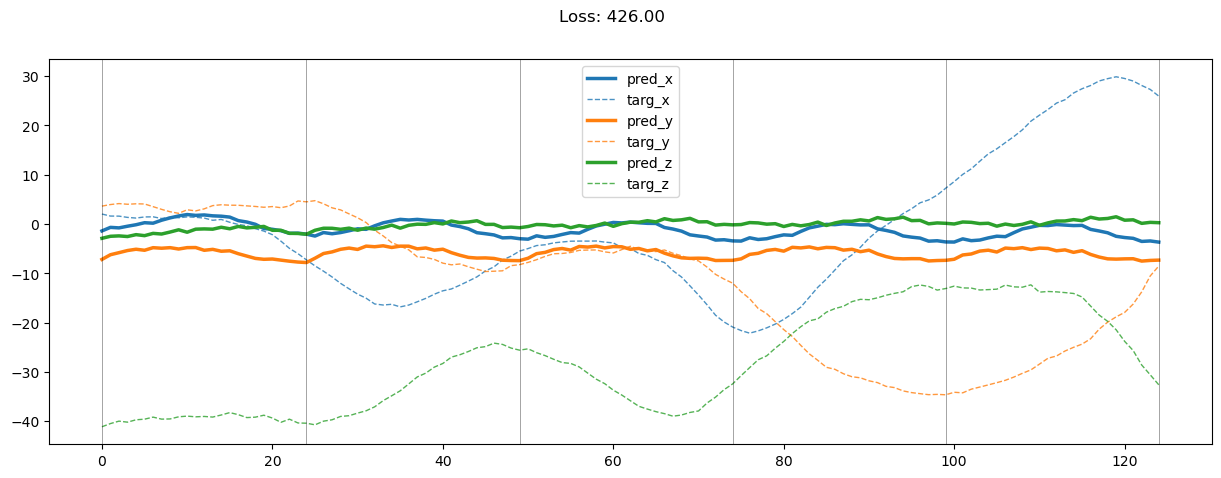

00599: train total loss:  3.648, pred loss:  3.648, valid total loss:  596.108, pred loss:  596.108


100%|██████████| 8/8 [00:00<00:00, 22.14it/s]


00600: train total loss:  3.460, pred loss:  3.460, valid total loss:  609.583, pred loss:  609.583


100%|██████████| 8/8 [00:00<00:00, 22.31it/s]


00601: train total loss:  3.345, pred loss:  3.345, valid total loss:  605.068, pred loss:  605.068


100%|██████████| 8/8 [00:00<00:00, 22.33it/s]


00602: train total loss:  3.199, pred loss:  3.199, valid total loss:  616.454, pred loss:  616.454


100%|██████████| 8/8 [00:00<00:00, 19.92it/s]


00603: train total loss:  3.154, pred loss:  3.154, valid total loss:  604.031, pred loss:  604.031


100%|██████████| 8/8 [00:00<00:00, 22.30it/s]


00604: train total loss:  2.999, pred loss:  2.999, valid total loss:  612.961, pred loss:  612.961


100%|██████████| 8/8 [00:00<00:00, 22.26it/s]


00605: train total loss:  3.124, pred loss:  3.124, valid total loss:  600.397, pred loss:  600.397


100%|██████████| 8/8 [00:00<00:00, 22.32it/s]


00606: train total loss:  3.176, pred loss:  3.176, valid total loss:  581.049, pred loss:  581.049


100%|██████████| 8/8 [00:00<00:00, 22.35it/s]


00607: train total loss:  3.116, pred loss:  3.116, valid total loss:  603.680, pred loss:  603.680


100%|██████████| 8/8 [00:00<00:00, 17.18it/s]


00608: train total loss:  3.136, pred loss:  3.136, valid total loss:  590.809, pred loss:  590.809


100%|██████████| 8/8 [00:00<00:00, 17.27it/s]


00609: train total loss:  2.954, pred loss:  2.954, valid total loss:  597.505, pred loss:  597.505


100%|██████████| 8/8 [00:00<00:00, 19.45it/s]


00610: train total loss:  2.745, pred loss:  2.745, valid total loss:  584.250, pred loss:  584.250


100%|██████████| 8/8 [00:00<00:00, 20.00it/s]


00611: train total loss:  2.830, pred loss:  2.830, valid total loss:  591.483, pred loss:  591.483


100%|██████████| 8/8 [00:00<00:00, 21.47it/s]


00612: train total loss:  2.757, pred loss:  2.757, valid total loss:  588.106, pred loss:  588.106


100%|██████████| 8/8 [00:00<00:00, 22.31it/s]


00613: train total loss:  2.995, pred loss:  2.995, valid total loss:  611.233, pred loss:  611.233


100%|██████████| 8/8 [00:00<00:00, 22.33it/s]


00614: train total loss:  2.988, pred loss:  2.988, valid total loss:  591.147, pred loss:  591.147


100%|██████████| 8/8 [00:00<00:00, 22.32it/s]


00615: train total loss:  2.978, pred loss:  2.978, valid total loss:  594.899, pred loss:  594.899


100%|██████████| 8/8 [00:00<00:00, 22.21it/s]


00616: train total loss:  2.887, pred loss:  2.887, valid total loss:  587.958, pred loss:  587.958


100%|██████████| 8/8 [00:00<00:00, 22.33it/s]


00617: train total loss:  2.881, pred loss:  2.881, valid total loss:  596.766, pred loss:  596.766


100%|██████████| 8/8 [00:00<00:00, 22.37it/s]


00618: train total loss:  2.734, pred loss:  2.734, valid total loss:  584.099, pred loss:  584.099


100%|██████████| 8/8 [00:00<00:00, 22.39it/s]


00619: train total loss:  2.681, pred loss:  2.681, valid total loss:  589.658, pred loss:  589.658


100%|██████████| 8/8 [00:00<00:00, 22.14it/s]


00620: train total loss:  2.811, pred loss:  2.811, valid total loss:  595.022, pred loss:  595.022


100%|██████████| 8/8 [00:00<00:00, 22.38it/s]


00621: train total loss:  2.634, pred loss:  2.634, valid total loss:  580.001, pred loss:  580.001


100%|██████████| 8/8 [00:00<00:00, 22.38it/s]


00622: train total loss:  2.862, pred loss:  2.862, valid total loss:  581.349, pred loss:  581.349


100%|██████████| 8/8 [00:00<00:00, 22.38it/s]


00623: train total loss:  2.603, pred loss:  2.603, valid total loss:  611.348, pred loss:  611.348


100%|██████████| 8/8 [00:00<00:00, 22.21it/s]


00624: train total loss:  2.706, pred loss:  2.706, valid total loss:  601.011, pred loss:  601.011


100%|██████████| 8/8 [00:00<00:00, 22.40it/s]


00625: train total loss:  2.688, pred loss:  2.688, valid total loss:  593.050, pred loss:  593.050


100%|██████████| 8/8 [00:00<00:00, 22.42it/s]


00626: train total loss:  2.769, pred loss:  2.769, valid total loss:  604.957, pred loss:  604.957


100%|██████████| 8/8 [00:00<00:00, 22.38it/s]


00627: train total loss:  2.998, pred loss:  2.998, valid total loss:  580.679, pred loss:  580.679


100%|██████████| 8/8 [00:00<00:00, 22.20it/s]


00628: train total loss:  2.737, pred loss:  2.737, valid total loss:  595.248, pred loss:  595.248


100%|██████████| 8/8 [00:00<00:00, 19.09it/s]


00629: train total loss:  2.844, pred loss:  2.844, valid total loss:  608.252, pred loss:  608.252


100%|██████████| 8/8 [00:00<00:00, 19.75it/s]


00630: train total loss:  2.971, pred loss:  2.971, valid total loss:  606.577, pred loss:  606.577


100%|██████████| 8/8 [00:00<00:00, 20.18it/s]


00631: train total loss:  3.138, pred loss:  3.138, valid total loss:  616.126, pred loss:  616.126


100%|██████████| 8/8 [00:00<00:00, 20.53it/s]


00632: train total loss:  3.403, pred loss:  3.403, valid total loss:  612.470, pred loss:  612.470


100%|██████████| 8/8 [00:00<00:00, 16.79it/s]


00633: train total loss:  3.106, pred loss:  3.106, valid total loss:  587.552, pred loss:  587.552


100%|██████████| 8/8 [00:00<00:00, 17.54it/s]


00634: train total loss:  3.077, pred loss:  3.077, valid total loss:  596.518, pred loss:  596.518


100%|██████████| 8/8 [00:00<00:00, 16.43it/s]


00635: train total loss:  2.838, pred loss:  2.838, valid total loss:  589.228, pred loss:  589.228


100%|██████████| 8/8 [00:00<00:00, 18.22it/s]


00636: train total loss:  2.929, pred loss:  2.929, valid total loss:  588.894, pred loss:  588.894


100%|██████████| 8/8 [00:00<00:00, 17.59it/s]


00637: train total loss:  2.764, pred loss:  2.764, valid total loss:  592.735, pred loss:  592.735


100%|██████████| 8/8 [00:00<00:00, 22.39it/s]


00638: train total loss:  2.819, pred loss:  2.819, valid total loss:  595.965, pred loss:  595.965


100%|██████████| 8/8 [00:00<00:00, 19.68it/s]


00639: train total loss:  2.831, pred loss:  2.831, valid total loss:  577.201, pred loss:  577.201


100%|██████████| 8/8 [00:00<00:00, 19.75it/s]


00640: train total loss:  2.979, pred loss:  2.979, valid total loss:  593.343, pred loss:  593.343


100%|██████████| 8/8 [00:00<00:00, 19.78it/s]


00641: train total loss:  3.014, pred loss:  3.014, valid total loss:  602.030, pred loss:  602.030


100%|██████████| 8/8 [00:00<00:00, 19.77it/s]


00642: train total loss:  2.851, pred loss:  2.851, valid total loss:  603.248, pred loss:  603.248


100%|██████████| 8/8 [00:00<00:00, 19.74it/s]


00643: train total loss:  2.740, pred loss:  2.740, valid total loss:  602.621, pred loss:  602.621


100%|██████████| 8/8 [00:00<00:00, 20.54it/s]


00644: train total loss:  2.811, pred loss:  2.811, valid total loss:  605.535, pred loss:  605.535


100%|██████████| 8/8 [00:00<00:00, 20.99it/s]


00645: train total loss:  2.903, pred loss:  2.903, valid total loss:  601.967, pred loss:  601.967


100%|██████████| 8/8 [00:00<00:00, 19.28it/s]


00646: train total loss:  3.125, pred loss:  3.125, valid total loss:  602.153, pred loss:  602.153


100%|██████████| 8/8 [00:00<00:00, 21.48it/s]


00647: train total loss:  3.657, pred loss:  3.657, valid total loss:  608.599, pred loss:  608.599


100%|██████████| 8/8 [00:00<00:00, 20.85it/s]


00648: train total loss:  3.473, pred loss:  3.473, valid total loss:  586.940, pred loss:  586.940


100%|██████████| 8/8 [00:00<00:00, 22.28it/s]


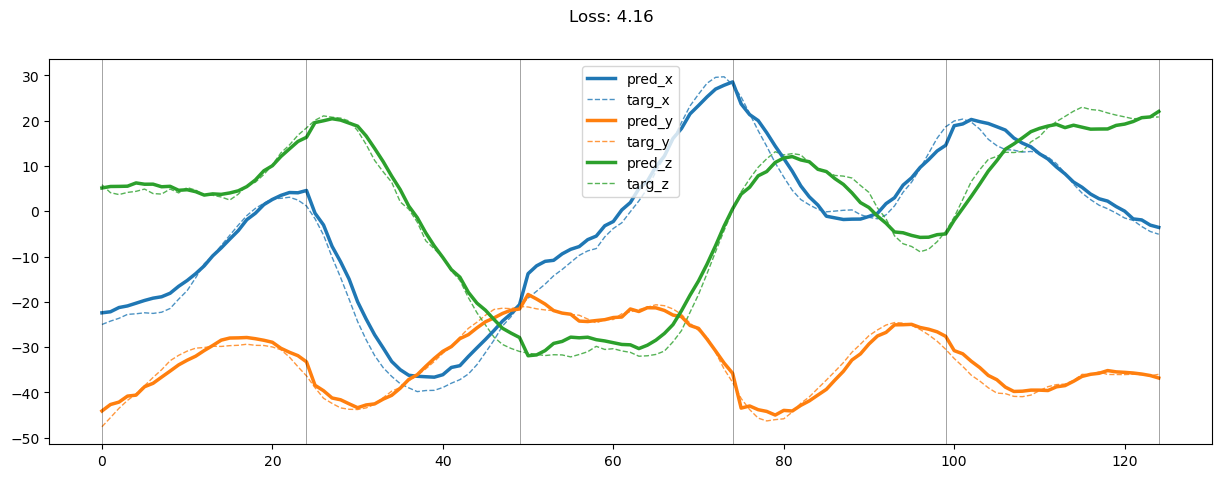

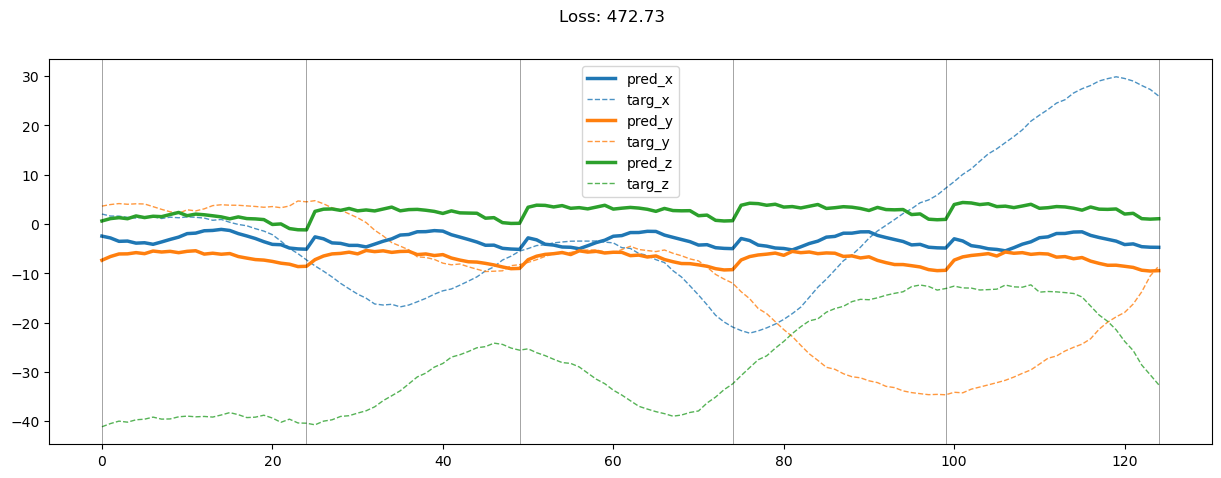

00649: train total loss:  3.488, pred loss:  3.488, valid total loss:  616.606, pred loss:  616.606


100%|██████████| 8/8 [00:00<00:00, 22.18it/s]


00650: train total loss:  3.361, pred loss:  3.361, valid total loss:  595.618, pred loss:  595.618


100%|██████████| 8/8 [00:00<00:00, 22.29it/s]


00651: train total loss:  3.292, pred loss:  3.292, valid total loss:  588.711, pred loss:  588.711


100%|██████████| 8/8 [00:00<00:00, 22.30it/s]


00652: train total loss:  3.370, pred loss:  3.370, valid total loss:  610.131, pred loss:  610.131


100%|██████████| 8/8 [00:00<00:00, 22.29it/s]


00653: train total loss:  3.453, pred loss:  3.453, valid total loss:  627.219, pred loss:  627.219


100%|██████████| 8/8 [00:00<00:00, 22.28it/s]


00654: train total loss:  3.770, pred loss:  3.770, valid total loss:  618.654, pred loss:  618.654


100%|██████████| 8/8 [00:00<00:00, 22.27it/s]


00655: train total loss:  3.353, pred loss:  3.353, valid total loss:  618.125, pred loss:  618.125


100%|██████████| 8/8 [00:00<00:00, 22.28it/s]


00656: train total loss:  3.049, pred loss:  3.049, valid total loss:  593.659, pred loss:  593.659


100%|██████████| 8/8 [00:00<00:00, 22.25it/s]


00657: train total loss:  3.103, pred loss:  3.103, valid total loss:  620.811, pred loss:  620.811


100%|██████████| 8/8 [00:00<00:00, 22.26it/s]


00658: train total loss:  3.233, pred loss:  3.233, valid total loss:  613.637, pred loss:  613.637


100%|██████████| 8/8 [00:00<00:00, 19.19it/s]


00659: train total loss:  3.694, pred loss:  3.694, valid total loss:  602.040, pred loss:  602.040


100%|██████████| 8/8 [00:00<00:00, 20.37it/s]


00660: train total loss:  3.045, pred loss:  3.045, valid total loss:  597.346, pred loss:  597.346


100%|██████████| 8/8 [00:00<00:00, 19.46it/s]


00661: train total loss:  2.796, pred loss:  2.796, valid total loss:  586.879, pred loss:  586.879


100%|██████████| 8/8 [00:00<00:00, 19.72it/s]


00662: train total loss:  2.740, pred loss:  2.740, valid total loss:  600.342, pred loss:  600.342


100%|██████████| 8/8 [00:00<00:00, 22.16it/s]


00663: train total loss:  3.095, pred loss:  3.095, valid total loss:  604.120, pred loss:  604.120


100%|██████████| 8/8 [00:00<00:00, 22.30it/s]


00664: train total loss:  3.128, pred loss:  3.128, valid total loss:  586.023, pred loss:  586.023


100%|██████████| 8/8 [00:00<00:00, 21.79it/s]


00665: train total loss:  3.056, pred loss:  3.056, valid total loss:  586.684, pred loss:  586.684


100%|██████████| 8/8 [00:00<00:00, 22.38it/s]


00666: train total loss:  2.728, pred loss:  2.728, valid total loss:  589.339, pred loss:  589.339


100%|██████████| 8/8 [00:00<00:00, 22.38it/s]


00667: train total loss:  2.923, pred loss:  2.923, valid total loss:  577.747, pred loss:  577.747


100%|██████████| 8/8 [00:00<00:00, 22.33it/s]


00668: train total loss:  2.777, pred loss:  2.777, valid total loss:  577.295, pred loss:  577.295


100%|██████████| 8/8 [00:00<00:00, 22.23it/s]


00669: train total loss:  2.901, pred loss:  2.901, valid total loss:  592.401, pred loss:  592.401


100%|██████████| 8/8 [00:00<00:00, 22.32it/s]


00670: train total loss:  2.848, pred loss:  2.848, valid total loss:  592.872, pred loss:  592.872


100%|██████████| 8/8 [00:00<00:00, 19.76it/s]


00671: train total loss:  2.801, pred loss:  2.801, valid total loss:  589.466, pred loss:  589.466


100%|██████████| 8/8 [00:00<00:00, 19.95it/s]


00672: train total loss:  2.890, pred loss:  2.890, valid total loss:  591.340, pred loss:  591.340


100%|██████████| 8/8 [00:00<00:00, 19.81it/s]


00673: train total loss:  3.113, pred loss:  3.113, valid total loss:  598.298, pred loss:  598.298


100%|██████████| 8/8 [00:00<00:00, 19.95it/s]


00674: train total loss:  2.778, pred loss:  2.778, valid total loss:  596.689, pred loss:  596.689


100%|██████████| 8/8 [00:00<00:00, 22.25it/s]


00675: train total loss:  2.842, pred loss:  2.842, valid total loss:  602.753, pred loss:  602.753


100%|██████████| 8/8 [00:00<00:00, 22.32it/s]


00676: train total loss:  2.699, pred loss:  2.699, valid total loss:  593.236, pred loss:  593.236


100%|██████████| 8/8 [00:00<00:00, 22.01it/s]


00677: train total loss:  2.861, pred loss:  2.861, valid total loss:  581.293, pred loss:  581.293


100%|██████████| 8/8 [00:00<00:00, 22.24it/s]


00678: train total loss:  3.259, pred loss:  3.259, valid total loss:  585.505, pred loss:  585.505


100%|██████████| 8/8 [00:00<00:00, 22.22it/s]


00679: train total loss:  3.312, pred loss:  3.312, valid total loss:  601.300, pred loss:  601.300


100%|██████████| 8/8 [00:00<00:00, 22.32it/s]


00680: train total loss:  3.446, pred loss:  3.446, valid total loss:  598.436, pred loss:  598.436


100%|██████████| 8/8 [00:00<00:00, 22.11it/s]


00681: train total loss:  3.260, pred loss:  3.260, valid total loss:  615.996, pred loss:  615.996


100%|██████████| 8/8 [00:00<00:00, 19.55it/s]


00682: train total loss:  3.796, pred loss:  3.796, valid total loss:  610.265, pred loss:  610.265


100%|██████████| 8/8 [00:00<00:00, 19.76it/s]


00683: train total loss:  3.405, pred loss:  3.405, valid total loss:  591.434, pred loss:  591.434


100%|██████████| 8/8 [00:00<00:00, 19.92it/s]


00684: train total loss:  4.000, pred loss:  4.000, valid total loss:  606.648, pred loss:  606.648


100%|██████████| 8/8 [00:00<00:00, 19.58it/s]


00685: train total loss:  3.410, pred loss:  3.410, valid total loss:  607.157, pred loss:  607.157


100%|██████████| 8/8 [00:00<00:00, 19.53it/s]


00686: train total loss:  3.270, pred loss:  3.270, valid total loss:  594.788, pred loss:  594.788


100%|██████████| 8/8 [00:00<00:00, 19.75it/s]


00687: train total loss:  2.855, pred loss:  2.855, valid total loss:  613.058, pred loss:  613.058


100%|██████████| 8/8 [00:00<00:00, 19.72it/s]


00688: train total loss:  2.789, pred loss:  2.789, valid total loss:  579.929, pred loss:  579.929


100%|██████████| 8/8 [00:00<00:00, 19.81it/s]


00689: train total loss:  2.781, pred loss:  2.781, valid total loss:  565.410, pred loss:  565.410


100%|██████████| 8/8 [00:00<00:00, 19.86it/s]


00690: train total loss:  2.749, pred loss:  2.749, valid total loss:  584.796, pred loss:  584.796


100%|██████████| 8/8 [00:00<00:00, 20.62it/s]


00691: train total loss:  2.856, pred loss:  2.856, valid total loss:  577.543, pred loss:  577.543


100%|██████████| 8/8 [00:00<00:00, 19.63it/s]


00692: train total loss:  2.900, pred loss:  2.900, valid total loss:  597.811, pred loss:  597.811


100%|██████████| 8/8 [00:00<00:00, 20.37it/s]


00693: train total loss:  2.827, pred loss:  2.827, valid total loss:  569.273, pred loss:  569.273


100%|██████████| 8/8 [00:00<00:00, 20.34it/s]


00694: train total loss:  2.844, pred loss:  2.844, valid total loss:  590.026, pred loss:  590.026


100%|██████████| 8/8 [00:00<00:00, 20.13it/s]


00695: train total loss:  2.591, pred loss:  2.591, valid total loss:  602.880, pred loss:  602.880


100%|██████████| 8/8 [00:00<00:00, 19.69it/s]


00696: train total loss:  2.700, pred loss:  2.700, valid total loss:  604.620, pred loss:  604.620


100%|██████████| 8/8 [00:00<00:00, 20.51it/s]


00697: train total loss:  2.703, pred loss:  2.703, valid total loss:  578.097, pred loss:  578.097


100%|██████████| 8/8 [00:00<00:00, 20.84it/s]


00698: train total loss:  2.938, pred loss:  2.938, valid total loss:  605.433, pred loss:  605.433


100%|██████████| 8/8 [00:00<00:00, 20.89it/s]


00699: train total loss:  3.094, pred loss:  3.094, valid total loss:  593.015, pred loss:  593.015


100%|██████████| 8/8 [00:00<00:00, 18.23it/s]


00700: train total loss:  2.941, pred loss:  2.941, valid total loss:  582.601, pred loss:  582.601


100%|██████████| 8/8 [00:00<00:00, 20.60it/s]


00701: train total loss:  2.864, pred loss:  2.864, valid total loss:  590.337, pred loss:  590.337


100%|██████████| 8/8 [00:00<00:00, 20.90it/s]


00702: train total loss:  3.095, pred loss:  3.095, valid total loss:  596.110, pred loss:  596.110


100%|██████████| 8/8 [00:00<00:00, 19.89it/s]


00703: train total loss:  3.034, pred loss:  3.034, valid total loss:  595.071, pred loss:  595.071


100%|██████████| 8/8 [00:00<00:00, 21.00it/s]


00704: train total loss:  3.235, pred loss:  3.235, valid total loss:  597.935, pred loss:  597.935


100%|██████████| 8/8 [00:00<00:00, 22.23it/s]


00705: train total loss:  2.997, pred loss:  2.997, valid total loss:  600.526, pred loss:  600.526


100%|██████████| 8/8 [00:00<00:00, 22.34it/s]


00706: train total loss:  2.555, pred loss:  2.555, valid total loss:  619.040, pred loss:  619.040


100%|██████████| 8/8 [00:00<00:00, 22.16it/s]


00707: train total loss:  2.492, pred loss:  2.492, valid total loss:  595.839, pred loss:  595.839


100%|██████████| 8/8 [00:00<00:00, 22.30it/s]


00708: train total loss:  2.288, pred loss:  2.288, valid total loss:  571.238, pred loss:  571.238


100%|██████████| 8/8 [00:00<00:00, 22.31it/s]


00709: train total loss:  2.278, pred loss:  2.278, valid total loss:  595.391, pred loss:  595.391


100%|██████████| 8/8 [00:00<00:00, 20.37it/s]


00710: train total loss:  2.309, pred loss:  2.309, valid total loss:  580.319, pred loss:  580.319


100%|██████████| 8/8 [00:00<00:00, 19.86it/s]


00711: train total loss:  2.196, pred loss:  2.196, valid total loss:  594.314, pred loss:  594.314


100%|██████████| 8/8 [00:00<00:00, 20.72it/s]


00712: train total loss:  2.299, pred loss:  2.299, valid total loss:  577.868, pred loss:  577.868


100%|██████████| 8/8 [00:00<00:00, 20.81it/s]


00713: train total loss:  2.304, pred loss:  2.304, valid total loss:  594.673, pred loss:  594.673


100%|██████████| 8/8 [00:00<00:00, 20.41it/s]


00714: train total loss:  2.382, pred loss:  2.382, valid total loss:  587.575, pred loss:  587.575


100%|██████████| 8/8 [00:00<00:00, 20.34it/s]


00715: train total loss:  2.447, pred loss:  2.447, valid total loss:  603.690, pred loss:  603.690


100%|██████████| 8/8 [00:00<00:00, 20.66it/s]


00716: train total loss:  2.528, pred loss:  2.528, valid total loss:  598.551, pred loss:  598.551


100%|██████████| 8/8 [00:00<00:00, 20.89it/s]


00717: train total loss:  2.434, pred loss:  2.434, valid total loss:  609.522, pred loss:  609.522


100%|██████████| 8/8 [00:00<00:00, 18.33it/s]


00718: train total loss:  2.412, pred loss:  2.412, valid total loss:  589.463, pred loss:  589.463


100%|██████████| 8/8 [00:00<00:00, 20.22it/s]


00719: train total loss:  2.588, pred loss:  2.588, valid total loss:  581.558, pred loss:  581.558


100%|██████████| 8/8 [00:00<00:00, 20.33it/s]


00720: train total loss:  2.693, pred loss:  2.693, valid total loss:  587.524, pred loss:  587.524


100%|██████████| 8/8 [00:00<00:00, 19.97it/s]


00721: train total loss:  2.835, pred loss:  2.835, valid total loss:  581.986, pred loss:  581.986


100%|██████████| 8/8 [00:00<00:00, 20.24it/s]


00722: train total loss:  2.601, pred loss:  2.601, valid total loss:  595.960, pred loss:  595.960


100%|██████████| 8/8 [00:00<00:00, 20.07it/s]


00723: train total loss:  2.725, pred loss:  2.725, valid total loss:  584.054, pred loss:  584.054


100%|██████████| 8/8 [00:00<00:00, 20.69it/s]


00724: train total loss:  2.748, pred loss:  2.748, valid total loss:  596.048, pred loss:  596.048


100%|██████████| 8/8 [00:00<00:00, 20.30it/s]


00725: train total loss:  2.892, pred loss:  2.892, valid total loss:  591.704, pred loss:  591.704


100%|██████████| 8/8 [00:00<00:00, 19.76it/s]


00726: train total loss:  2.745, pred loss:  2.745, valid total loss:  621.809, pred loss:  621.809


100%|██████████| 8/8 [00:00<00:00, 18.66it/s]


00727: train total loss:  2.890, pred loss:  2.890, valid total loss:  608.001, pred loss:  608.001


100%|██████████| 8/8 [00:00<00:00, 19.84it/s]


00728: train total loss:  2.644, pred loss:  2.644, valid total loss:  587.060, pred loss:  587.060


100%|██████████| 8/8 [00:00<00:00, 20.40it/s]


00729: train total loss:  2.953, pred loss:  2.953, valid total loss:  598.981, pred loss:  598.981


100%|██████████| 8/8 [00:00<00:00, 21.29it/s]


00730: train total loss:  3.053, pred loss:  3.053, valid total loss:  587.388, pred loss:  587.388


100%|██████████| 8/8 [00:00<00:00, 20.29it/s]


00731: train total loss:  3.265, pred loss:  3.265, valid total loss:  581.419, pred loss:  581.419


100%|██████████| 8/8 [00:00<00:00, 20.17it/s]


00732: train total loss:  3.548, pred loss:  3.548, valid total loss:  608.713, pred loss:  608.713


100%|██████████| 8/8 [00:00<00:00, 20.36it/s]


00733: train total loss:  3.563, pred loss:  3.563, valid total loss:  617.531, pred loss:  617.531


100%|██████████| 8/8 [00:00<00:00, 20.11it/s]


00734: train total loss:  3.006, pred loss:  3.006, valid total loss:  601.091, pred loss:  601.091


100%|██████████| 8/8 [00:00<00:00, 19.19it/s]


00735: train total loss:  2.723, pred loss:  2.723, valid total loss:  616.459, pred loss:  616.459


100%|██████████| 8/8 [00:00<00:00, 20.64it/s]


00736: train total loss:  2.856, pred loss:  2.856, valid total loss:  598.359, pred loss:  598.359


100%|██████████| 8/8 [00:00<00:00, 19.92it/s]


00737: train total loss:  3.181, pred loss:  3.181, valid total loss:  619.671, pred loss:  619.671


100%|██████████| 8/8 [00:00<00:00, 20.66it/s]


00738: train total loss:  2.909, pred loss:  2.909, valid total loss:  596.141, pred loss:  596.141


100%|██████████| 8/8 [00:00<00:00, 20.51it/s]


00739: train total loss:  3.105, pred loss:  3.105, valid total loss:  599.905, pred loss:  599.905


100%|██████████| 8/8 [00:00<00:00, 21.03it/s]


00740: train total loss:  4.402, pred loss:  4.402, valid total loss:  555.605, pred loss:  555.605


100%|██████████| 8/8 [00:00<00:00, 20.33it/s]


00741: train total loss:  4.002, pred loss:  4.002, valid total loss:  591.422, pred loss:  591.422


100%|██████████| 8/8 [00:00<00:00, 20.58it/s]


00742: train total loss:  4.212, pred loss:  4.212, valid total loss:  547.010, pred loss:  547.010


100%|██████████| 8/8 [00:00<00:00, 20.46it/s]


00743: train total loss:  4.071, pred loss:  4.071, valid total loss:  596.957, pred loss:  596.957


100%|██████████| 8/8 [00:00<00:00, 20.18it/s]


00744: train total loss:  4.200, pred loss:  4.200, valid total loss:  582.944, pred loss:  582.944


100%|██████████| 8/8 [00:00<00:00, 20.34it/s]


00745: train total loss:  4.098, pred loss:  4.098, valid total loss:  590.434, pred loss:  590.434


100%|██████████| 8/8 [00:00<00:00, 20.89it/s]


00746: train total loss:  3.605, pred loss:  3.605, valid total loss:  599.536, pred loss:  599.536


100%|██████████| 8/8 [00:00<00:00, 20.33it/s]


00747: train total loss:  4.154, pred loss:  4.154, valid total loss:  588.337, pred loss:  588.337


100%|██████████| 8/8 [00:00<00:00, 19.96it/s]


00748: train total loss:  3.761, pred loss:  3.761, valid total loss:  585.581, pred loss:  585.581


100%|██████████| 8/8 [00:00<00:00, 19.99it/s]


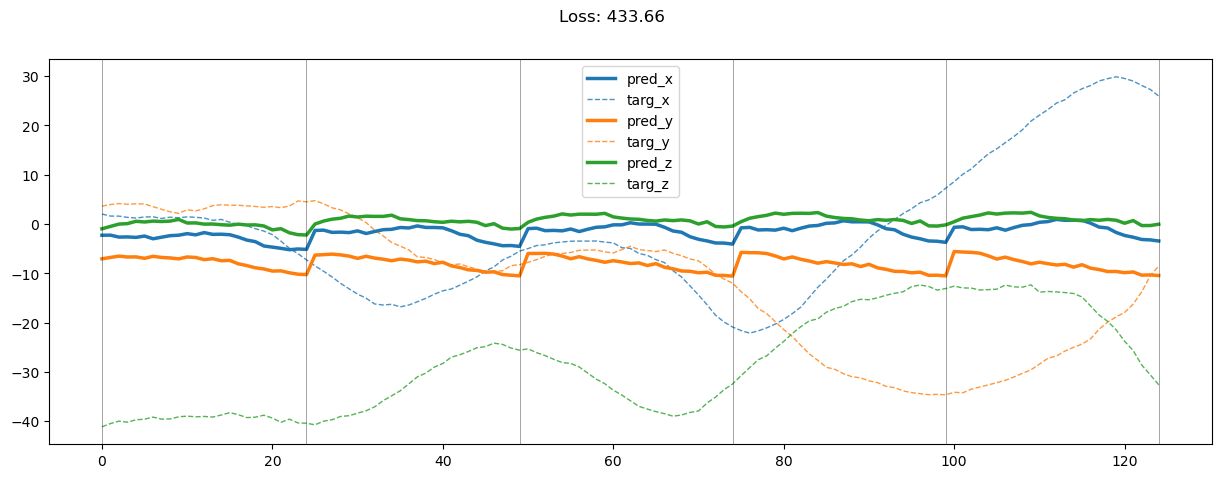

00749: train total loss:  3.505, pred loss:  3.505, valid total loss:  600.024, pred loss:  600.024


100%|██████████| 8/8 [00:00<00:00, 18.77it/s]


00750: train total loss:  2.949, pred loss:  2.949, valid total loss:  591.353, pred loss:  591.353


100%|██████████| 8/8 [00:00<00:00, 22.16it/s]


00751: train total loss:  2.808, pred loss:  2.808, valid total loss:  596.358, pred loss:  596.358


100%|██████████| 8/8 [00:00<00:00, 20.62it/s]


00752: train total loss:  2.697, pred loss:  2.697, valid total loss:  610.562, pred loss:  610.562


100%|██████████| 8/8 [00:00<00:00, 19.99it/s]


00753: train total loss:  2.745, pred loss:  2.745, valid total loss:  586.194, pred loss:  586.194


100%|██████████| 8/8 [00:00<00:00, 19.87it/s]


00754: train total loss:  2.630, pred loss:  2.630, valid total loss:  591.082, pred loss:  591.082


100%|██████████| 8/8 [00:00<00:00, 17.87it/s]


00755: train total loss:  2.849, pred loss:  2.849, valid total loss:  592.920, pred loss:  592.920


100%|██████████| 8/8 [00:00<00:00, 22.38it/s]


00756: train total loss:  2.940, pred loss:  2.940, valid total loss:  592.794, pred loss:  592.794


100%|██████████| 8/8 [00:00<00:00, 22.40it/s]


00757: train total loss:  2.963, pred loss:  2.963, valid total loss:  601.970, pred loss:  601.970


100%|██████████| 8/8 [00:00<00:00, 22.39it/s]


00758: train total loss:  2.796, pred loss:  2.796, valid total loss:  609.052, pred loss:  609.052


100%|██████████| 8/8 [00:00<00:00, 19.70it/s]


00759: train total loss:  2.823, pred loss:  2.823, valid total loss:  588.958, pred loss:  588.958


100%|██████████| 8/8 [00:00<00:00, 22.38it/s]


00760: train total loss:  2.823, pred loss:  2.823, valid total loss:  607.461, pred loss:  607.461


100%|██████████| 8/8 [00:00<00:00, 22.35it/s]


00761: train total loss:  2.959, pred loss:  2.959, valid total loss:  629.344, pred loss:  629.344


100%|██████████| 8/8 [00:00<00:00, 22.38it/s]


00762: train total loss:  2.846, pred loss:  2.846, valid total loss:  599.249, pred loss:  599.249


100%|██████████| 8/8 [00:00<00:00, 19.62it/s]


00763: train total loss:  2.816, pred loss:  2.816, valid total loss:  616.877, pred loss:  616.877


100%|██████████| 8/8 [00:00<00:00, 17.74it/s]


00764: train total loss:  2.686, pred loss:  2.686, valid total loss:  606.833, pred loss:  606.833


100%|██████████| 8/8 [00:00<00:00, 22.38it/s]


00765: train total loss:  2.594, pred loss:  2.594, valid total loss:  606.777, pred loss:  606.777


100%|██████████| 8/8 [00:00<00:00, 22.38it/s]


00766: train total loss:  2.840, pred loss:  2.840, valid total loss:  633.237, pred loss:  633.237


100%|██████████| 8/8 [00:00<00:00, 22.37it/s]


00767: train total loss:  2.893, pred loss:  2.893, valid total loss:  612.178, pred loss:  612.178


100%|██████████| 8/8 [00:00<00:00, 22.39it/s]


00768: train total loss:  2.922, pred loss:  2.922, valid total loss:  607.689, pred loss:  607.689


100%|██████████| 8/8 [00:00<00:00, 22.33it/s]


00769: train total loss:  2.970, pred loss:  2.970, valid total loss:  616.916, pred loss:  616.916


100%|██████████| 8/8 [00:00<00:00, 22.34it/s]


00770: train total loss:  2.675, pred loss:  2.675, valid total loss:  607.836, pred loss:  607.836


100%|██████████| 8/8 [00:00<00:00, 18.70it/s]


00771: train total loss:  2.849, pred loss:  2.849, valid total loss:  612.675, pred loss:  612.675


100%|██████████| 8/8 [00:00<00:00, 20.50it/s]


00772: train total loss:  2.694, pred loss:  2.694, valid total loss:  611.942, pred loss:  611.942


100%|██████████| 8/8 [00:00<00:00, 19.92it/s]


00773: train total loss:  2.493, pred loss:  2.493, valid total loss:  603.236, pred loss:  603.236


100%|██████████| 8/8 [00:00<00:00, 19.73it/s]


00774: train total loss:  2.307, pred loss:  2.307, valid total loss:  632.800, pred loss:  632.800


100%|██████████| 8/8 [00:00<00:00, 19.90it/s]


00775: train total loss:  2.232, pred loss:  2.232, valid total loss:  592.003, pred loss:  592.003


100%|██████████| 8/8 [00:00<00:00, 19.84it/s]


00776: train total loss:  2.258, pred loss:  2.258, valid total loss:  593.868, pred loss:  593.868


100%|██████████| 8/8 [00:00<00:00, 20.82it/s]


00777: train total loss:  2.190, pred loss:  2.190, valid total loss:  581.340, pred loss:  581.340


100%|██████████| 8/8 [00:00<00:00, 20.23it/s]


00778: train total loss:  2.281, pred loss:  2.281, valid total loss:  596.642, pred loss:  596.642


100%|██████████| 8/8 [00:00<00:00, 20.73it/s]


00779: train total loss:  2.178, pred loss:  2.178, valid total loss:  601.309, pred loss:  601.309


100%|██████████| 8/8 [00:00<00:00, 21.19it/s]


00780: train total loss:  2.195, pred loss:  2.195, valid total loss:  608.532, pred loss:  608.532


100%|██████████| 8/8 [00:00<00:00, 21.13it/s]


00781: train total loss:  2.265, pred loss:  2.265, valid total loss:  617.669, pred loss:  617.669


100%|██████████| 8/8 [00:00<00:00, 20.86it/s]


00782: train total loss:  2.376, pred loss:  2.376, valid total loss:  603.957, pred loss:  603.957


100%|██████████| 8/8 [00:00<00:00, 20.92it/s]


00783: train total loss:  2.310, pred loss:  2.310, valid total loss:  602.337, pred loss:  602.337


100%|██████████| 8/8 [00:00<00:00, 21.09it/s]


00784: train total loss:  2.485, pred loss:  2.485, valid total loss:  605.829, pred loss:  605.829


100%|██████████| 8/8 [00:00<00:00, 19.83it/s]


00785: train total loss:  2.582, pred loss:  2.582, valid total loss:  605.252, pred loss:  605.252


100%|██████████| 8/8 [00:00<00:00, 20.32it/s]


00786: train total loss:  2.429, pred loss:  2.429, valid total loss:  594.326, pred loss:  594.326


100%|██████████| 8/8 [00:00<00:00, 20.30it/s]


00787: train total loss:  2.199, pred loss:  2.199, valid total loss:  595.291, pred loss:  595.291


100%|██████████| 8/8 [00:00<00:00, 17.73it/s]


00788: train total loss:  2.091, pred loss:  2.091, valid total loss:  606.169, pred loss:  606.169


100%|██████████| 8/8 [00:00<00:00, 21.42it/s]


00789: train total loss:  2.141, pred loss:  2.141, valid total loss:  592.435, pred loss:  592.435


100%|██████████| 8/8 [00:00<00:00, 17.96it/s]


00790: train total loss:  2.191, pred loss:  2.191, valid total loss:  603.986, pred loss:  603.986


100%|██████████| 8/8 [00:00<00:00, 19.95it/s]


00791: train total loss:  2.340, pred loss:  2.340, valid total loss:  599.258, pred loss:  599.258


100%|██████████| 8/8 [00:00<00:00, 19.84it/s]


00792: train total loss:  2.559, pred loss:  2.559, valid total loss:  604.203, pred loss:  604.203


100%|██████████| 8/8 [00:00<00:00, 19.49it/s]


00793: train total loss:  2.402, pred loss:  2.402, valid total loss:  591.025, pred loss:  591.025


100%|██████████| 8/8 [00:00<00:00, 19.64it/s]


00794: train total loss:  2.240, pred loss:  2.240, valid total loss:  613.018, pred loss:  613.018


100%|██████████| 8/8 [00:00<00:00, 20.65it/s]


00795: train total loss:  2.320, pred loss:  2.320, valid total loss:  590.528, pred loss:  590.528


100%|██████████| 8/8 [00:00<00:00, 20.93it/s]


00796: train total loss:  2.227, pred loss:  2.227, valid total loss:  589.592, pred loss:  589.592


100%|██████████| 8/8 [00:00<00:00, 20.22it/s]


00797: train total loss:  2.132, pred loss:  2.132, valid total loss:  589.692, pred loss:  589.692


100%|██████████| 8/8 [00:00<00:00, 20.38it/s]


00798: train total loss:  2.244, pred loss:  2.244, valid total loss:  575.653, pred loss:  575.653


100%|██████████| 8/8 [00:00<00:00, 20.64it/s]


00799: train total loss:  2.341, pred loss:  2.341, valid total loss:  583.375, pred loss:  583.375


100%|██████████| 8/8 [00:00<00:00, 18.10it/s]


00800: train total loss:  2.332, pred loss:  2.332, valid total loss:  567.869, pred loss:  567.869


100%|██████████| 8/8 [00:00<00:00, 20.31it/s]


00801: train total loss:  2.328, pred loss:  2.328, valid total loss:  589.478, pred loss:  589.478


100%|██████████| 8/8 [00:00<00:00, 20.05it/s]


00802: train total loss:  2.548, pred loss:  2.548, valid total loss:  571.240, pred loss:  571.240


100%|██████████| 8/8 [00:00<00:00, 19.93it/s]


00803: train total loss:  2.799, pred loss:  2.799, valid total loss:  597.132, pred loss:  597.132


100%|██████████| 8/8 [00:00<00:00, 19.60it/s]


00804: train total loss:  2.577, pred loss:  2.577, valid total loss:  602.139, pred loss:  602.139


100%|██████████| 8/8 [00:00<00:00, 19.80it/s]


00805: train total loss:  2.326, pred loss:  2.326, valid total loss:  596.427, pred loss:  596.427


100%|██████████| 8/8 [00:00<00:00, 19.98it/s]


00806: train total loss:  2.470, pred loss:  2.470, valid total loss:  595.145, pred loss:  595.145


100%|██████████| 8/8 [00:00<00:00, 20.20it/s]


00807: train total loss:  2.557, pred loss:  2.557, valid total loss:  602.515, pred loss:  602.515


100%|██████████| 8/8 [00:00<00:00, 19.71it/s]


00808: train total loss:  2.338, pred loss:  2.338, valid total loss:  595.859, pred loss:  595.859


100%|██████████| 8/8 [00:00<00:00, 21.45it/s]


00809: train total loss:  2.121, pred loss:  2.121, valid total loss:  570.899, pred loss:  570.899


100%|██████████| 8/8 [00:00<00:00, 20.91it/s]


00810: train total loss:  2.181, pred loss:  2.181, valid total loss:  589.534, pred loss:  589.534


100%|██████████| 8/8 [00:00<00:00, 19.43it/s]


00811: train total loss:  2.249, pred loss:  2.249, valid total loss:  603.917, pred loss:  603.917


100%|██████████| 8/8 [00:00<00:00, 20.04it/s]


00812: train total loss:  2.269, pred loss:  2.269, valid total loss:  607.064, pred loss:  607.064


100%|██████████| 8/8 [00:00<00:00, 20.47it/s]


00813: train total loss:  2.212, pred loss:  2.212, valid total loss:  596.096, pred loss:  596.096


100%|██████████| 8/8 [00:00<00:00, 20.39it/s]


00814: train total loss:  2.437, pred loss:  2.437, valid total loss:  609.754, pred loss:  609.754


100%|██████████| 8/8 [00:00<00:00, 19.79it/s]


00815: train total loss:  2.318, pred loss:  2.318, valid total loss:  602.707, pred loss:  602.707


100%|██████████| 8/8 [00:00<00:00, 20.18it/s]


00816: train total loss:  2.248, pred loss:  2.248, valid total loss:  594.249, pred loss:  594.249


100%|██████████| 8/8 [00:00<00:00, 20.42it/s]


00817: train total loss:  2.260, pred loss:  2.260, valid total loss:  606.350, pred loss:  606.350


100%|██████████| 8/8 [00:00<00:00, 20.79it/s]


00818: train total loss:  2.274, pred loss:  2.274, valid total loss:  582.837, pred loss:  582.837


100%|██████████| 8/8 [00:00<00:00, 19.87it/s]


00819: train total loss:  2.336, pred loss:  2.336, valid total loss:  589.409, pred loss:  589.409


100%|██████████| 8/8 [00:00<00:00, 21.32it/s]


00820: train total loss:  2.312, pred loss:  2.312, valid total loss:  578.599, pred loss:  578.599


100%|██████████| 8/8 [00:00<00:00, 19.51it/s]


00821: train total loss:  2.048, pred loss:  2.048, valid total loss:  590.613, pred loss:  590.613


100%|██████████| 8/8 [00:00<00:00, 20.60it/s]


00822: train total loss:  2.174, pred loss:  2.174, valid total loss:  574.625, pred loss:  574.625


100%|██████████| 8/8 [00:00<00:00, 22.27it/s]


00823: train total loss:  2.255, pred loss:  2.255, valid total loss:  605.623, pred loss:  605.623


100%|██████████| 8/8 [00:00<00:00, 22.28it/s]


00824: train total loss:  2.119, pred loss:  2.119, valid total loss:  588.680, pred loss:  588.680


100%|██████████| 8/8 [00:00<00:00, 22.31it/s]


00825: train total loss:  2.246, pred loss:  2.246, valid total loss:  589.269, pred loss:  589.269


100%|██████████| 8/8 [00:00<00:00, 22.31it/s]


00826: train total loss:  2.350, pred loss:  2.350, valid total loss:  591.760, pred loss:  591.760


100%|██████████| 8/8 [00:00<00:00, 22.25it/s]


00827: train total loss:  2.220, pred loss:  2.220, valid total loss:  607.486, pred loss:  607.486


100%|██████████| 8/8 [00:00<00:00, 22.27it/s]


00828: train total loss:  2.145, pred loss:  2.145, valid total loss:  604.345, pred loss:  604.345


100%|██████████| 8/8 [00:00<00:00, 22.26it/s]


00829: train total loss:  2.213, pred loss:  2.213, valid total loss:  601.257, pred loss:  601.257


100%|██████████| 8/8 [00:00<00:00, 22.31it/s]


00830: train total loss:  2.273, pred loss:  2.273, valid total loss:  591.337, pred loss:  591.337


100%|██████████| 8/8 [00:00<00:00, 17.53it/s]


00831: train total loss:  2.242, pred loss:  2.242, valid total loss:  592.890, pred loss:  592.890


100%|██████████| 8/8 [00:00<00:00, 19.52it/s]


00832: train total loss:  2.389, pred loss:  2.389, valid total loss:  607.009, pred loss:  607.009


100%|██████████| 8/8 [00:00<00:00, 19.47it/s]


00833: train total loss:  2.764, pred loss:  2.764, valid total loss:  604.732, pred loss:  604.732


100%|██████████| 8/8 [00:00<00:00, 19.26it/s]


00834: train total loss:  2.655, pred loss:  2.655, valid total loss:  619.458, pred loss:  619.458


100%|██████████| 8/8 [00:00<00:00, 17.14it/s]


00835: train total loss:  2.409, pred loss:  2.409, valid total loss:  584.662, pred loss:  584.662


100%|██████████| 8/8 [00:00<00:00, 17.12it/s]


00836: train total loss:  2.288, pred loss:  2.288, valid total loss:  613.487, pred loss:  613.487


100%|██████████| 8/8 [00:00<00:00, 20.13it/s]


00837: train total loss:  2.196, pred loss:  2.196, valid total loss:  588.889, pred loss:  588.889


100%|██████████| 8/8 [00:00<00:00, 20.18it/s]


00838: train total loss:  2.279, pred loss:  2.279, valid total loss:  612.740, pred loss:  612.740


100%|██████████| 8/8 [00:00<00:00, 19.93it/s]


00839: train total loss:  2.485, pred loss:  2.485, valid total loss:  575.263, pred loss:  575.263


100%|██████████| 8/8 [00:00<00:00, 19.52it/s]


00840: train total loss:  2.595, pred loss:  2.595, valid total loss:  592.737, pred loss:  592.737


100%|██████████| 8/8 [00:00<00:00, 19.43it/s]


00841: train total loss:  2.701, pred loss:  2.701, valid total loss:  599.190, pred loss:  599.190


100%|██████████| 8/8 [00:00<00:00, 19.96it/s]


00842: train total loss:  2.756, pred loss:  2.756, valid total loss:  579.782, pred loss:  579.782


100%|██████████| 8/8 [00:00<00:00, 19.71it/s]


00843: train total loss:  2.728, pred loss:  2.728, valid total loss:  584.645, pred loss:  584.645


100%|██████████| 8/8 [00:00<00:00, 19.95it/s]


00844: train total loss:  2.587, pred loss:  2.587, valid total loss:  605.874, pred loss:  605.874


100%|██████████| 8/8 [00:00<00:00, 21.63it/s]


00845: train total loss:  2.325, pred loss:  2.325, valid total loss:  608.655, pred loss:  608.655


100%|██████████| 8/8 [00:00<00:00, 22.23it/s]


00846: train total loss:  2.269, pred loss:  2.269, valid total loss:  583.757, pred loss:  583.757


100%|██████████| 8/8 [00:00<00:00, 22.27it/s]


00847: train total loss:  2.308, pred loss:  2.308, valid total loss:  601.375, pred loss:  601.375


100%|██████████| 8/8 [00:00<00:00, 22.26it/s]


00848: train total loss:  2.215, pred loss:  2.215, valid total loss:  584.718, pred loss:  584.718


100%|██████████| 8/8 [00:00<00:00, 22.11it/s]


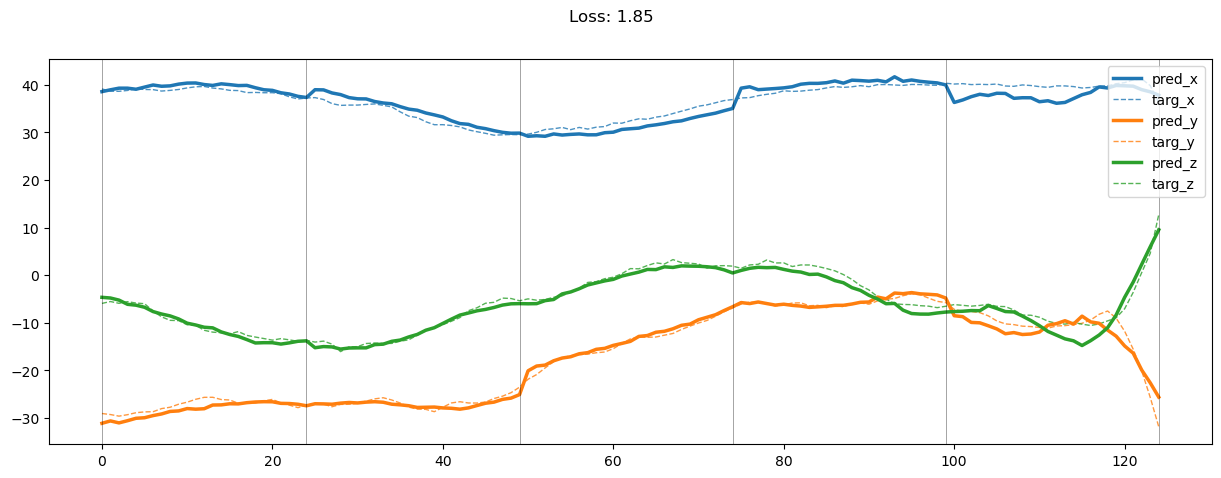

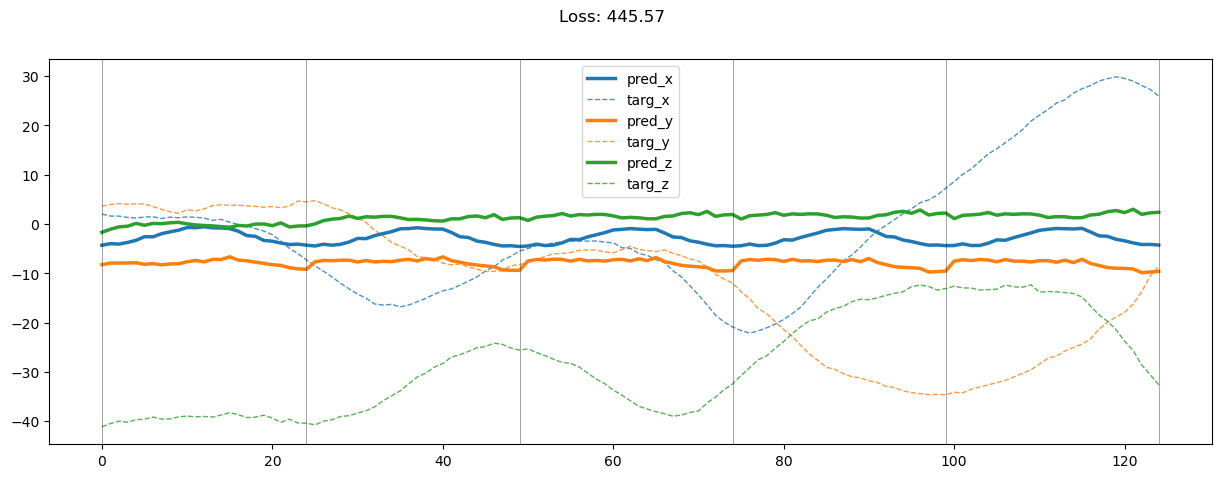

00849: train total loss:  2.393, pred loss:  2.393, valid total loss:  592.572, pred loss:  592.572


100%|██████████| 8/8 [00:00<00:00, 22.12it/s]


00850: train total loss:  2.435, pred loss:  2.435, valid total loss:  600.966, pred loss:  600.966


100%|██████████| 8/8 [00:00<00:00, 22.29it/s]


00851: train total loss:  2.259, pred loss:  2.259, valid total loss:  596.377, pred loss:  596.377


100%|██████████| 8/8 [00:00<00:00, 22.28it/s]


00852: train total loss:  2.451, pred loss:  2.451, valid total loss:  599.853, pred loss:  599.853


100%|██████████| 8/8 [00:00<00:00, 22.31it/s]


00853: train total loss:  2.403, pred loss:  2.403, valid total loss:  595.340, pred loss:  595.340


100%|██████████| 8/8 [00:00<00:00, 22.25it/s]


00854: train total loss:  2.425, pred loss:  2.425, valid total loss:  588.649, pred loss:  588.649


100%|██████████| 8/8 [00:00<00:00, 22.31it/s]


00855: train total loss:  2.494, pred loss:  2.494, valid total loss:  598.051, pred loss:  598.051


100%|██████████| 8/8 [00:00<00:00, 22.32it/s]


00856: train total loss:  2.870, pred loss:  2.870, valid total loss:  585.451, pred loss:  585.451


100%|██████████| 8/8 [00:00<00:00, 22.28it/s]


00857: train total loss:  3.071, pred loss:  3.071, valid total loss:  609.208, pred loss:  609.208


100%|██████████| 8/8 [00:00<00:00, 22.27it/s]


00858: train total loss:  3.539, pred loss:  3.539, valid total loss:  580.934, pred loss:  580.934


100%|██████████| 8/8 [00:00<00:00, 22.25it/s]


00859: train total loss:  3.209, pred loss:  3.209, valid total loss:  602.105, pred loss:  602.105


100%|██████████| 8/8 [00:00<00:00, 22.23it/s]


00860: train total loss:  2.908, pred loss:  2.908, valid total loss:  598.021, pred loss:  598.021


100%|██████████| 8/8 [00:00<00:00, 22.27it/s]


00861: train total loss:  2.839, pred loss:  2.839, valid total loss:  567.224, pred loss:  567.224


100%|██████████| 8/8 [00:00<00:00, 22.30it/s]


00862: train total loss:  3.100, pred loss:  3.100, valid total loss:  576.446, pred loss:  576.446


100%|██████████| 8/8 [00:00<00:00, 22.26it/s]


00863: train total loss:  2.992, pred loss:  2.992, valid total loss:  582.205, pred loss:  582.205


100%|██████████| 8/8 [00:00<00:00, 22.26it/s]


00864: train total loss:  2.755, pred loss:  2.755, valid total loss:  596.519, pred loss:  596.519


100%|██████████| 8/8 [00:00<00:00, 22.26it/s]


00865: train total loss:  2.545, pred loss:  2.545, valid total loss:  602.917, pred loss:  602.917


100%|██████████| 8/8 [00:00<00:00, 22.25it/s]


00866: train total loss:  2.283, pred loss:  2.283, valid total loss:  598.177, pred loss:  598.177


100%|██████████| 8/8 [00:00<00:00, 22.29it/s]


00867: train total loss:  2.346, pred loss:  2.346, valid total loss:  593.591, pred loss:  593.591


100%|██████████| 8/8 [00:00<00:00, 22.24it/s]


00868: train total loss:  2.069, pred loss:  2.069, valid total loss:  594.142, pred loss:  594.142


100%|██████████| 8/8 [00:00<00:00, 22.31it/s]


00869: train total loss:  2.012, pred loss:  2.012, valid total loss:  580.670, pred loss:  580.670


100%|██████████| 8/8 [00:00<00:00, 22.29it/s]


00870: train total loss:  2.151, pred loss:  2.151, valid total loss:  572.646, pred loss:  572.646


100%|██████████| 8/8 [00:00<00:00, 21.26it/s]


00871: train total loss:  2.213, pred loss:  2.213, valid total loss:  592.776, pred loss:  592.776


100%|██████████| 8/8 [00:00<00:00, 22.25it/s]


00872: train total loss:  2.187, pred loss:  2.187, valid total loss:  584.200, pred loss:  584.200


100%|██████████| 8/8 [00:00<00:00, 22.28it/s]


00873: train total loss:  2.071, pred loss:  2.071, valid total loss:  613.113, pred loss:  613.113


100%|██████████| 8/8 [00:00<00:00, 22.30it/s]


00874: train total loss:  2.091, pred loss:  2.091, valid total loss:  600.485, pred loss:  600.485


100%|██████████| 8/8 [00:00<00:00, 22.32it/s]


00875: train total loss:  2.081, pred loss:  2.081, valid total loss:  596.522, pred loss:  596.522


100%|██████████| 8/8 [00:00<00:00, 22.23it/s]


00876: train total loss:  2.286, pred loss:  2.286, valid total loss:  577.062, pred loss:  577.062


100%|██████████| 8/8 [00:00<00:00, 21.55it/s]


00877: train total loss:  2.442, pred loss:  2.442, valid total loss:  600.225, pred loss:  600.225


100%|██████████| 8/8 [00:00<00:00, 22.24it/s]


00878: train total loss:  2.497, pred loss:  2.497, valid total loss:  584.339, pred loss:  584.339


100%|██████████| 8/8 [00:00<00:00, 22.28it/s]


00879: train total loss:  2.455, pred loss:  2.455, valid total loss:  591.444, pred loss:  591.444


100%|██████████| 8/8 [00:00<00:00, 22.27it/s]


00880: train total loss:  2.550, pred loss:  2.550, valid total loss:  592.852, pred loss:  592.852


100%|██████████| 8/8 [00:00<00:00, 22.17it/s]


00881: train total loss:  2.459, pred loss:  2.459, valid total loss:  594.269, pred loss:  594.269


100%|██████████| 8/8 [00:00<00:00, 22.31it/s]


00882: train total loss:  2.452, pred loss:  2.452, valid total loss:  579.166, pred loss:  579.166


100%|██████████| 8/8 [00:00<00:00, 22.20it/s]


00883: train total loss:  2.723, pred loss:  2.723, valid total loss:  589.079, pred loss:  589.079


100%|██████████| 8/8 [00:00<00:00, 22.22it/s]


00884: train total loss:  2.950, pred loss:  2.950, valid total loss:  588.628, pred loss:  588.628


100%|██████████| 8/8 [00:00<00:00, 21.53it/s]


00885: train total loss:  2.715, pred loss:  2.715, valid total loss:  584.838, pred loss:  584.838


100%|██████████| 8/8 [00:00<00:00, 22.31it/s]


00886: train total loss:  3.052, pred loss:  3.052, valid total loss:  597.003, pred loss:  597.003


100%|██████████| 8/8 [00:00<00:00, 17.49it/s]


00887: train total loss:  2.933, pred loss:  2.933, valid total loss:  580.493, pred loss:  580.493


100%|██████████| 8/8 [00:00<00:00, 21.08it/s]


00888: train total loss:  2.991, pred loss:  2.991, valid total loss:  584.363, pred loss:  584.363


100%|██████████| 8/8 [00:00<00:00, 22.26it/s]


00889: train total loss:  2.673, pred loss:  2.673, valid total loss:  592.153, pred loss:  592.153


100%|██████████| 8/8 [00:00<00:00, 22.24it/s]


00890: train total loss:  2.505, pred loss:  2.505, valid total loss:  580.471, pred loss:  580.471


100%|██████████| 8/8 [00:00<00:00, 19.66it/s]


00891: train total loss:  2.289, pred loss:  2.289, valid total loss:  615.138, pred loss:  615.138


100%|██████████| 8/8 [00:00<00:00, 20.57it/s]


00892: train total loss:  2.401, pred loss:  2.401, valid total loss:  596.023, pred loss:  596.023


100%|██████████| 8/8 [00:00<00:00, 20.29it/s]


00893: train total loss:  2.578, pred loss:  2.578, valid total loss:  604.058, pred loss:  604.058


100%|██████████| 8/8 [00:00<00:00, 20.14it/s]


00894: train total loss:  2.490, pred loss:  2.490, valid total loss:  594.588, pred loss:  594.588


100%|██████████| 8/8 [00:00<00:00, 19.74it/s]


00895: train total loss:  2.574, pred loss:  2.574, valid total loss:  610.419, pred loss:  610.419


100%|██████████| 8/8 [00:00<00:00, 20.27it/s]


00896: train total loss:  2.663, pred loss:  2.663, valid total loss:  601.330, pred loss:  601.330


100%|██████████| 8/8 [00:00<00:00, 19.50it/s]


00897: train total loss:  2.370, pred loss:  2.370, valid total loss:  592.024, pred loss:  592.024


100%|██████████| 8/8 [00:00<00:00, 17.37it/s]


00898: train total loss:  2.219, pred loss:  2.219, valid total loss:  574.629, pred loss:  574.629


100%|██████████| 8/8 [00:00<00:00, 17.03it/s]


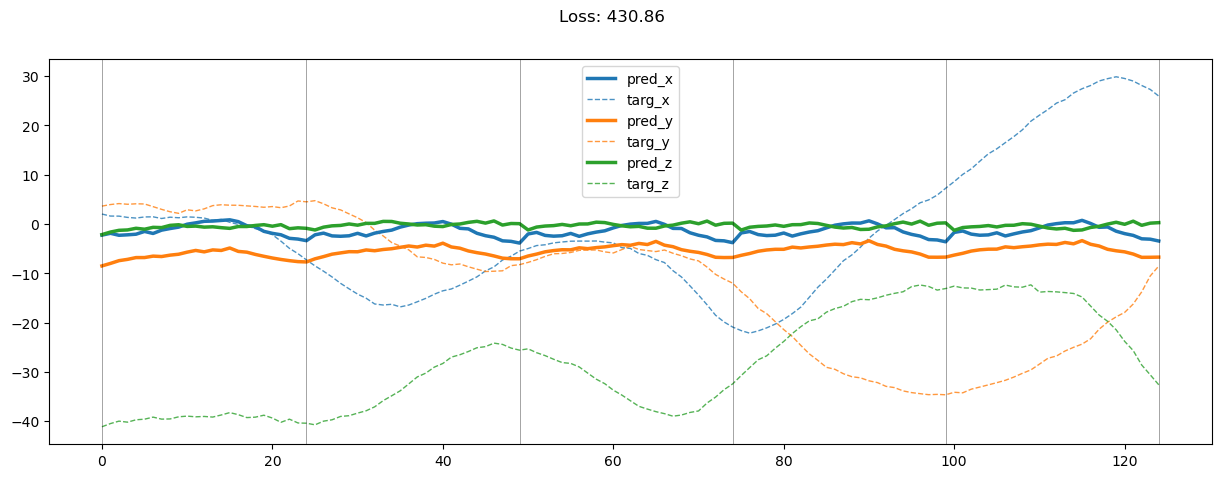

00899: train total loss:  2.167, pred loss:  2.167, valid total loss:  596.077, pred loss:  596.077


100%|██████████| 8/8 [00:00<00:00, 20.91it/s]


00900: train total loss:  2.601, pred loss:  2.601, valid total loss:  588.898, pred loss:  588.898


100%|██████████| 8/8 [00:00<00:00, 17.46it/s]


00901: train total loss:  2.454, pred loss:  2.454, valid total loss:  599.718, pred loss:  599.718


100%|██████████| 8/8 [00:00<00:00, 19.26it/s]


00902: train total loss:  2.461, pred loss:  2.461, valid total loss:  582.604, pred loss:  582.604


100%|██████████| 8/8 [00:00<00:00, 20.58it/s]


00903: train total loss:  2.300, pred loss:  2.300, valid total loss:  576.475, pred loss:  576.475


100%|██████████| 8/8 [00:00<00:00, 20.06it/s]


00904: train total loss:  2.371, pred loss:  2.371, valid total loss:  588.615, pred loss:  588.615


100%|██████████| 8/8 [00:00<00:00, 20.85it/s]


00905: train total loss:  2.129, pred loss:  2.129, valid total loss:  613.402, pred loss:  613.402


100%|██████████| 8/8 [00:00<00:00, 19.79it/s]


00906: train total loss:  2.292, pred loss:  2.292, valid total loss:  586.298, pred loss:  586.298


100%|██████████| 8/8 [00:00<00:00, 20.48it/s]


00907: train total loss:  2.284, pred loss:  2.284, valid total loss:  598.051, pred loss:  598.051


100%|██████████| 8/8 [00:00<00:00, 19.72it/s]


00908: train total loss:  2.408, pred loss:  2.408, valid total loss:  589.853, pred loss:  589.853


100%|██████████| 8/8 [00:00<00:00, 21.15it/s]


00909: train total loss:  2.344, pred loss:  2.344, valid total loss:  592.527, pred loss:  592.527


100%|██████████| 8/8 [00:00<00:00, 19.21it/s]


00910: train total loss:  2.117, pred loss:  2.117, valid total loss:  589.367, pred loss:  589.367


100%|██████████| 8/8 [00:00<00:00, 20.70it/s]


00911: train total loss:  2.143, pred loss:  2.143, valid total loss:  592.703, pred loss:  592.703


100%|██████████| 8/8 [00:00<00:00, 21.80it/s]


00912: train total loss:  2.122, pred loss:  2.122, valid total loss:  593.678, pred loss:  593.678


100%|██████████| 8/8 [00:00<00:00, 22.29it/s]


00913: train total loss:  1.979, pred loss:  1.979, valid total loss:  586.769, pred loss:  586.769


100%|██████████| 8/8 [00:00<00:00, 21.67it/s]


00914: train total loss:  2.066, pred loss:  2.066, valid total loss:  604.122, pred loss:  604.122


100%|██████████| 8/8 [00:00<00:00, 22.26it/s]


00915: train total loss:  2.356, pred loss:  2.356, valid total loss:  602.002, pred loss:  602.002


100%|██████████| 8/8 [00:00<00:00, 22.29it/s]


00916: train total loss:  2.282, pred loss:  2.282, valid total loss:  577.046, pred loss:  577.046


100%|██████████| 8/8 [00:00<00:00, 22.27it/s]


00917: train total loss:  2.301, pred loss:  2.301, valid total loss:  572.637, pred loss:  572.637


100%|██████████| 8/8 [00:00<00:00, 22.18it/s]


00918: train total loss:  2.213, pred loss:  2.213, valid total loss:  586.933, pred loss:  586.933


100%|██████████| 8/8 [00:00<00:00, 22.31it/s]


00919: train total loss:  2.224, pred loss:  2.224, valid total loss:  597.894, pred loss:  597.894


100%|██████████| 8/8 [00:00<00:00, 22.29it/s]


00920: train total loss:  2.277, pred loss:  2.277, valid total loss:  578.081, pred loss:  578.081


100%|██████████| 8/8 [00:00<00:00, 22.26it/s]


00921: train total loss:  2.326, pred loss:  2.326, valid total loss:  577.054, pred loss:  577.054


100%|██████████| 8/8 [00:00<00:00, 22.12it/s]


00922: train total loss:  2.436, pred loss:  2.436, valid total loss:  571.719, pred loss:  571.719


100%|██████████| 8/8 [00:00<00:00, 22.27it/s]


00923: train total loss:  2.756, pred loss:  2.756, valid total loss:  581.528, pred loss:  581.528


100%|██████████| 8/8 [00:00<00:00, 20.06it/s]


00924: train total loss:  2.555, pred loss:  2.555, valid total loss:  589.376, pred loss:  589.376


100%|██████████| 8/8 [00:00<00:00, 22.14it/s]


00925: train total loss:  2.447, pred loss:  2.447, valid total loss:  580.007, pred loss:  580.007


100%|██████████| 8/8 [00:00<00:00, 22.14it/s]


00926: train total loss:  2.430, pred loss:  2.430, valid total loss:  579.741, pred loss:  579.741


100%|██████████| 8/8 [00:00<00:00, 22.25it/s]


00927: train total loss:  2.394, pred loss:  2.394, valid total loss:  568.296, pred loss:  568.296


100%|██████████| 8/8 [00:00<00:00, 19.73it/s]


00928: train total loss:  2.274, pred loss:  2.274, valid total loss:  599.923, pred loss:  599.923


100%|██████████| 8/8 [00:00<00:00, 19.59it/s]


00929: train total loss:  2.265, pred loss:  2.265, valid total loss:  605.740, pred loss:  605.740


100%|██████████| 8/8 [00:00<00:00, 20.12it/s]


00930: train total loss:  2.213, pred loss:  2.213, valid total loss:  598.630, pred loss:  598.630


100%|██████████| 8/8 [00:00<00:00, 20.08it/s]


00931: train total loss:  2.055, pred loss:  2.055, valid total loss:  603.418, pred loss:  603.418


100%|██████████| 8/8 [00:00<00:00, 20.85it/s]


00932: train total loss:  1.967, pred loss:  1.967, valid total loss:  587.569, pred loss:  587.569


100%|██████████| 8/8 [00:00<00:00, 20.66it/s]


00933: train total loss:  1.923, pred loss:  1.923, valid total loss:  593.096, pred loss:  593.096


100%|██████████| 8/8 [00:00<00:00, 19.81it/s]


00934: train total loss:  2.159, pred loss:  2.159, valid total loss:  580.343, pred loss:  580.343


100%|██████████| 8/8 [00:00<00:00, 19.82it/s]


00935: train total loss:  2.283, pred loss:  2.283, valid total loss:  586.500, pred loss:  586.500


100%|██████████| 8/8 [00:00<00:00, 20.43it/s]


00936: train total loss:  2.063, pred loss:  2.063, valid total loss:  571.707, pred loss:  571.707


100%|██████████| 8/8 [00:00<00:00, 19.95it/s]


00937: train total loss:  1.996, pred loss:  1.996, valid total loss:  602.514, pred loss:  602.514


100%|██████████| 8/8 [00:00<00:00, 19.30it/s]


00938: train total loss:  2.154, pred loss:  2.154, valid total loss:  591.695, pred loss:  591.695


100%|██████████| 8/8 [00:00<00:00, 19.87it/s]


00939: train total loss:  2.139, pred loss:  2.139, valid total loss:  579.194, pred loss:  579.194


100%|██████████| 8/8 [00:00<00:00, 19.95it/s]


00940: train total loss:  2.076, pred loss:  2.076, valid total loss:  592.909, pred loss:  592.909


100%|██████████| 8/8 [00:00<00:00, 19.60it/s]


00941: train total loss:  1.863, pred loss:  1.863, valid total loss:  578.408, pred loss:  578.408


100%|██████████| 8/8 [00:00<00:00, 20.08it/s]


00942: train total loss:  1.783, pred loss:  1.783, valid total loss:  577.828, pred loss:  577.828


100%|██████████| 8/8 [00:00<00:00, 19.76it/s]


00943: train total loss:  1.808, pred loss:  1.808, valid total loss:  583.009, pred loss:  583.009


100%|██████████| 8/8 [00:00<00:00, 19.78it/s]


00944: train total loss:  1.814, pred loss:  1.814, valid total loss:  573.987, pred loss:  573.987


100%|██████████| 8/8 [00:00<00:00, 20.33it/s]


00945: train total loss:  1.857, pred loss:  1.857, valid total loss:  584.165, pred loss:  584.165


100%|██████████| 8/8 [00:00<00:00, 18.54it/s]


00946: train total loss:  2.262, pred loss:  2.262, valid total loss:  597.535, pred loss:  597.535


100%|██████████| 8/8 [00:00<00:00, 22.41it/s]


00947: train total loss:  2.212, pred loss:  2.212, valid total loss:  589.065, pred loss:  589.065


100%|██████████| 8/8 [00:00<00:00, 22.33it/s]


00948: train total loss:  2.114, pred loss:  2.114, valid total loss:  572.585, pred loss:  572.585


100%|██████████| 8/8 [00:00<00:00, 22.41it/s]


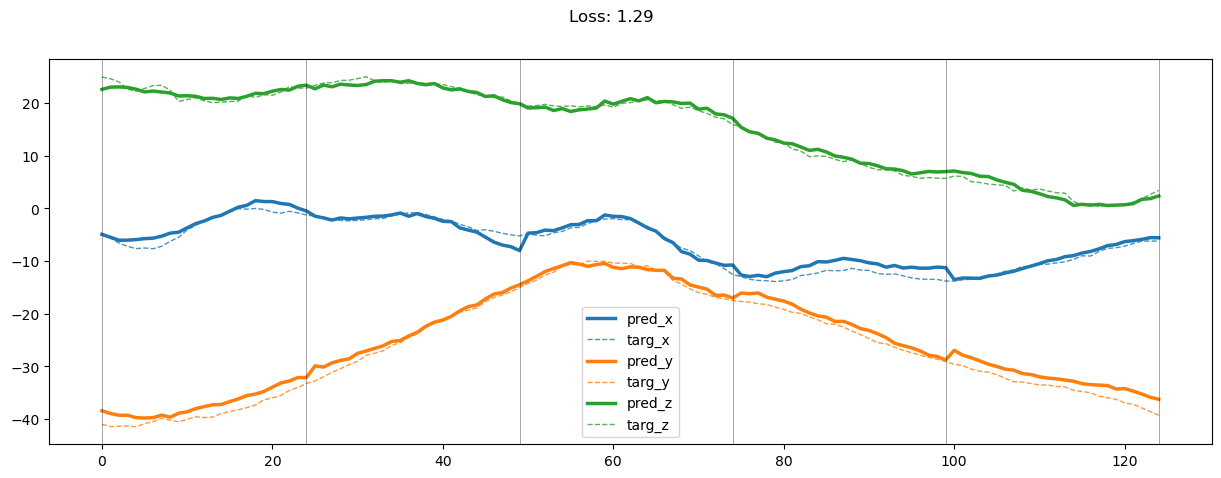

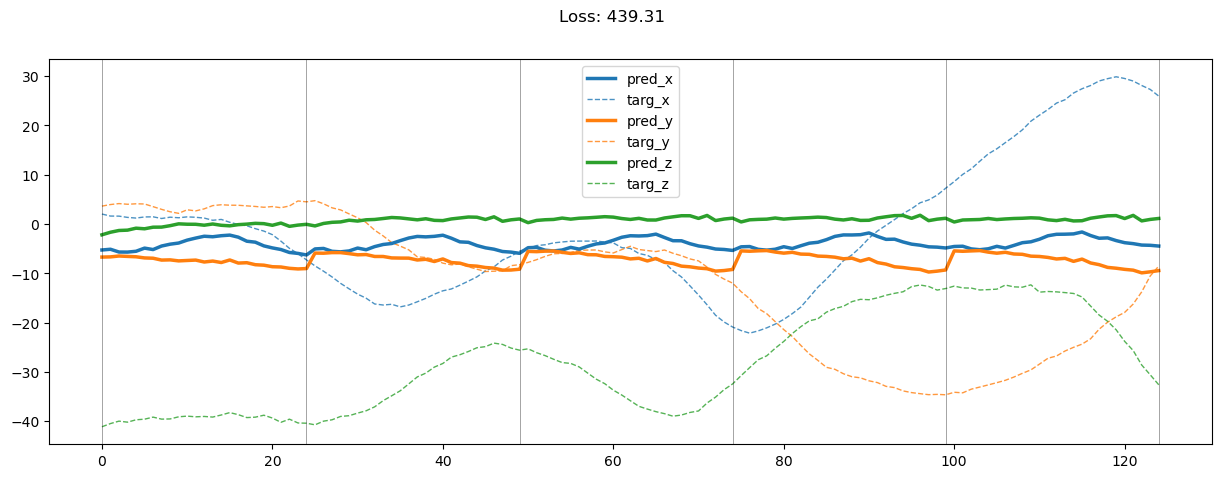

00949: train total loss:  2.086, pred loss:  2.086, valid total loss:  591.774, pred loss:  591.774


100%|██████████| 8/8 [00:00<00:00, 17.92it/s]


00950: train total loss:  2.059, pred loss:  2.059, valid total loss:  573.464, pred loss:  573.464


100%|██████████| 8/8 [00:00<00:00, 19.55it/s]


00951: train total loss:  2.047, pred loss:  2.047, valid total loss:  561.812, pred loss:  561.812


100%|██████████| 8/8 [00:00<00:00, 19.67it/s]


00952: train total loss:  2.008, pred loss:  2.008, valid total loss:  578.819, pred loss:  578.819


100%|██████████| 8/8 [00:00<00:00, 20.73it/s]


00953: train total loss:  1.927, pred loss:  1.927, valid total loss:  583.273, pred loss:  583.273


100%|██████████| 8/8 [00:00<00:00, 20.89it/s]


00954: train total loss:  1.872, pred loss:  1.872, valid total loss:  585.184, pred loss:  585.184


100%|██████████| 8/8 [00:00<00:00, 20.44it/s]


00955: train total loss:  1.972, pred loss:  1.972, valid total loss:  579.388, pred loss:  579.388


100%|██████████| 8/8 [00:00<00:00, 20.45it/s]


00956: train total loss:  2.038, pred loss:  2.038, valid total loss:  556.784, pred loss:  556.784


100%|██████████| 8/8 [00:00<00:00, 19.12it/s]


00957: train total loss:  1.979, pred loss:  1.979, valid total loss:  576.813, pred loss:  576.813


100%|██████████| 8/8 [00:00<00:00, 17.57it/s]


00958: train total loss:  1.898, pred loss:  1.898, valid total loss:  563.748, pred loss:  563.748


100%|██████████| 8/8 [00:00<00:00, 19.66it/s]


00959: train total loss:  1.953, pred loss:  1.953, valid total loss:  573.793, pred loss:  573.793


100%|██████████| 8/8 [00:00<00:00, 19.65it/s]


00960: train total loss:  2.056, pred loss:  2.056, valid total loss:  566.541, pred loss:  566.541


100%|██████████| 8/8 [00:00<00:00, 17.09it/s]


00961: train total loss:  2.016, pred loss:  2.016, valid total loss:  588.845, pred loss:  588.845


100%|██████████| 8/8 [00:00<00:00, 17.08it/s]


00962: train total loss:  2.045, pred loss:  2.045, valid total loss:  564.218, pred loss:  564.218


100%|██████████| 8/8 [00:00<00:00, 19.30it/s]


00963: train total loss:  2.149, pred loss:  2.149, valid total loss:  581.957, pred loss:  581.957


100%|██████████| 8/8 [00:00<00:00, 19.92it/s]


00964: train total loss:  2.377, pred loss:  2.377, valid total loss:  572.563, pred loss:  572.563


100%|██████████| 8/8 [00:00<00:00, 19.68it/s]


00965: train total loss:  2.811, pred loss:  2.811, valid total loss:  592.703, pred loss:  592.703


100%|██████████| 8/8 [00:00<00:00, 18.84it/s]


00966: train total loss:  2.738, pred loss:  2.738, valid total loss:  584.069, pred loss:  584.069


100%|██████████| 8/8 [00:00<00:00, 20.16it/s]


00967: train total loss:  2.510, pred loss:  2.510, valid total loss:  572.264, pred loss:  572.264


100%|██████████| 8/8 [00:00<00:00, 19.92it/s]


00968: train total loss:  2.384, pred loss:  2.384, valid total loss:  588.644, pred loss:  588.644


100%|██████████| 8/8 [00:00<00:00, 20.10it/s]


00969: train total loss:  2.045, pred loss:  2.045, valid total loss:  590.506, pred loss:  590.506


100%|██████████| 8/8 [00:00<00:00, 20.01it/s]


00970: train total loss:  2.354, pred loss:  2.354, valid total loss:  601.811, pred loss:  601.811


100%|██████████| 8/8 [00:00<00:00, 20.54it/s]


00971: train total loss:  2.501, pred loss:  2.501, valid total loss:  582.209, pred loss:  582.209


100%|██████████| 8/8 [00:00<00:00, 20.83it/s]


00972: train total loss:  2.496, pred loss:  2.496, valid total loss:  610.041, pred loss:  610.041


100%|██████████| 8/8 [00:00<00:00, 20.64it/s]


00973: train total loss:  2.354, pred loss:  2.354, valid total loss:  592.550, pred loss:  592.550


100%|██████████| 8/8 [00:00<00:00, 19.88it/s]


00974: train total loss:  2.005, pred loss:  2.005, valid total loss:  597.182, pred loss:  597.182


100%|██████████| 8/8 [00:00<00:00, 22.33it/s]


00975: train total loss:  2.267, pred loss:  2.267, valid total loss:  596.622, pred loss:  596.622


100%|██████████| 8/8 [00:00<00:00, 19.75it/s]


00976: train total loss:  3.023, pred loss:  3.023, valid total loss:  590.107, pred loss:  590.107


100%|██████████| 8/8 [00:00<00:00, 19.44it/s]


00977: train total loss:  3.045, pred loss:  3.045, valid total loss:  605.702, pred loss:  605.702


100%|██████████| 8/8 [00:00<00:00, 19.91it/s]


00978: train total loss:  3.517, pred loss:  3.517, valid total loss:  585.556, pred loss:  585.556


100%|██████████| 8/8 [00:00<00:00, 17.33it/s]


00979: train total loss:  4.113, pred loss:  4.113, valid total loss:  564.796, pred loss:  564.796


100%|██████████| 8/8 [00:00<00:00, 20.04it/s]


00980: train total loss:  3.595, pred loss:  3.595, valid total loss:  588.770, pred loss:  588.770


100%|██████████| 8/8 [00:00<00:00, 19.91it/s]


00981: train total loss:  3.592, pred loss:  3.592, valid total loss:  594.312, pred loss:  594.312


100%|██████████| 8/8 [00:00<00:00, 20.23it/s]


00982: train total loss:  3.305, pred loss:  3.305, valid total loss:  596.534, pred loss:  596.534


100%|██████████| 8/8 [00:00<00:00, 19.49it/s]


00983: train total loss:  3.065, pred loss:  3.065, valid total loss:  600.043, pred loss:  600.043


100%|██████████| 8/8 [00:00<00:00, 18.66it/s]


00984: train total loss:  3.021, pred loss:  3.021, valid total loss:  624.654, pred loss:  624.654


100%|██████████| 8/8 [00:00<00:00, 20.59it/s]


00985: train total loss:  3.284, pred loss:  3.284, valid total loss:  566.256, pred loss:  566.256


100%|██████████| 8/8 [00:00<00:00, 22.24it/s]


00986: train total loss:  3.052, pred loss:  3.052, valid total loss:  583.028, pred loss:  583.028


100%|██████████| 8/8 [00:00<00:00, 22.44it/s]


00987: train total loss:  2.953, pred loss:  2.953, valid total loss:  566.491, pred loss:  566.491


100%|██████████| 8/8 [00:00<00:00, 22.40it/s]


00988: train total loss:  2.909, pred loss:  2.909, valid total loss:  615.622, pred loss:  615.622


100%|██████████| 8/8 [00:00<00:00, 20.75it/s]


00989: train total loss:  2.593, pred loss:  2.593, valid total loss:  592.048, pred loss:  592.048


100%|██████████| 8/8 [00:00<00:00, 19.82it/s]


00990: train total loss:  2.593, pred loss:  2.593, valid total loss:  607.649, pred loss:  607.649


100%|██████████| 8/8 [00:00<00:00, 21.05it/s]


00991: train total loss:  2.538, pred loss:  2.538, valid total loss:  599.435, pred loss:  599.435


100%|██████████| 8/8 [00:00<00:00, 20.19it/s]


00992: train total loss:  2.469, pred loss:  2.469, valid total loss:  598.881, pred loss:  598.881


100%|██████████| 8/8 [00:00<00:00, 20.03it/s]


00993: train total loss:  2.740, pred loss:  2.740, valid total loss:  603.345, pred loss:  603.345


100%|██████████| 8/8 [00:00<00:00, 20.63it/s]


00994: train total loss:  2.570, pred loss:  2.570, valid total loss:  594.061, pred loss:  594.061


100%|██████████| 8/8 [00:00<00:00, 20.63it/s]


00995: train total loss:  2.247, pred loss:  2.247, valid total loss:  605.467, pred loss:  605.467


100%|██████████| 8/8 [00:00<00:00, 19.86it/s]


00996: train total loss:  2.249, pred loss:  2.249, valid total loss:  588.257, pred loss:  588.257


100%|██████████| 8/8 [00:00<00:00, 17.49it/s]


00997: train total loss:  2.134, pred loss:  2.134, valid total loss:  601.624, pred loss:  601.624


100%|██████████| 8/8 [00:00<00:00, 22.34it/s]


00998: train total loss:  2.139, pred loss:  2.139, valid total loss:  579.372, pred loss:  579.372


100%|██████████| 8/8 [00:00<00:00, 22.40it/s]


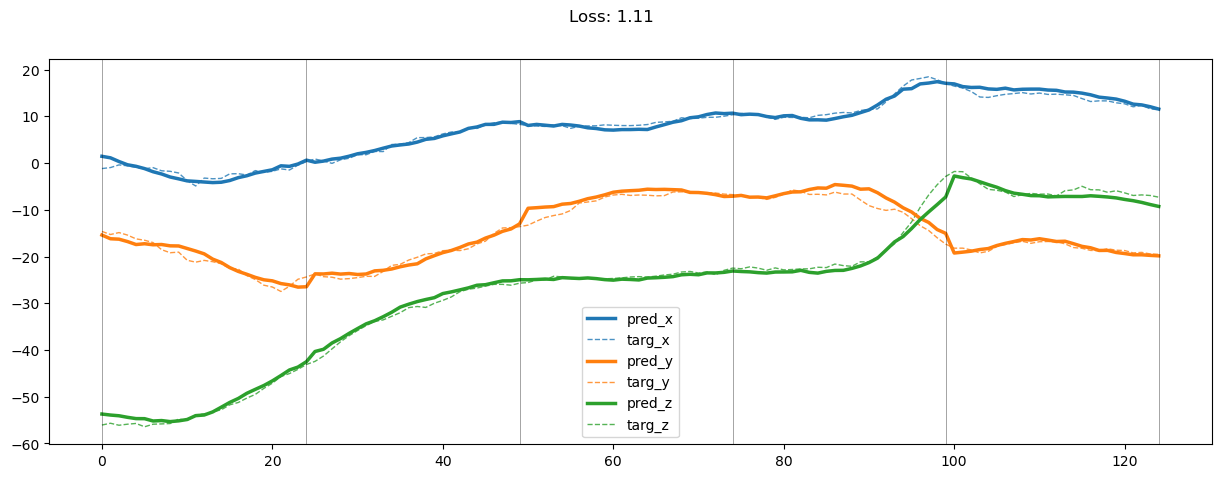

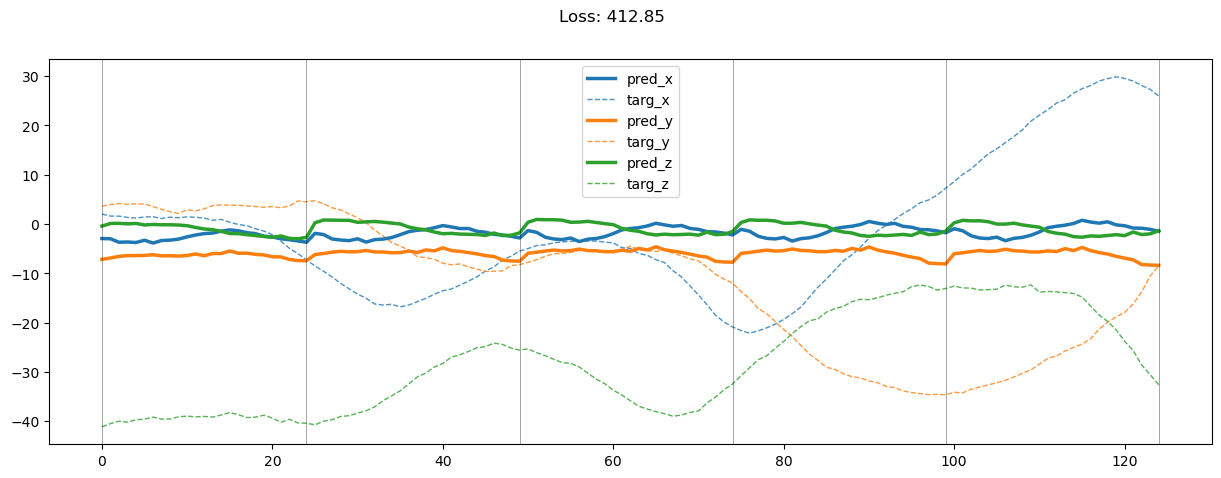

00999: train total loss:  2.004, pred loss:  2.004, valid total loss:  588.076, pred loss:  588.076


In [28]:
draw = True

for epoch in range(EPOCH):
    #####
    # 1. 用上半部訓練50epoch
    # 2. 隨機用上或下半部訓練Model
    # 3. 印出trajectory結果
    #####
    
    if (epoch + 1) % 50 == 0:
        draw = True
    
    train_loss, train_pred_loss = train(model, train_loader, optimizer, draw)
    valid_loss, valid_pred_loss = evalute(model, valid_loader, draw)
    
    draw = False
    
    ep = str(epoch).zfill(5)
    print(f'{ep}: train total loss: {train_loss: 2.3f}, pred loss: {train_pred_loss: 2.3f}, valid total loss: {valid_loss: 2.3f}, pred loss: {valid_pred_loss: 2.3f}')

In [46]:
def output_eval(model, dataloader):
    model.eval()
    
    results = []
    
    with torch.no_grad():
        for source_data, source_label, target_data, target_label in dataloader:
            source_data = source_data.to(device)
            target_data = target_data.to(device)

            #############
            # generator #
            #############
            predict_mag = model(source_data[:, :, :, 9:12])

            predict_loss = mse_loss(predict_mag, target_data[:, :, :, 9:12])
            
            results.extend(zip(predict_mag.detach().cpu().numpy(), target_data[:, :, :, 9:12].cpu().numpy()))
            
            break
    
    return np.array(results)

In [175]:
def plot_result(result):
    pred_mag = result[0].reshape(-1, 3)
    targ_mag = result[1].reshape(-1, 3)
    x = np.arange(len(pred_mag))
    
    loss = mse_loss(torch.tensor(pred_mag), torch.tensor(targ_mag)).item()
    
    fig = plt.figure(figsize=(15, 5))
    
    for pm, tm, caxis, color in zip(pred_mag.T, targ_mag.T, ['x', 'y', 'z'], ['tab:blue', 'tab:orange', 'tab:green']):
        #plt.plot(x, pm, label=f'pred_{caxis}', color=color, linewidth=2.5, zorder=2)
        plt.plot(x, tm, '--', label=f'targ_{caxis}', color=color, linewidth=1, alpha=0.8, zorder=1)
    
    for i in range(0, chunk_size+1):
        plt.axvline(x=int(i * seq_len - 0.5), linewidth=0.5, linestyle='-', color='k', alpha=0.5)
    
    plt.suptitle(f'Loss: {loss:.2f}')
    plt.legend()
    plt.show()

In [81]:
results = output_eval(model, train_loader)

In [77]:
results.shape

(32, 2, 5, 25, 3)

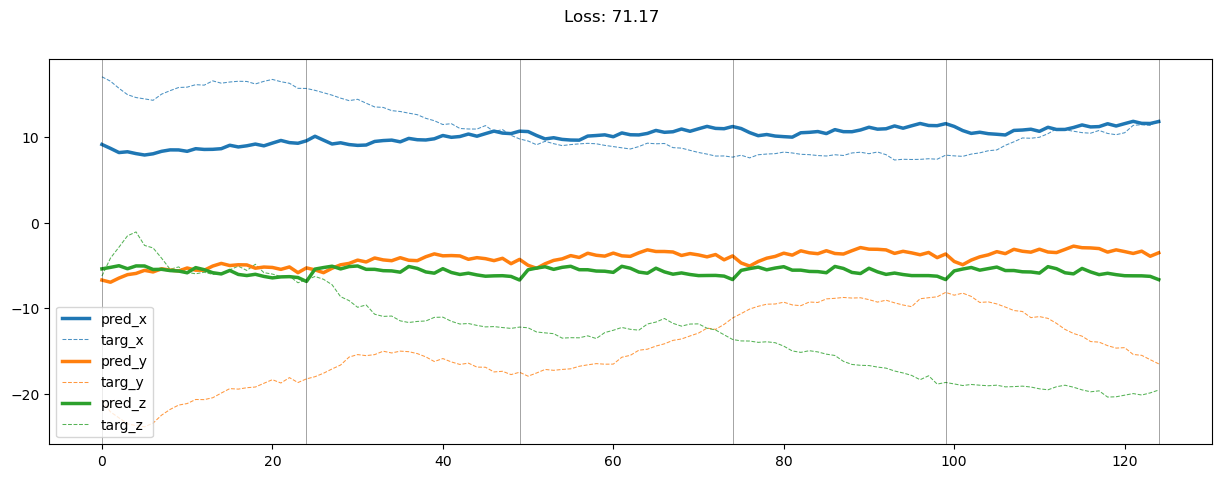

In [176]:
for rs in results:
    plot_result(rs)
    break